Machine Learning aplicado a la predicción de precio de criptomonedas, utilizando valores anteriores de las principales critpomonedas, valores de índices de stocks, y trends de búsqueda. 

In [3]:
# Manipulación de datos
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # Plots
import matplotlib.gridspec as gridspec
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import time
import warnings
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt

#Manejo de archivos
import os
import tempfile
import shutil
import json

import DataManager as dm

colores_test = ['r','g','b','c']
colores_futuro = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
criptomonedas_posibles = ['bitcoin','ethereum','ripple','dash','litecoin',
                     'monero','ethereum-classic','nem','augur',                 
                     'litecoin','cardano','stellar','iota','tron',
                     'neo','dash','bitcoin-cash','eos','vechain',
                     'tether','qtum','omisego','icon','binance-coin',
                     'lisk','bitcoin-gold','bytecoin-bcn','nano','verge',
                     'zcash','aeternity','zilliqa']
top_criptomonedas = ['bitcoin','ethereum','ripple','dash','litecoin','monero','ethereum-classic','nem','augur']
stocks_names=['AAPL','FB','GOOG','GOOGL','IBM','INTC','MSFT','NFLX','ORCL','TSLA']
stockindex_names=['^IXIC','^RUT','^DJI','^GSPC']

# Conf
test_size = 30
target = 'Close bitcoin'
N_tests = 3 #Cuantos tests se van a hacer con la serie
colores = ['r','g','b','c']

# Crear carpeta donde se almacenarán las predicciones  
datasetfolder = "predicciones" + "/"  + target
if not os.path.exists(datasetfolder):
    os.makedirs(datasetfolder) # Crear carpeta de predicciones

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


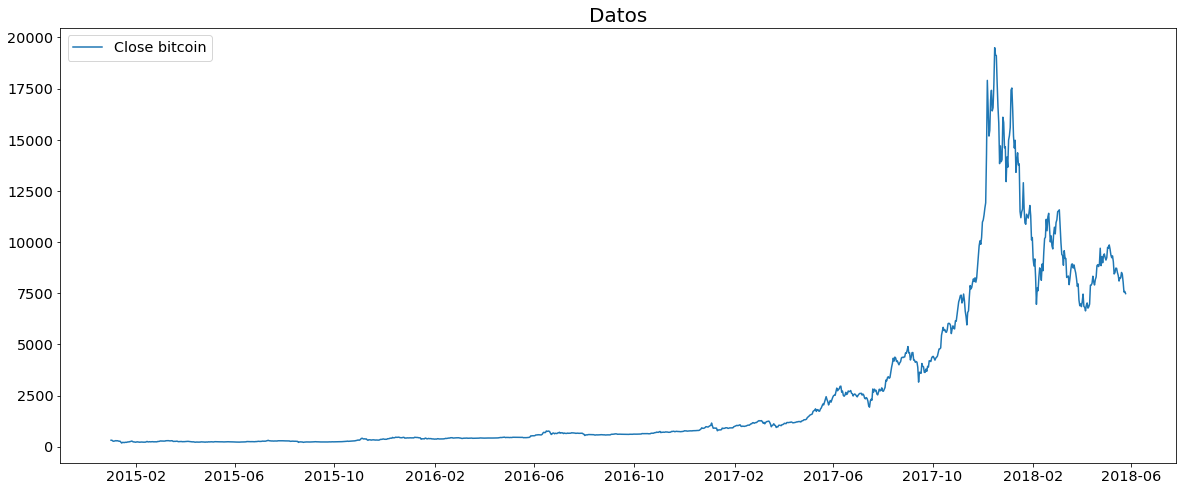

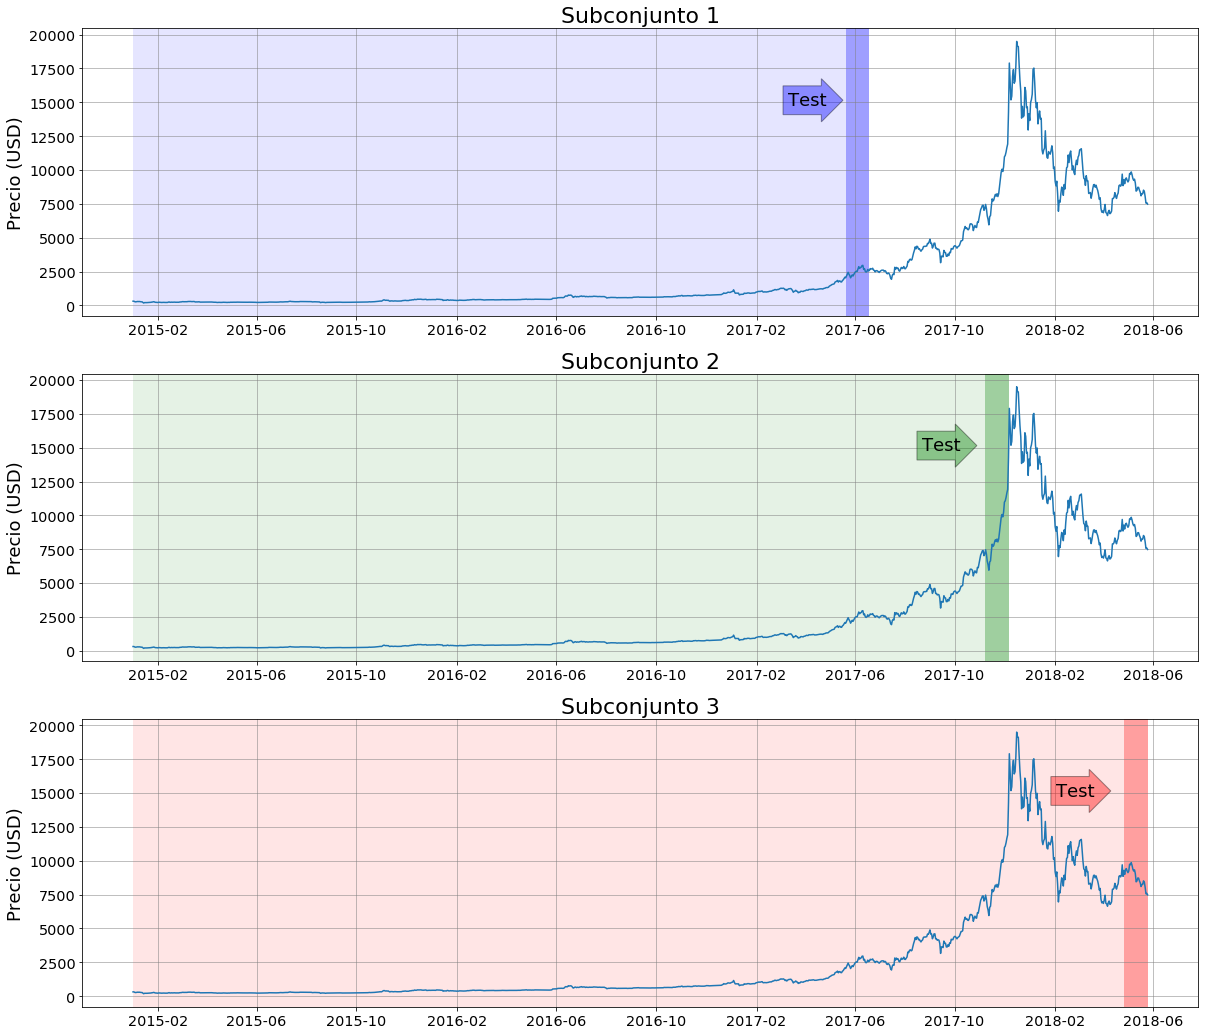

In [4]:
# Obtener curva de cierre de Bitcoin
data = pd.read_csv('data/data.csv', usecols= ['Date'] +  ['Close bitcoin'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[:'2018-05-25']

#Graficar la serie completa
plt.figure(figsize=(20,8))
for i in range(0,len(data.columns)):
    plt.plot(data.index, data[data.columns[i]], label=data.columns[i])
plt.legend(loc='upper left')
plt.title("Datos",fontsize=20)
plt.show()

fig = plt.figure(figsize=(20,6*N_tests))
gs = gridspec.GridSpec(N_tests, 1, wspace=0, hspace=0.2); i=0
for n_test in range(N_tests-1,-1,-1):
    end=None if n_test == 0 else n_test*(-200+test_size)
    subconjunto = data[:end]; subconjunto_test = subconjunto[-test_size:]
    ax = plt.subplot(gs[i, 0:])
    ax.plot(data.index, data)  
    plt.axvspan(subconjunto.index[0], subconjunto.index[-1], facecolor=colores[n_test], alpha=0.1)
    plt.axvspan(subconjunto_test.index[0], subconjunto_test.index[-1], facecolor=colores[n_test], alpha=0.3)
    ax.text(0.65+i*0.12, 0.75, "Test", ha="center", va="center", size=18,transform=ax.transAxes, bbox= dict(boxstyle="rarrow,pad=0.3", fc=colores[n_test], alpha=0.4))
    plt.ylabel('Precio (USD)', fontsize=18)
    plt.title("Subconjunto " + str(i+1),fontsize=22)
    plt.grid(color='grey', linestyle='-', linewidth=0.5); i+=1
plt.savefig('predicciones/esquema_subtesteos.png')

In [5]:
# Convertir el conjunto de datos como dos conjuntos x e y
def create_dataset(dataset,col_target,f):
    dataX, dataY = [], []
    for i in range(len(dataset)-f):  
        dataX.append(dataset[i,:])  #precio (BHC,ETH,LCT,XRP,...)
        dataY.append(dataset[i+f,col_target])  #precio BTC del dia futuro f
    return np.asarray(dataX), np.asarray(dataY)

# Convertir el conjunto de datos como dos conjuntos x e y, donde x no contiene al target
def create_dataset_sintarget(dataset,col_target,f):
    dataX, dataY = [], []
    dataset_sintarget = np.delete(dataset, col_target, 1)
    for i in range(len(dataset)-f):  
        dataX.append(dataset_sintarget[i,:])  #precio (BHC,ETH,LCT,XRP,...)
        dataY.append(dataset[i+f,col_target])  #precio BTC del dia futuro f
    return np.asarray(dataX), np.asarray(dataY)

def create_batches(dataset,targets,v):
    b = []
    t = []
    for i in range(len(dataset)-v):
        batch = dataset[i:i+v+1]
        b.append(batch)
        t.append(targets[i+v])
    return np.asarray(b),np.asarray(t)

# Método para hacer simulaciones con variaciones de neuronas
def simulacionNeuronas(data, neuronas, name):
    prediccioncompleta = data[[target]].copy() # Todas las predicciones en un dataframe (output de la simulacion)
    v = 0
    for n in neuronas: 
                    dataset_name = name + '_n' + str(n)                  
                    prediccionxdataset = pd.DataFrame() # todos los subconjuntos de test en un dataframe
                    entrenamientos = []
                    for n_test in range(N_tests-1,-1,-1):
                        end=None if n_test == 0 else n_test*(-200+test_size)
                        dataset = data.copy()[:end]
                        prediccion_subset = dataset[[target]][-test_size:].copy() #Dataframe con una sola columma: el precio real (luego se añade la prediccion)
                                                  
                        # Separar el datset en x e y (predicción para el día f)
                        x,y = create_dataset(np.asarray(dataset),dataset.columns.get_loc(target),1)
                        y = y.reshape(-1,1)
                        
                        # Separar x,y en conjuntos de entrenamiento y testeo (test_size+v para poder hacer ventanas de timesteps después de escalar y que siempre queden 30 puntos de predicción en test)
                        train_x, train_y = x[:-test_size], y[:-test_size]
                        test_x, test_y = x[-test_size-v:], y[-test_size-v:]
                        
                        # Normalización: Escalar los datos entre [0,1]. Hay que escalar con respecto al training set, como si el test set no estuviera.
                        scalerX = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_x)
                        train_x_scaled = scalerX.transform(train_x)
                        test_x_scaled = scalerX.transform(test_x)
                        scalerY = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_y)
                        train_y_scaled = scalerY.transform(train_y)
                        test_y_scaled = scalerY.transform(test_y)  
                        
                        # Crear batches de v timesteps (ventana)
                        input_train,target_train = create_batches(train_x_scaled,
                                                                  train_y_scaled,v)
                        input_test,target_test = create_batches(test_x_scaled,
                                                                test_y_scaled,v)
                    
                        #Construir red neuronal y entrenarla
                        model = Sequential()
                        model.add(LSTM(units = n, # dropout=0, 
                                           input_shape=(input_train.shape[1], 
                                                        input_train.shape[2]),
                                      return_sequences=False, activation = 'tanh'))
                        model.add(Dense(units = 1, activation = 'linear'))
                        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
                        early_stopping_monitor = EarlyStopping(monitor='val_loss',patience=10,verbose=1) # Stop loss después de *patience* epochs consecutivos sin mejora
                        history = model.fit(input_train, target_train, validation_split=0.2,
                                            batch_size=128, epochs = 300, callbacks=[early_stopping_monitor], 
                                            shuffle=False,verbose=1)  
                        
                        # Dataframe de entrenamiento
                        training_history = pd.DataFrame() 
                        training_history = pd.concat([training_history, pd.DataFrame(data=history.history['loss'], columns=[dataset_name +'_loss'])], axis=1)
                        training_history = pd.concat([training_history, pd.DataFrame(data=history.history['val_loss'], columns=[dataset_name + '_val_loss'])], axis=1)
                        training_history.to_csv(datasetfolder + '/entrenamiento_' + dataset_name + '('+ str(n_test+1) +').csv')
                        print('Entrenamiento ' + dataset_name + '('+ str(n_test+1) +') completo.')
                        entrenamientos.append(training_history)   
                              
                        #Predicción de testeo
                        predicted_scaled = model.predict(input_test)
                        predicted_scaled = predicted_scaled.reshape(-1,1)
                        predicted = scalerY.inverse_transform(predicted_scaled)
                        print(predicted)
                                                     
                        # Dataframe de prediccion del subset  
                        prediccion_subset[dataset_name] = predicted
                        # Agregar la prediccion del subset (30 dias) al dataframe con la prediccion completa (3 tests)
                        prediccionxdataset = prediccionxdataset.append(prediccion_subset)
                        
                    print('Predicción ' + dataset_name + ' completa.')     
                    # Agregar la predicción completa (3 tests) al dataframe con TODAS las predicciones para la moneda
                    prediccioncompleta = pd.merge(prediccioncompleta,prediccionxdataset.drop(columns=[target]),how="left",left_index=True,right_index=True)

    print("Simulación "+ name +" completa.")
    print(prediccioncompleta)
    prediccioncompleta.to_csv(datasetfolder + '/' + name + '.csv')
        
    return prediccioncompleta

# Método para hacer simulaciones con variaciones de tamaño de ventana
def simulacionVentana(data, ventanas, neuronas, name):
    prediccioncompleta = data[[target]].copy() # Todas las predicciones en un dataframe (output de la simulacion)
    for v in ventanas: 
                    dataset_name = name + '_v' + str(v)                  
                    prediccionxdataset = pd.DataFrame() # todos los subconjuntos de test en un dataframe
                    entrenamientos = []
                    for n_test in range(N_tests-1,-1,-1):
                        end=None if n_test == 0 else n_test*(-200+test_size)
                        dataset = data.copy()[:end]
                        prediccion_subset = dataset[[target]][-test_size:].copy() #Dataframe con una sola columma: el precio real (luego se añade la prediccion)
                                                  
                        # Separar el datset en x e y (predicción para el día f)
                        x,y = create_dataset(np.asarray(dataset),dataset.columns.get_loc(target),1)
                        y = y.reshape(-1,1)
                        
                        # Separar x,y en conjuntos de entrenamiento y testeo (test_size+v para poder hacer ventanas de timesteps después de escalar y que siempre queden 30 puntos de predicción en test)
                        train_x, train_y = x[:-test_size], y[:-test_size]
                        test_x, test_y = x[-test_size-v:], y[-test_size-v:]
                        
                        # Normalización: Escalar los datos entre [0,1]. Hay que escalar con respecto al training set, como si el test set no estuviera.
                        scalerX = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_x)
                        train_x_scaled = scalerX.transform(train_x)
                        test_x_scaled = scalerX.transform(test_x)
                        scalerY = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_y)
                        train_y_scaled = scalerY.transform(train_y)
                        test_y_scaled = scalerY.transform(test_y)  
                        
                        # Crear batches de v timesteps (ventana)
                        input_train,target_train = create_batches(train_x_scaled,
                                                                  train_y_scaled,v)
                        input_test,target_test = create_batches(test_x_scaled,
                                                                test_y_scaled,v)
                    
                        #Construir red neuronal y entrenarla
                        model = Sequential()
                        model.add(LSTM(units = neuronas, # dropout=0, 
                                           input_shape=(input_train.shape[1], 
                                                        input_train.shape[2]),
                                      return_sequences=False, activation = 'tanh'))
                        model.add(Dense(units = 1, activation = 'linear'))
                        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
                        early_stopping_monitor = EarlyStopping(monitor='val_loss',patience=10,verbose=1) # Stop loss después de *patience* epochs consecutivos sin mejora
                        history = model.fit(input_train, target_train, validation_split=0.2,
                                            batch_size=128, epochs = 300, callbacks=[early_stopping_monitor], 
                                            shuffle=False,verbose=1)  
                        
                        # Dataframe de entrenamiento
                        training_history = pd.DataFrame() 
                        training_history = pd.concat([training_history, pd.DataFrame(data=history.history['loss'], columns=[dataset_name +'_loss'])], axis=1)
                        training_history = pd.concat([training_history, pd.DataFrame(data=history.history['val_loss'], columns=[dataset_name + '_val_loss'])], axis=1)
                        training_history.to_csv(datasetfolder + '/entrenamiento_' + dataset_name + '('+ str(n_test+1) +').csv')
                        print('Entrenamiento ' + dataset_name + '('+ str(n_test+1) +') completo.')
                        entrenamientos.append(training_history)   
                              
                        #Predicción de testeo
                        predicted_scaled = model.predict(input_test)
                        predicted_scaled = predicted_scaled.reshape(-1,1)
                        predicted = scalerY.inverse_transform(predicted_scaled)
                        print(predicted)
                                                     
                        # Dataframe de prediccion del subset  
                        prediccion_subset[dataset_name] = predicted
                        # Agregar la prediccion del subset (30 dias) al dataframe con la prediccion completa (3 tests)
                        prediccionxdataset = prediccionxdataset.append(prediccion_subset)
                        
                    print('Predicción ' + dataset_name + ' completa.')     
                    # Agregar la predicción completa (3 tests) al dataframe con TODAS las predicciones para la moneda
                    prediccioncompleta = pd.merge(prediccioncompleta,prediccionxdataset.drop(columns=[target]),how="left",left_index=True,right_index=True)

    print("Simulación "+ name +" completa.")
    print(prediccioncompleta)
    prediccioncompleta.to_csv(datasetfolder + '/' + name + '.csv')
        
    return prediccioncompleta


# Método para hacer simulaciones con variaciones de variables
def simulacionVariables(data, neuronas, name):
    v = 0
    prediccioncompleta = data[[target]].copy() # Todas las predicciones en un dataframe (output de la simulacion)
    for variable in data.columns:
        if variable != target: 
                    dataset_name = name + ' ' + variable                
                    prediccionxdataset = pd.DataFrame() # todos los subconjuntos de test en un dataframe
                    entrenamientos = []
                    for n_test in range(N_tests-1,-1,-1):
                        end=None if n_test == 0 else n_test*(-200+test_size)
                        dataset = data[[target] + [variable]].copy()[:end]
                        prediccion_subset = dataset[[target]][-test_size:].copy() #Dataframe con una sola columma: el precio real (luego se añade la prediccion)
                                                  
                        # Separar el datset en x e y (predicción para el día f)
                        x,y = create_dataset(np.asarray(dataset),dataset.columns.get_loc(target),1)
                        y = y.reshape(-1,1)
                        
                        # Separar x,y en conjuntos de entrenamiento y testeo (test_size+v para poder hacer ventanas de timesteps después de escalar y que siempre queden 30 puntos de predicción en test)
                        train_x, train_y = x[:-test_size], y[:-test_size]
                        test_x, test_y = x[-test_size-v:], y[-test_size-v:]
                        
                        # Normalización: Escalar los datos entre [0,1]. Hay que escalar con respecto al training set, como si el test set no estuviera.
                        scalerX = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_x)
                        train_x_scaled = scalerX.transform(train_x)
                        test_x_scaled = scalerX.transform(test_x)
                        scalerY = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_y)
                        train_y_scaled = scalerY.transform(train_y)
                        test_y_scaled = scalerY.transform(test_y)  
                        
                        # Crear batches de v timesteps (ventana)
                        input_train,target_train = create_batches(train_x_scaled,
                                                                  train_y_scaled,v)
                        input_test,target_test = create_batches(test_x_scaled,
                                                                test_y_scaled,v)
                    
                        #Construir red neuronal y entrenarla
                        model = Sequential()
                        model.add(LSTM(units = neuronas, # dropout=0, 
                                           input_shape=(input_train.shape[1], 
                                                        input_train.shape[2]),
                                      return_sequences=False, activation = 'tanh'))
                        model.add(Dense(units = 1, activation = 'linear'))
                        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
                        early_stopping_monitor = EarlyStopping(monitor='val_loss',patience=10,verbose=1) # Stop loss después de *patience* epochs consecutivos sin mejora
                        history = model.fit(input_train, target_train, validation_split=0.2,
                                            batch_size=128, epochs = 300, callbacks=[early_stopping_monitor], 
                                            shuffle=False,verbose=1)  
                        
                        # Dataframe de entrenamiento
                        training_history = pd.DataFrame() 
                        training_history = pd.concat([training_history, pd.DataFrame(data=history.history['loss'], columns=[dataset_name +'_loss'])], axis=1)
                        training_history = pd.concat([training_history, pd.DataFrame(data=history.history['val_loss'], columns=[dataset_name + '_val_loss'])], axis=1)
                        training_history.to_csv(datasetfolder + '/entrenamiento_' + dataset_name + '('+ str(n_test+1) +').csv')
                        print('Entrenamiento ' + dataset_name + '('+ str(n_test+1) +') completo.')
                        entrenamientos.append(training_history)   
                              
                        #Predicción de testeo
                        predicted_scaled = model.predict(input_test)
                        predicted_scaled = predicted_scaled.reshape(-1,1)
                        predicted = scalerY.inverse_transform(predicted_scaled)
                        print(predicted)
                                                     
                        # Dataframe de prediccion del subset  
                        prediccion_subset[dataset_name] = predicted
                        # Agregar la prediccion del subset (30 dias) al dataframe con la prediccion completa (3 tests)
                        prediccionxdataset = prediccionxdataset.append(prediccion_subset)
                        
                    print('Predicción ' + dataset_name + ' completa.')     
                    # Agregar la predicción completa (3 tests) al dataframe con TODAS las predicciones para la moneda
                    prediccioncompleta = pd.merge(prediccioncompleta,prediccionxdataset.drop(columns=[target]),how="left",left_index=True,right_index=True)

    print("Simulación "+ name +" completa.")
    print(prediccioncompleta)
    prediccioncompleta.to_csv(datasetfolder + '/' + name + '.csv')
    
    #with open(datasetfolder + '/conf.json', 'w') as outfile:
    #    json.dump(conf_data, outfile)
        
    return prediccioncompleta

In [79]:
# Construir dataframes con RMSE y epochs por test
def postprocesamiento(prediccion, name, name_parametro, referencia = []):
    rmse_completo_y = []
    rmse_completo_x = []
    arreglo_nepochs = []
    for simulacion_i in prediccion.columns[1:]:
                    dataset_name = simulacion_i; i=1
                    prediccionxdataset = pd.DataFrame()
                    arreglo_nepochs_simulacion_i = [simulacion_i]
                    for n_test in range(N_tests-1,-1,-1):
                        end=None if n_test == 0 else n_test*(-200+test_size)
                        subset = prediccion[:end]
                        subset_moneda = subset[subset.columns[0]]
                        subset_prediccion = subset[[simulacion_i]][-test_size:]
                        prediccionxdataset = prediccionxdataset.append(
                            pd.concat([subset_moneda[-test_size:], subset_prediccion], axis=1))                 
                                                
                        #Cada entrenamiento                        
                        entrenamiento = pd.read_csv(datasetfolder + '/entrenamiento_' + dataset_name + '('+ str(n_test+1) +').csv',index_col =0)
                        arreglo_nepochs_simulacion_i.append(entrenamiento.shape[0]) # Obtener cantidad de epochs
                                              
                        #RMSE
                        rmse = sqrt(mean_squared_error(subset_moneda[-test_size:], subset_prediccion))
                        rmse_completo_y.append(rmse)
                        rmse_completo_x.append(simulacion_i + ' RMSE (' + str(i) + ')')

                        i+=1
                   
                    rmse_general = sqrt(mean_squared_error(prediccionxdataset[prediccionxdataset.columns[0]], 
                                                           prediccionxdataset[prediccionxdataset.columns[1]]))
                    rmse_completo_y.append(rmse_general)
                    rmse_completo_x.append(simulacion_i + 'RMSE (General)')
                    
                    arreglo_nepochs.append(arreglo_nepochs_simulacion_i) #Agregar la cantidad de epochs para la simulacion i
                    
    # Construir un csv con todos los RMSE
    arreglo_rmse = []; i=0
    for simulacion_i in prediccion.columns[1:]:
        arreglo_rmse.append([simulacion_i] + rmse_completo_y[i:i+4]); i+=4
    dataframe_rmse = pd.DataFrame(arreglo_rmse, columns=['Simulacion','RMSE (1)','RMSE (2)','RMSE (3)','RMSE (General)'])
    dataframe_rmse.set_index('Simulacion',inplace=True)
    dataframe_rmse.to_csv(datasetfolder + '/' + target + ' ' + name + '_rmses.csv')
    print('RMSEs guardados: ' + datasetfolder + '/' + target + ' ' + name + '_rmses.csv')
    
    # Construir un csv con los epochs 
    dataframe_epochs = pd.DataFrame(arreglo_nepochs, columns=['Simulacion','Epochs (1)','Epochs (2)','Epochs (3)'])
    dataframe_epochs.set_index('Simulacion',inplace=True)
    dataframe_epochs.to_csv(datasetfolder + '/' + target + ' ' + name + '_epochs.csv')
    print('Epochs guardados: ' + datasetfolder + '/' + target + ' ' + name + '_rmses.csv')
        
    # Graficar RMSE en barras
    width = 1/1.5
    plt.figure(figsize=(25,8))
    barplot = plt.bar(rmse_completo_x, rmse_completo_y, width)
    col = 0;
    for rect in barplot: # Valores en las barras
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=22, ha='center',va='bottom',rotation=90)
        rect.set_color(colores_test[col])
        col = (col+1)%4
    plt.xticks(rotation=60, ha="right")
    plt.ylim(ymax=max(rmse_completo_y)*1.2)
    plt.ylabel('Error', fontsize=18)
    plt.title("RMSE", fontsize=22)
    plt.savefig(datasetfolder + '/' + target + ' ' + name + 'RMSE_barra.png', bbox_inches='tight')  
    
    #Graficar RMSE por variación del parámetro
    plt.figure(figsize=(20,8)); col = 0
    for i in range(0,len(dataframe_rmse.columns)):
        plt.plot(dataframe_rmse.index, dataframe_rmse[dataframe_rmse.columns[i]], label=dataframe_rmse.columns[i], color=colores_test[col]);  col = (col+1)%4
    for r in referencia:
        plt.axhline(r,linestyle='--', color=colores_test[col], alpha=0.6); col=(col+1)%4
    plt.legend(loc='upper left')
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    plt.xticks(rotation=20, ha="right")
    plt.ylabel('Error', fontsize=18)
    plt.title("RMSE vs. " + name_parametro,fontsize=20)
    plt.savefig(datasetfolder + '/' + target + ' ' + name + 'RMSE_lineal.png', bbox_inches='tight') 
    plt.show()
    
    #Graficar EPOCHS por variación del parámetro
    plt.figure(figsize=(20,8)); col = 0
    for i in range(0,len(dataframe_epochs.columns)):
        plt.plot(dataframe_epochs.index, dataframe_epochs[dataframe_epochs.columns[i]], label=dataframe_epochs.columns[i], color=colores_test[col]);  col = (col+1)%3
    plt.legend(loc='upper left')
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    plt.xticks(rotation=20, ha="right")
    plt.ylabel('Epochs', fontsize=18)
    plt.title("Epochs vs. " + name_parametro,fontsize=20)
    plt.savefig(datasetfolder + '/' + target + ' ' + name + 'Epochs.png', bbox_inches='tight') 
    plt.show()  
    
    return (dataframe_rmse,dataframe_epochs)


# Graficar la simulacion i para la prediccion 
def graficarSimulacion(prediccion, simulacion_i, dataframe_rmse, dataframe_epochs, name, name_parametro):
                    dataset_name = simulacion_i
                    i = 1
                    
                    #Visualización de resultados
                    fig = plt.figure(figsize=(25,10*4))
                    gs = gridspec.GridSpec(5, 4, wspace=0.3, hspace=0.4)

                    #Todas los subsets para un dataset
                    axPrediccionCompleta = plt.subplot(gs[0, 0:])
                    axPrediccionCompleta.plot(prediccion.index, prediccion[prediccion.columns[0]], color='dimgray', label="Precio Real")  
                    axPrediccionCompleta.set_ylabel('Precio (USD)', fontsize=18)
                    plt.xticks(rotation=30, ha="right")
                    axPrediccionCompleta.set_title("Predicciones " + simulacion_i,fontsize=22)
                    axPrediccionCompleta.grid(color='grey', linestyle='-', linewidth=0.5) 
                    rmse_general = dataframe_rmse.loc[simulacion_i, 'RMSE (General)'] # Obtener el RMSE para la prediccion
                    axPrediccionCompleta.text(0.05, 0.1, 'RMSE ' + str('% 6.2f' % rmse_general), 
                                            horizontalalignment='left',verticalalignment='center', 
                                            transform=axPrediccionCompleta.transAxes, fontsize=17, bbox=dict(facecolor='red', alpha=0.5))
                  
                    prediccionxdataset = pd.DataFrame()
                    for n_test in range(N_tests-1,-1,-1):
                        end=None if n_test == 0 else n_test*(-200+test_size)
                        subset = prediccion[:end]
                        subset_moneda = subset[subset.columns[0]]
                        subset_prediccion = subset[[simulacion_i]][-test_size:]
                        prediccionxdataset = prediccionxdataset.append(
                            pd.concat([subset_moneda[-test_size:], subset_prediccion], axis=1))
                        
                        #Graficar la serie completa
                        axPrediccionCompleta.plot(subset_prediccion.index, subset_prediccion, color=colores_test[n_test], label='Prediccion (' + str(n_test+1) + ')')
                        axPrediccionCompleta.axvspan(subset_prediccion.index[0], subset_prediccion.index[-1], facecolor=colores_test[n_test], alpha=0.1)  
                        axPrediccionCompleta.legend(loc='upper left')                        
                                                
                        #Cada entrenamiento                        
                        entrenamiento = pd.read_csv(datasetfolder + '/entrenamiento_' + dataset_name + '('+ str(n_test+1) +').csv',index_col =0)
                        axTraining = plt.subplot(gs[i, 0])
                        axTraining.plot(entrenamiento[entrenamiento.columns[0]], label='loss')
                        axTraining.plot(entrenamiento[entrenamiento.columns[1]], label='val_loss')
                        axTraining.set_xlabel('Epochs', fontsize=18)
                        axTraining.set_ylabel('Loss', fontsize=18)
                        axTraining.legend(loc='upper right')
                        axTraining.set_title("Entrenamiento", fontsize=22)
                                              
                        #Cada prediccion   
                        axPrediccion = plt.subplot(gs[i, 1:])
                        axPrediccion.plot(subset_moneda.index[-45:], subset_moneda[-45:], color='dimgray', label="Precio Real")
                        axPrediccion.plot(subset_prediccion.index, subset_prediccion, color=colores_test[n_test],  label='Prediccion ' + simulacion_i + ' (' + str(i) + ')')
                        axPrediccion.axvspan(subset_prediccion.index[0], subset_prediccion.index[-1], facecolor=colores_test[n_test], alpha=0.1)
                        axPrediccion.set_ylabel('Precio (USD)', fontsize=18)
                        plt.xticks(rotation=30, ha="right")
                        axPrediccion.legend(loc='upper left')
                        axPrediccion.set_title("Predicciones (" + str(i) + ")",fontsize=22)
                        axPrediccion.grid(color='grey', linestyle='-', linewidth=0.5)                         
                        rmse_i = dataframe_rmse.loc[simulacion_i, 'RMSE ('+ str(i) +')'] # Obtener el RMSE para la prediccion
                        axPrediccion.text(0.05, 0.1, 'RMSE ' + str('% 6.2f' % rmse_i), 
                                            horizontalalignment='left',verticalalignment='center', 
                                            transform=axPrediccion.transAxes, fontsize=17, bbox=dict(facecolor='red', alpha=0.5))
                        i+=1
                    
                    plt.savefig(datasetfolder + '/' + target + ' ' + name + ' ' + simulacion_i + '.png', bbox_inches='tight') 

In [5]:
cols = ['Close bitcoin',
       'Close ethereum','Close litecoin','Close monero',
       'Low monero']
cols = ['Close ' + m for m in criptomonedas_posibles] + ['Open ' + m for m in criptomonedas_posibles] + ['High ' + m for m in criptomonedas_posibles] + ['Low ' + m for m in criptomonedas_posibles]
cols = ['Close ' + m for m in criptomonedas_posibles]
cols = ['Close bitcoin']

data = pd.read_csv('data/data.csv', usecols= ['Date'] + ['Close bitcoin'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[:'2018-05-25']
data.to_csv('data/data_close_btc.csv')

prediccion_neuronas = simulacionNeuronas(data, neuronas=[1,2,4,8,16,32,64,128,256,512,1024,2048], name='Neuronas')

Train on 696 samples, validate on 174 samples
Epoch 1/300
696/696 [==============================] - 2s 3ms/step - loss: 0.0215 - val_loss: 0.2791
Epoch 2/300
696/696 [==============================] - 0s 138us/step - loss: 0.0164 - val_loss: 0.2556
Epoch 3/300
696/696 [==============================] - 0s 146us/step - loss: 0.0132 - val_loss: 0.2373
Epoch 4/300
696/696 [==============================] - 0s 135us/step - loss: 0.0113 - val_loss: 0.2231
Epoch 5/300
696/696 [==============================] - 0s 138us/step - loss: 0.0101 - val_loss: 0.2120
Epoch 6/300
696/696 [==============================] - 0s 139us/step - loss: 0.0094 - val_loss: 0.2033
Epoch 7/300
696/696 [==============================] - 0s 128us/step - loss: 0.0090 - val_loss: 0.1964
Epoch 8/300
696/696 [==============================] - 0s 144us/step - loss: 0.0088 - val_loss: 0.1910
Epoch 9/300
696/696 [==============================] - 0s 136us/step - loss: 0.0087 - val_loss: 0.1867
Epoch 10/300
696/696 [=======

696/696 [==============================] - 0s 109us/step - loss: 0.0013 - val_loss: 0.0122
Epoch 158/300
696/696 [==============================] - 0s 108us/step - loss: 0.0012 - val_loss: 0.0113
Epoch 159/300
696/696 [==============================] - 0s 122us/step - loss: 0.0011 - val_loss: 0.0104
Epoch 160/300
696/696 [==============================] - 0s 134us/step - loss: 0.0011 - val_loss: 0.0095
Epoch 161/300
696/696 [==============================] - 0s 119us/step - loss: 0.0010 - val_loss: 0.0087
Epoch 162/300
696/696 [==============================] - 0s 121us/step - loss: 9.7234e-04 - val_loss: 0.0080
Epoch 163/300
696/696 [==============================] - 0s 122us/step - loss: 9.1936e-04 - val_loss: 0.0072
Epoch 164/300
696/696 [==============================] - 0s 113us/step - loss: 8.6829e-04 - val_loss: 0.0066
Epoch 165/300
696/696 [==============================] - 0s 119us/step - loss: 8.1912e-04 - val_loss: 0.0059
Epoch 166/300
696/696 [==============================

Epoch 107/300
832/832 [==============================] - 0s 113us/step - loss: 7.4679e-06 - val_loss: 0.0055
Epoch 108/300
832/832 [==============================] - 0s 132us/step - loss: 7.3630e-06 - val_loss: 0.0054
Epoch 109/300
832/832 [==============================] - 0s 143us/step - loss: 7.2788e-06 - val_loss: 0.0053
Epoch 110/300
832/832 [==============================] - 0s 133us/step - loss: 7.2116e-06 - val_loss: 0.0053
Epoch 111/300
832/832 [==============================] - 0s 121us/step - loss: 7.1581e-06 - val_loss: 0.0052
Epoch 112/300
832/832 [==============================] - 0s 117us/step - loss: 7.1158e-06 - val_loss: 0.0052
Epoch 113/300
832/832 [==============================] - 0s 123us/step - loss: 7.0823e-06 - val_loss: 0.0052
Epoch 114/300
832/832 [==============================] - 0s 108us/step - loss: 7.0560e-06 - val_loss: 0.0051
Epoch 115/300
832/832 [==============================] - 0s 115us/step - loss: 7.0354e-06 - val_loss: 0.0051
Epoch 116/300
832/8

968/968 [==============================] - 0s 118us/step - loss: 0.0018 - val_loss: 0.2145
Epoch 119/300
968/968 [==============================] - 0s 134us/step - loss: 0.0018 - val_loss: 0.2144
Epoch 120/300
968/968 [==============================] - 0s 146us/step - loss: 0.0018 - val_loss: 0.2144
Epoch 121/300
968/968 [==============================] - 0s 140us/step - loss: 0.0018 - val_loss: 0.2143
Epoch 122/300
968/968 [==============================] - 0s 120us/step - loss: 0.0018 - val_loss: 0.2142
Epoch 123/300
968/968 [==============================] - 0s 137us/step - loss: 0.0018 - val_loss: 0.2142
Epoch 124/300
968/968 [==============================] - 0s 120us/step - loss: 0.0018 - val_loss: 0.2141
Epoch 125/300
968/968 [==============================] - 0s 117us/step - loss: 0.0018 - val_loss: 0.2139
Epoch 126/300
968/968 [==============================] - 0s 129us/step - loss: 0.0018 - val_loss: 0.2138
Epoch 127/300
968/968 [==============================] - 0s 127us/ste

968/968 [==============================] - 0s 129us/step - loss: 6.2629e-06 - val_loss: 0.0076
Epoch 270/300
968/968 [==============================] - 0s 147us/step - loss: 6.2711e-06 - val_loss: 0.0076
Epoch 271/300
968/968 [==============================] - 0s 115us/step - loss: 6.2789e-06 - val_loss: 0.0076
Epoch 272/300
968/968 [==============================] - 0s 117us/step - loss: 6.2862e-06 - val_loss: 0.0076
Epoch 273/300
968/968 [==============================] - 0s 130us/step - loss: 6.2930e-06 - val_loss: 0.0076
Epoch 274/300
968/968 [==============================] - 0s 121us/step - loss: 6.2990e-06 - val_loss: 0.0076
Epoch 275/300
968/968 [==============================] - 0s 136us/step - loss: 6.3044e-06 - val_loss: 0.0075
Epoch 276/300
968/968 [==============================] - 0s 119us/step - loss: 6.3089e-06 - val_loss: 0.0075
Epoch 277/300
968/968 [==============================] - 0s 118us/step - loss: 6.3125e-06 - val_loss: 0.0075
Epoch 278/300
968/968 [==========

696/696 [==============================] - 0s 115us/step - loss: 4.1093e-04 - val_loss: 0.0048
Epoch 42/300
696/696 [==============================] - 0s 115us/step - loss: 3.6225e-04 - val_loss: 0.0040
Epoch 43/300
696/696 [==============================] - 0s 125us/step - loss: 3.1780e-04 - val_loss: 0.0034
Epoch 44/300
696/696 [==============================] - 0s 134us/step - loss: 2.7762e-04 - val_loss: 0.0028
Epoch 45/300
696/696 [==============================] - 0s 119us/step - loss: 2.4165e-04 - val_loss: 0.0023
Epoch 46/300
696/696 [==============================] - 0s 126us/step - loss: 2.0980e-04 - val_loss: 0.0019
Epoch 47/300
696/696 [==============================] - 0s 125us/step - loss: 1.8192e-04 - val_loss: 0.0015
Epoch 48/300
696/696 [==============================] - 0s 129us/step - loss: 1.5779e-04 - val_loss: 0.0013
Epoch 49/300
696/696 [==============================] - 0s 134us/step - loss: 1.3717e-04 - val_loss: 0.0010-0
Epoch 50/300
696/696 [=================

968/968 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.2272
Epoch 2/300
968/968 [==============================] - 0s 148us/step - loss: 0.0020 - val_loss: 0.2229
Epoch 3/300
968/968 [==============================] - 0s 148us/step - loss: 0.0020 - val_loss: 0.2210
Epoch 4/300
968/968 [==============================] - 0s 134us/step - loss: 0.0019 - val_loss: 0.2186
Epoch 5/300
968/968 [==============================] - 0s 132us/step - loss: 0.0019 - val_loss: 0.2160
Epoch 6/300
968/968 [==============================] - 0s 140us/step - loss: 0.0019 - val_loss: 0.2136
Epoch 7/300
968/968 [==============================] - 0s 127us/step - loss: 0.0018 - val_loss: 0.2112
Epoch 8/300
968/968 [==============================] - 0s 130us/step - loss: 0.0018 - val_loss: 0.2088
Epoch 9/300
968/968 [==============================] - 0s 122us/step - loss: 0.0018 - val_loss: 0.2066
Epoch 10/300
968/968 [==============================] - 0s 127us/step - loss: 0.0018 - 

Epoch 32/300
696/696 [==============================] - 0s 122us/step - loss: 0.0017 - val_loss: 0.0272
Epoch 33/300
696/696 [==============================] - 0s 123us/step - loss: 0.0016 - val_loss: 0.0252
Epoch 34/300
696/696 [==============================] - 0s 132us/step - loss: 0.0015 - val_loss: 0.0233
Epoch 35/300
696/696 [==============================] - 0s 151us/step - loss: 0.0014 - val_loss: 0.0215
Epoch 36/300
696/696 [==============================] - 0s 131us/step - loss: 0.0014 - val_loss: 0.0197
Epoch 37/300
696/696 [==============================] - 0s 129us/step - loss: 0.0013 - val_loss: 0.0180
Epoch 38/300
696/696 [==============================] - 0s 128us/step - loss: 0.0012 - val_loss: 0.0164
Epoch 39/300
696/696 [==============================] - 0s 135us/step - loss: 0.0011 - val_loss: 0.0149
Epoch 40/300
696/696 [==============================] - 0s 118us/step - loss: 0.0010 - val_loss: 0.0134
Epoch 41/300
696/696 [==============================] - 0s 146us

Epoch 29/300
832/832 [==============================] - 0s 123us/step - loss: 2.2376e-04 - val_loss: 0.0270
Epoch 30/300
832/832 [==============================] - 0s 137us/step - loss: 2.0427e-04 - val_loss: 0.0246
Epoch 31/300
832/832 [==============================] - 0s 137us/step - loss: 1.8572e-04 - val_loss: 0.0223
Epoch 32/300
832/832 [==============================] - 0s 159us/step - loss: 1.6815e-04 - val_loss: 0.0201
Epoch 33/300
832/832 [==============================] - 0s 127us/step - loss: 1.5158e-04 - val_loss: 0.0181
Epoch 34/300
832/832 [==============================] - 0s 136us/step - loss: 1.3604e-04 - val_loss: 0.0162
Epoch 35/300
832/832 [==============================] - 0s 127us/step - loss: 1.2154e-04 - val_loss: 0.0145
Epoch 36/300
832/832 [==============================] - 0s 142us/step - loss: 1.0810e-04 - val_loss: 0.0128
Epoch 37/300
832/832 [==============================] - 0s 138us/step - loss: 9.5705e-05 - val_loss: 0.0114
Epoch 38/300
832/832 [======

696/696 [==============================] - 0s 123us/step - loss: 0.0052 - val_loss: 0.1023
Epoch 8/300
696/696 [==============================] - 0s 128us/step - loss: 0.0051 - val_loss: 0.0989
Epoch 9/300
696/696 [==============================] - 0s 139us/step - loss: 0.0050 - val_loss: 0.0957
Epoch 10/300
696/696 [==============================] - 0s 134us/step - loss: 0.0048 - val_loss: 0.0925
Epoch 11/300
696/696 [==============================] - 0s 142us/step - loss: 0.0047 - val_loss: 0.0892
Epoch 12/300
696/696 [==============================] - 0s 142us/step - loss: 0.0045 - val_loss: 0.0859
Epoch 13/300
696/696 [==============================] - 0s 139us/step - loss: 0.0044 - val_loss: 0.0827
Epoch 14/300
696/696 [==============================] - 0s 141us/step - loss: 0.0042 - val_loss: 0.0794
Epoch 15/300
696/696 [==============================] - 0s 131us/step - loss: 0.0041 - val_loss: 0.0760
Epoch 16/300
696/696 [==============================] - 0s 155us/step - loss: 0

Epoch 10/300
968/968 [==============================] - 0s 136us/step - loss: 0.0016 - val_loss: 0.1818
Epoch 11/300
968/968 [==============================] - 0s 152us/step - loss: 0.0016 - val_loss: 0.1762
Epoch 12/300
968/968 [==============================] - 0s 137us/step - loss: 0.0015 - val_loss: 0.1708
Epoch 13/300
968/968 [==============================] - 0s 141us/step - loss: 0.0015 - val_loss: 0.1654
Epoch 14/300
968/968 [==============================] - 0s 134us/step - loss: 0.0015 - val_loss: 0.1601
Epoch 15/300
968/968 [==============================] - 0s 138us/step - loss: 0.0014 - val_loss: 0.1548
Epoch 16/300
968/968 [==============================] - 0s 138us/step - loss: 0.0014 - val_loss: 0.1496
Epoch 17/300
968/968 [==============================] - 0s 139us/step - loss: 0.0013 - val_loss: 0.1444
Epoch 18/300
968/968 [==============================] - 0s 130us/step - loss: 0.0013 - val_loss: 0.1392
Epoch 19/300
968/968 [==============================] - 0s 131us

832/832 [==============================] - 0s 125us/step - loss: 3.5822e-04 - val_loss: 0.0311
Epoch 26/300
832/832 [==============================] - 0s 130us/step - loss: 3.1145e-04 - val_loss: 0.0257
Epoch 27/300
832/832 [==============================] - 0s 139us/step - loss: 2.6736e-04 - val_loss: 0.0208
Epoch 28/300
832/832 [==============================] - 0s 131us/step - loss: 2.2634e-04 - val_loss: 0.0165
Epoch 29/300
832/832 [==============================] - 0s 131us/step - loss: 1.8883e-04 - val_loss: 0.0127
Epoch 30/300
832/832 [==============================] - 0s 132us/step - loss: 1.5509e-04 - val_loss: 0.0095
Epoch 31/300
832/832 [==============================] - 0s 132us/step - loss: 1.2534e-04 - val_loss: 0.0068
Epoch 32/300
832/832 [==============================] - 0s 139us/step - loss: 9.9665e-05 - val_loss: 0.0048
Epoch 33/300
832/832 [==============================] - 0s 126us/step - loss: 7.8000e-05 - val_loss: 0.0032
Epoch 34/300
832/832 [===================

[[ 9099.352 ]
 [ 9557.579 ]
 [ 9247.932 ]
 [ 9628.007 ]
 [ 9702.253 ]
 [ 9514.504 ]
 [ 9386.692 ]
 [ 9509.636 ]
 [10043.795 ]
 [ 9998.472 ]
 [10163.975 ]
 [ 9950.141 ]
 [ 9653.803 ]
 [ 9508.478 ]
 [ 9603.503 ]
 [ 9307.753 ]
 [ 8674.41  ]
 [ 8741.043 ]
 [ 8971.299 ]
 [ 8963.782 ]
 [ 8746.813 ]
 [ 8598.056 ]
 [ 8309.661 ]
 [ 8474.218 ]
 [ 8470.237 ]
 [ 8749.829 ]
 [ 8650.766 ]
 [ 8254.481 ]
 [ 7746.4956]
 [ 7777.464 ]]
Predicción Neuronas_n16 completa.
Train on 696 samples, validate on 174 samples
Epoch 1/300
696/696 [==============================] - 2s 3ms/step - loss: 0.0114 - val_loss: 0.1722
Epoch 2/300
696/696 [==============================] - 0s 138us/step - loss: 0.0059 - val_loss: 0.1333
Epoch 3/300
696/696 [==============================] - 0s 144us/step - loss: 0.0055 - val_loss: 0.1153
Epoch 4/300
696/696 [==============================] - 0s 146us/step - loss: 0.0057 - val_loss: 0.1068
Epoch 5/300
696/696 [==============================] - 0s 144us/step - loss: 0.0055 - val

696/696 [==============================] - 0s 207us/step - loss: 0.0016 - val_loss: 0.0225
Epoch 14/300
696/696 [==============================] - 0s 213us/step - loss: 0.0013 - val_loss: 0.0174
Epoch 15/300
696/696 [==============================] - 0s 214us/step - loss: 0.0011 - val_loss: 0.0130
Epoch 16/300
696/696 [==============================] - 0s 220us/step - loss: 8.2953e-04 - val_loss: 0.0093
Epoch 17/300
696/696 [==============================] - 0s 214us/step - loss: 6.2921e-04 - val_loss: 0.0064
Epoch 18/300
696/696 [==============================] - 0s 218us/step - loss: 4.6448e-04 - val_loss: 0.0042
Epoch 19/300
696/696 [==============================] - 0s 208us/step - loss: 3.3459e-04 - val_loss: 0.0026
Epoch 20/300
696/696 [==============================] - 0s 202us/step - loss: 2.3647e-04 - val_loss: 0.0016
Epoch 21/300
696/696 [==============================] - 0s 205us/step - loss: 1.6598e-04 - val_loss: 9.4618e-04
Epoch 22/300
696/696 [===========================

832/832 [==============================] - 0s 321us/step - loss: 1.3934e-05 - val_loss: 5.3101e-04
Epoch 19/300
832/832 [==============================] - 0s 312us/step - loss: 9.2356e-06 - val_loss: 6.1371e-04
Epoch 20/300
832/832 [==============================] - 0s 312us/step - loss: 7.6081e-06 - val_loss: 6.7593e-04
Epoch 21/300
832/832 [==============================] - 0s 328us/step - loss: 7.1604e-06 - val_loss: 7.0240e-04
Epoch 22/300
832/832 [==============================] - 0s 316us/step - loss: 7.0638e-06 - val_loss: 7.0677e-04
Epoch 23/300
832/832 [==============================] - 0s 314us/step - loss: 7.0555e-06 - val_loss: 7.0241e-04
Epoch 24/300
832/832 [==============================] - 0s 330us/step - loss: 7.0716e-06 - val_loss: 6.9627e-04
Epoch 25/300
832/832 [==============================] - 0s 324us/step - loss: 7.0956e-06 - val_loss: 6.9067e-04
Epoch 26/300
832/832 [==============================] - 0s 381us/step - loss: 7.1207e-06 - val_loss: 6.8577e-04
Epoch

Train on 832 samples, validate on 208 samples
Epoch 1/300
832/832 [==============================] - 4s 5ms/step - loss: 3.5518e-04 - val_loss: 0.1300
Epoch 2/300
832/832 [==============================] - 1s 693us/step - loss: 0.0037 - val_loss: 0.1584
Epoch 3/300
832/832 [==============================] - 1s 711us/step - loss: 9.7645e-04 - val_loss: 0.1216
Epoch 4/300
832/832 [==============================] - 1s 781us/step - loss: 0.0013 - val_loss: 0.1070
Epoch 5/300
832/832 [==============================] - 1s 679us/step - loss: 9.9387e-04 - val_loss: 0.0886
Epoch 6/300
832/832 [==============================] - 1s 707us/step - loss: 8.8433e-04 - val_loss: 0.0720
Epoch 7/300
832/832 [==============================] - 1s 738us/step - loss: 7.3434e-04 - val_loss: 0.0557-
Epoch 8/300
832/832 [==============================] - 1s 727us/step - loss: 5.9755e-04 - val_loss: 0.0405
Epoch 9/300
832/832 [==============================] - 1s 715us/step - loss: 4.6094e-04 - val_loss: 0.0270


Epoch 17/300
696/696 [==============================] - 5s 8ms/step - loss: 4.4026e-05 - val_loss: 4.3359e-04
Epoch 18/300
696/696 [==============================] - 5s 8ms/step - loss: 4.4187e-05 - val_loss: 4.3378e-04
Epoch 19/300
696/696 [==============================] - 5s 8ms/step - loss: 4.4218e-05 - val_loss: 4.3356e-04
Epoch 20/300
696/696 [==============================] - 5s 8ms/step - loss: 4.4321e-05 - val_loss: 4.3315e-04
Epoch 21/300
696/696 [==============================] - 5s 8ms/step - loss: 4.4572e-05 - val_loss: 4.3283e-04
Epoch 22/300
696/696 [==============================] - 5s 8ms/step - loss: 4.4924e-05 - val_loss: 4.3262e-04
Epoch 23/300
696/696 [==============================] - 5s 8ms/step - loss: 4.5306e-05 - val_loss: 4.3241e-04
Epoch 24/300
696/696 [==============================] - 6s 8ms/step - loss: 4.5717e-05 - val_loss: 4.3212e-04
Epoch 25/300
696/696 [==============================] - 6s 8ms/step - loss: 4.6208e-05 - val_loss: 4.3181e-04
Epoch 26/3

968/968 [==============================] - 30s 31ms/step - loss: 5.8835e-06 - val_loss: 0.0012
Epoch 15/300
968/968 [==============================] - 30s 31ms/step - loss: 5.8761e-06 - val_loss: 0.0012
Epoch 16/300
968/968 [==============================] - 30s 31ms/step - loss: 5.8754e-06 - val_loss: 0.0012
Epoch 17/300
968/968 [==============================] - 30s 31ms/step - loss: 5.8760e-06 - val_loss: 0.0012
Epoch 00017: early stopping
Entrenamiento Neuronas_n2048(1) completo.
[[8950.334 ]
 [9394.037 ]
 [9094.189 ]
 [9462.248 ]
 [9534.164 ]
 [9352.322 ]
 [9228.549 ]
 [9347.605 ]
 [9865.08  ]
 [9821.157 ]
 [9981.563 ]
 [9774.325 ]
 [9487.235 ]
 [9346.485 ]
 [9438.518 ]
 [9152.109 ]
 [8538.949 ]
 [8603.453 ]
 [8826.36  ]
 [8819.084 ]
 [8609.039 ]
 [8465.031 ]
 [8185.831 ]
 [8345.145 ]
 [8341.29  ]
 [8611.959 ]
 [8516.059 ]
 [8132.404 ]
 [7640.462 ]
 [7670.4604]]
Predicción Neuronas_n2048 completa.
Simulación Neuronas completa.
            Close bitcoin  Neuronas_n1  Neuronas_n2  N

RMSEs guardados: predicciones/Close bitcoin/Close bitcoin Neuronas_rmses.csv
Epochs guardados: predicciones/Close bitcoin/Close bitcoin Neuronas_rmses.csv


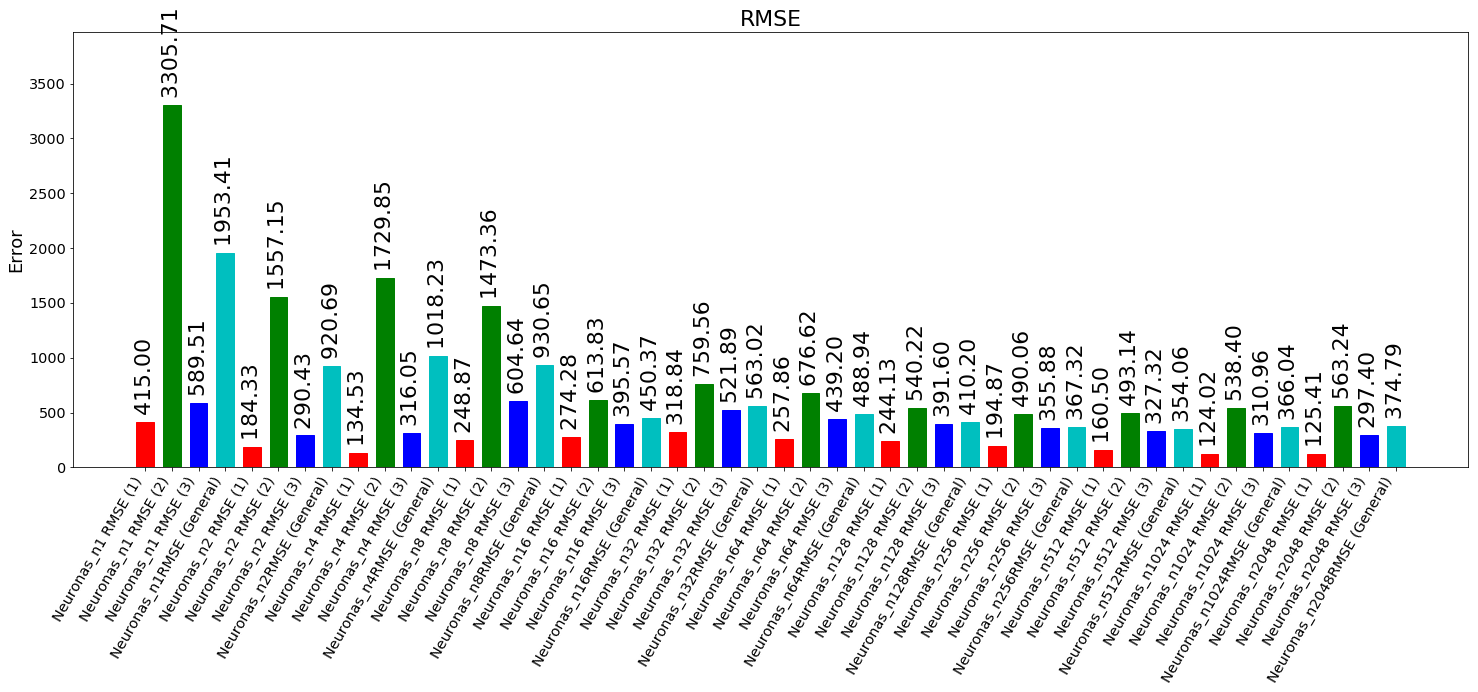

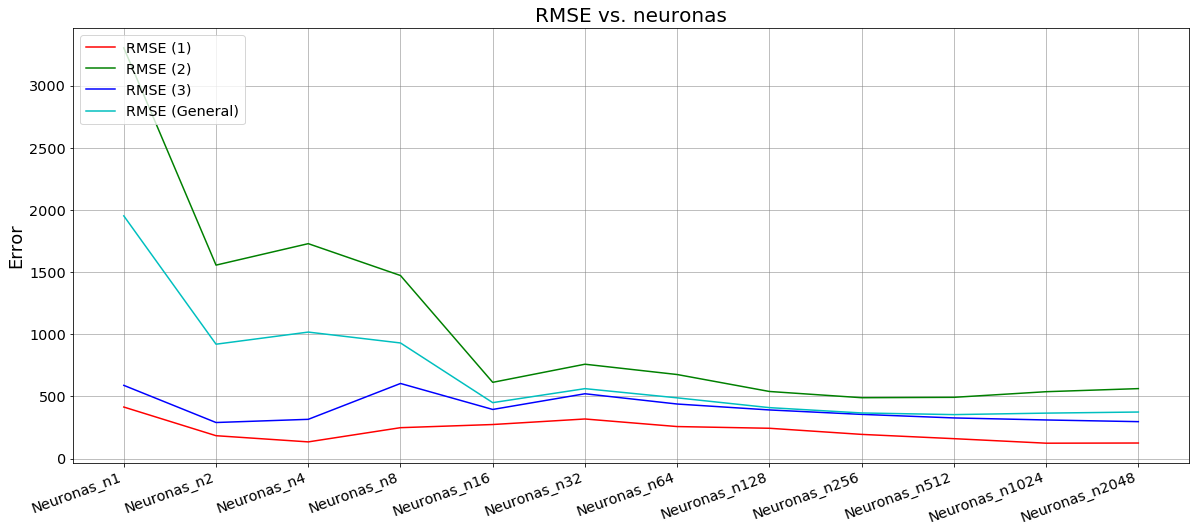

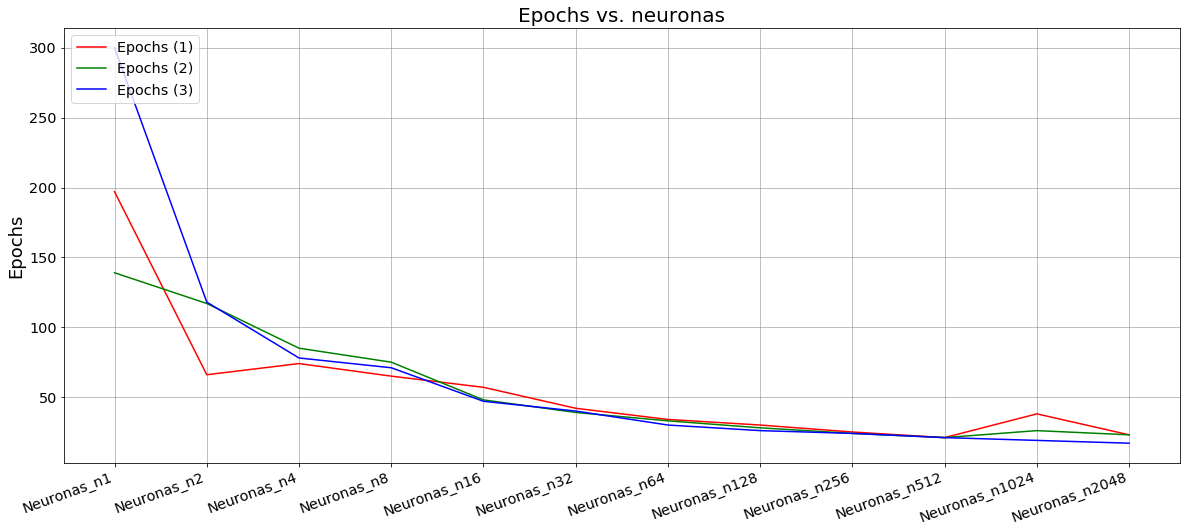

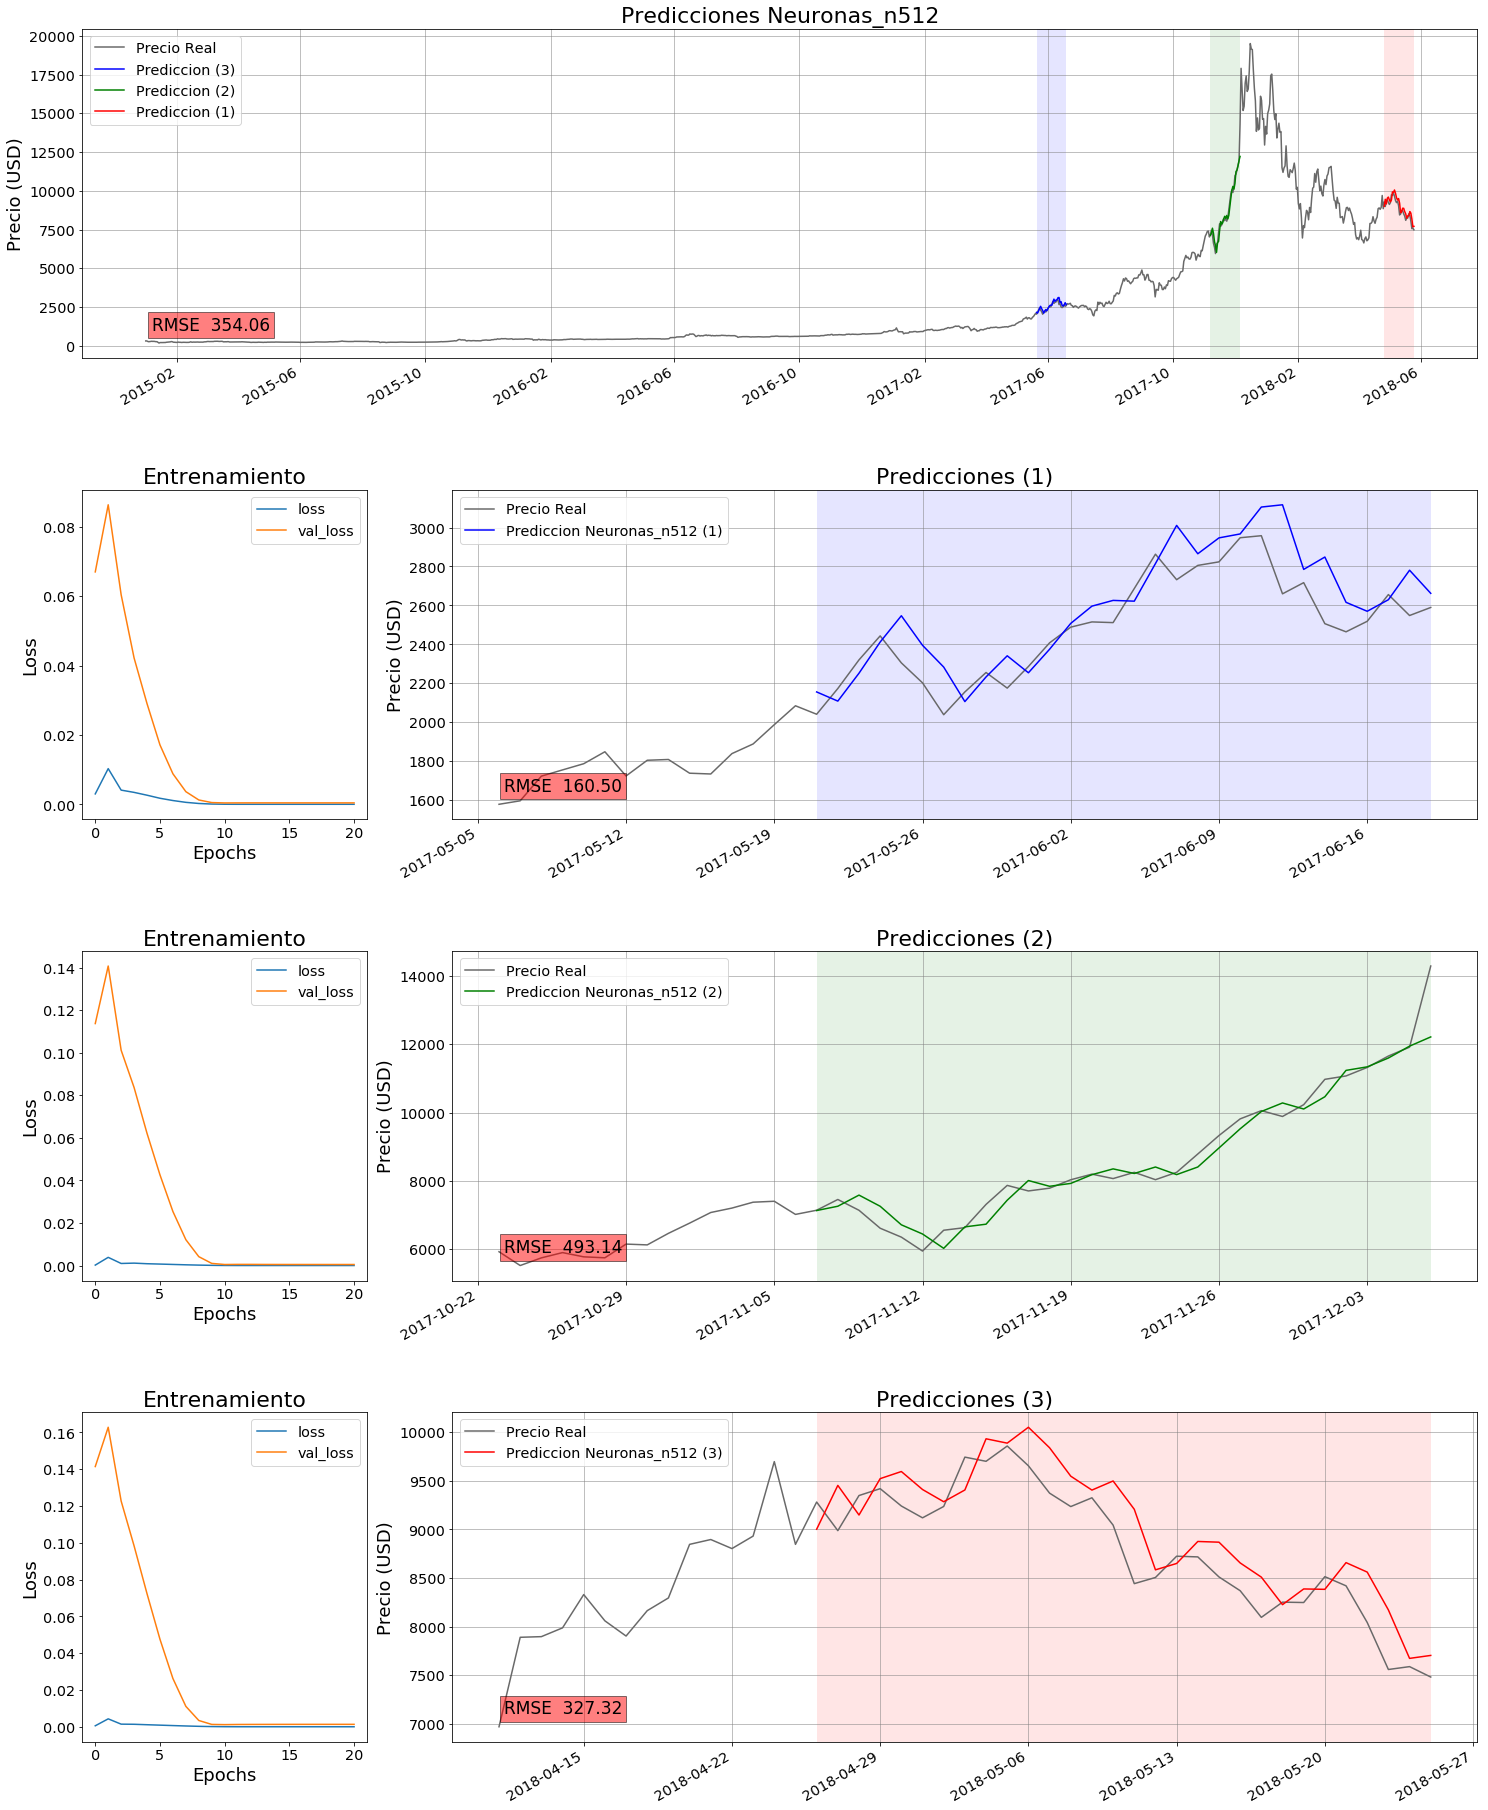

In [18]:
prediccion_neuronas = pd.read_csv(datasetfolder + '/' + 'Neuronas' + '.csv')
prediccion_neuronas['Date'] = pd.to_datetime(prediccion_neuronas['Date'])
prediccion_neuronas.set_index('Date', inplace=True)

dataframe_rmse, dataframe_epochs = postprocesamiento(prediccion_neuronas,  name='Neuronas', name_parametro='neuronas')
graficarSimulacion(prediccion_neuronas, 'Neuronas_n512', dataframe_rmse, dataframe_epochs, name='Neuronas', name_parametro='neuronas')

In [9]:
data = pd.read_csv('data/data.csv', usecols= ['Date'] + ['Close bitcoin'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[:'2018-05-25']

prediccion_ventana_chica = simulacionVentana(data, [0,1,2,3,4], 512, "Ventana chica")
prediccion_ventana_grande = simulacionVentana(data, [10,13,15,21,50], 512, "Ventana grande")

Train on 696 samples, validate on 174 samples
Epoch 1/300
696/696 [==============================] - 3s 4ms/step - loss: 0.0033 - val_loss: 0.0712
Epoch 2/300
696/696 [==============================] - 2s 2ms/step - loss: 0.0105 - val_loss: 0.0891
Epoch 3/300
696/696 [==============================] - 2s 2ms/step - loss: 0.0043 - val_loss: 0.0627
Epoch 4/300
696/696 [==============================] - 2s 2ms/step - loss: 0.0036 - val_loss: 0.0437
Epoch 5/300
696/696 [==============================] - 2s 2ms/step - loss: 0.0027 - val_loss: 0.0300
Epoch 6/300
696/696 [==============================] - 2s 2ms/step - loss: 0.0018 - val_loss: 0.0176
Epoch 7/300
696/696 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 0.0089
Epoch 8/300
696/696 [==============================] - 2s 2ms/step - loss: 6.0567e-04 - val_loss: 0.0036
Epoch 9/300
696/696 [==============================] - 2s 2ms/step - loss: 2.6890e-04 - val_loss: 0.0012
Epoch 10/300
696/696 [===============

968/968 [==============================] - 2s 2ms/step - loss: 7.6671e-06 - val_loss: 0.0013
Epoch 14/300
968/968 [==============================] - 2s 2ms/step - loss: 6.5725e-06 - val_loss: 0.0013
Epoch 15/300
968/968 [==============================] - 2s 2ms/step - loss: 6.2442e-06 - val_loss: 0.0013
Epoch 16/300
968/968 [==============================] - 2s 2ms/step - loss: 6.0960e-06 - val_loss: 0.0013
Epoch 17/300
968/968 [==============================] - 2s 2ms/step - loss: 6.0214e-06 - val_loss: 0.0013
Epoch 18/300
968/968 [==============================] - 2s 2ms/step - loss: 5.9819e-06 - val_loss: 0.0013
Epoch 19/300
968/968 [==============================] - 2s 2ms/step - loss: 5.9597e-06 - val_loss: 0.0013
Epoch 20/300
968/968 [==============================] - 2s 2ms/step - loss: 5.9464e-06 - val_loss: 0.0013
Epoch 21/300
968/968 [==============================] - 2s 2ms/step - loss: 5.9381e-06 - val_loss: 0.0013
Epoch 00021: early stopping
Entrenamiento Ventana chica_v0(

Train on 693 samples, validate on 174 samples
Epoch 1/300
693/693 [==============================] - 5s 7ms/step - loss: 0.0012 - val_loss: 0.0253
Epoch 2/300
693/693 [==============================] - 3s 4ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 3/300
693/693 [==============================] - 3s 4ms/step - loss: 0.0061 - val_loss: 0.0022
Epoch 4/300
693/693 [==============================] - 2s 4ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 5/300
693/693 [==============================] - 3s 4ms/step - loss: 4.0377e-04 - val_loss: 0.0014
Epoch 6/300
693/693 [==============================] - 3s 4ms/step - loss: 1.6800e-04 - val_loss: 0.0017
Epoch 7/300
693/693 [==============================] - 3s 4ms/step - loss: 9.6804e-05 - val_loss: 0.0011
Epoch 8/300
693/693 [==============================] - 3s 4ms/step - loss: 9.9501e-05 - val_loss: 0.0013
Epoch 9/300
693/693 [==============================] - 2s 4ms/step - loss: 9.2614e-05 - val_loss: 0.0011
Epoch 10/300
693/693 [===

692/692 [==============================] - 3s 4ms/step - loss: 1.2333e-04 - val_loss: 0.0013
Epoch 9/300
692/692 [==============================] - 3s 4ms/step - loss: 1.2085e-04 - val_loss: 0.0018
Epoch 10/300
692/692 [==============================] - 3s 4ms/step - loss: 1.1925e-04 - val_loss: 0.0013
Epoch 11/300
692/692 [==============================] - 3s 4ms/step - loss: 1.2291e-04 - val_loss: 0.0015
Epoch 12/300
692/692 [==============================] - 3s 4ms/step - loss: 1.1869e-04 - val_loss: 0.0012
Epoch 13/300
692/692 [==============================] - 3s 4ms/step - loss: 1.3892e-04 - val_loss: 0.0012
Epoch 14/300
692/692 [==============================] - 3s 4ms/step - loss: 1.2452e-04 - val_loss: 0.0010
Epoch 15/300
692/692 [==============================] - 3s 4ms/step - loss: 1.7560e-04 - val_loss: 9.9141e-04
Epoch 16/300
692/692 [==============================] - 3s 4ms/step - loss: 1.4502e-04 - val_loss: 0.0010
Epoch 17/300
692/692 [==============================] - 

Train on 688 samples, validate on 172 samples
Epoch 1/300
688/688 [==============================] - 8s 11ms/step - loss: 9.4845e-04 - val_loss: 0.0100
Epoch 2/300
688/688 [==============================] - 5s 7ms/step - loss: 0.0014 - val_loss: 0.0246
Epoch 3/300
688/688 [==============================] - 5s 7ms/step - loss: 0.0026 - val_loss: 0.0249
Epoch 4/300
688/688 [==============================] - 5s 7ms/step - loss: 0.0029 - val_loss: 0.0185
Epoch 5/300
688/688 [==============================] - 5s 7ms/step - loss: 0.0031 - val_loss: 0.0061
Epoch 6/300
688/688 [==============================] - 5s 7ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 7/300
688/688 [==============================] - 5s 7ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 8/300
688/688 [==============================] - 6s 8ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 9/300
688/688 [==============================] - 5s 8ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 10/300
688/688 [==================

Train on 685 samples, validate on 172 samples
Epoch 1/300
685/685 [==============================] - 9s 13ms/step - loss: 9.8926e-04 - val_loss: 0.0115
Epoch 2/300
685/685 [==============================] - 6s 9ms/step - loss: 0.0015 - val_loss: 0.0236
Epoch 3/300
685/685 [==============================] - 6s 9ms/step - loss: 0.0024 - val_loss: 0.0196
Epoch 4/300
685/685 [==============================] - 6s 9ms/step - loss: 0.0024 - val_loss: 0.0183
Epoch 5/300
685/685 [==============================] - 6s 9ms/step - loss: 0.0025 - val_loss: 0.0085
Epoch 6/300
685/685 [==============================] - 6s 9ms/step - loss: 0.0026 - val_loss: 0.0091
Epoch 7/300
685/685 [==============================] - 6s 9ms/step - loss: 0.0026 - val_loss: 0.0080
Epoch 8/300
685/685 [==============================] - 6s 9ms/step - loss: 0.0029 - val_loss: 0.0052
Epoch 9/300
685/685 [==============================] - 6s 9ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/300
685/685 [==================

820/820 [==============================] - 9s 10ms/step - loss: 2.1790e-04 - val_loss: 0.0021
Epoch 16/300
820/820 [==============================] - 8s 10ms/step - loss: 1.4532e-05 - val_loss: 7.9823e-04
Epoch 17/300
820/820 [==============================] - 8s 10ms/step - loss: 1.2375e-05 - val_loss: 8.3694e-04
Epoch 18/300
820/820 [==============================] - 8s 10ms/step - loss: 1.4004e-05 - val_loss: 0.0010
Epoch 19/300
820/820 [==============================] - 10s 13ms/step - loss: 1.7658e-05 - val_loss: 9.3666e-04
Epoch 20/300
820/820 [==============================] - 9s 11ms/step - loss: 2.3082e-05 - val_loss: 0.0021
Epoch 21/300
820/820 [==============================] - 8s 10ms/step - loss: 4.9170e-05 - val_loss: 0.0011
Epoch 22/300
820/820 [==============================] - 8s 10ms/step - loss: 5.8647e-05 - val_loss: 0.0073
Epoch 23/300
820/820 [==============================] - 8s 10ms/step - loss: 1.4647e-04 - val_loss: 0.0012
Epoch 24/300
820/820 [===============

Train on 815 samples, validate on 204 samples
Epoch 1/300
815/815 [==============================] - 15s 18ms/step - loss: 1.4063e-04 - val_loss: 0.0486
Epoch 2/300
815/815 [==============================] - 11s 13ms/step - loss: 8.7953e-04 - val_loss: 0.0659
Epoch 3/300
815/815 [==============================] - 11s 14ms/step - loss: 0.0018 - val_loss: 0.1087
Epoch 4/300
815/815 [==============================] - 11s 13ms/step - loss: 0.0014 - val_loss: 0.0711
Epoch 5/300
815/815 [==============================] - 11s 13ms/step - loss: 0.0016 - val_loss: 0.0656
Epoch 6/300
815/815 [==============================] - 11s 13ms/step - loss: 0.0019 - val_loss: 0.1017
Epoch 7/300
815/815 [==============================] - 11s 14ms/step - loss: 0.0014 - val_loss: 0.0877
Epoch 8/300
815/815 [==============================] - 11s 13ms/step - loss: 8.8093e-04 - val_loss: 0.0441
Epoch 9/300
815/815 [==============================] - 11s 13ms/step - loss: 3.6776e-04 - val_loss: 0.0043
Epoch 10/30

Epoch 6/300
656/656 [==============================] - 19s 30ms/step - loss: 3.8936e-04 - val_loss: 0.0034
Epoch 7/300
656/656 [==============================] - 19s 29ms/step - loss: 4.4524e-04 - val_loss: 0.0032
Epoch 8/300
656/656 [==============================] - 19s 29ms/step - loss: 6.4989e-04 - val_loss: 0.0066
Epoch 9/300
656/656 [==============================] - 19s 29ms/step - loss: 7.0158e-04 - val_loss: 0.0061
Epoch 10/300
656/656 [==============================] - 19s 30ms/step - loss: 8.7469e-04 - val_loss: 0.0079
Epoch 11/300
656/656 [==============================] - 19s 29ms/step - loss: 8.9708e-04 - val_loss: 0.0047
Epoch 12/300
656/656 [==============================] - 19s 30ms/step - loss: 8.9708e-04 - val_loss: 0.0093
Epoch 13/300
656/656 [==============================] - 19s 29ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 14/300
656/656 [==============================] - 19s 29ms/step - loss: 9.2912e-04 - val_loss: 0.0076
Epoch 15/300
656/656 [==============

Epoch 43/300
792/792 [==============================] - 22s 28ms/step - loss: 3.6280e-05 - val_loss: 6.9364e-04
Epoch 44/300
792/792 [==============================] - 22s 28ms/step - loss: 1.3276e-05 - val_loss: 0.0019
Epoch 45/300
792/792 [==============================] - 22s 28ms/step - loss: 3.5956e-05 - val_loss: 6.8857e-04
Epoch 46/300
792/792 [==============================] - 22s 28ms/step - loss: 1.2928e-05 - val_loss: 0.0019
Epoch 47/300
792/792 [==============================] - 22s 28ms/step - loss: 3.5646e-05 - val_loss: 6.8576e-04
Epoch 48/300
792/792 [==============================] - 22s 28ms/step - loss: 1.2614e-05 - val_loss: 0.0019
Epoch 49/300
792/792 [==============================] - 22s 28ms/step - loss: 3.5352e-05 - val_loss: 6.8498e-04
Epoch 50/300
792/792 [==============================] - 22s 28ms/step - loss: 1.2330e-05 - val_loss: 0.0019
Epoch 51/300
792/792 [==============================] - 22s 28ms/step - loss: 3.5058e-05 - val_loss: 6.8612e-04
Epoch 52

RMSEs guardados: predicciones/Close bitcoin/Close bitcoin Ventana chica_rmses.csv
Epochs guardados: predicciones/Close bitcoin/Close bitcoin Ventana chica_rmses.csv


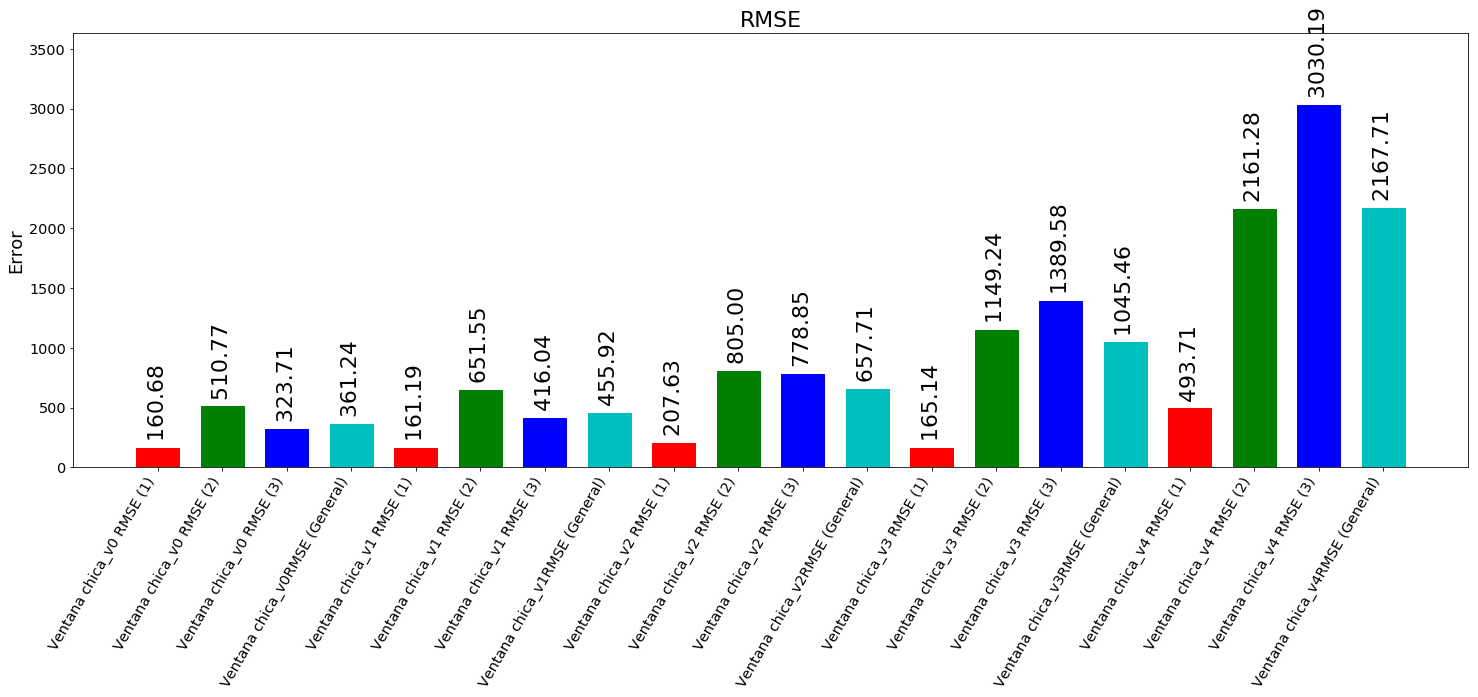

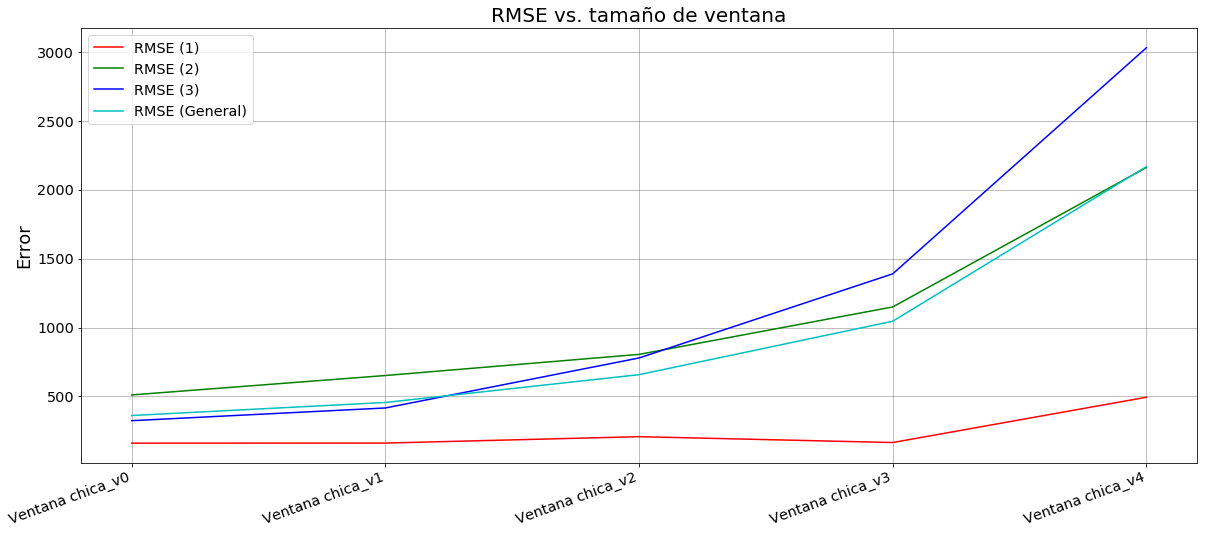

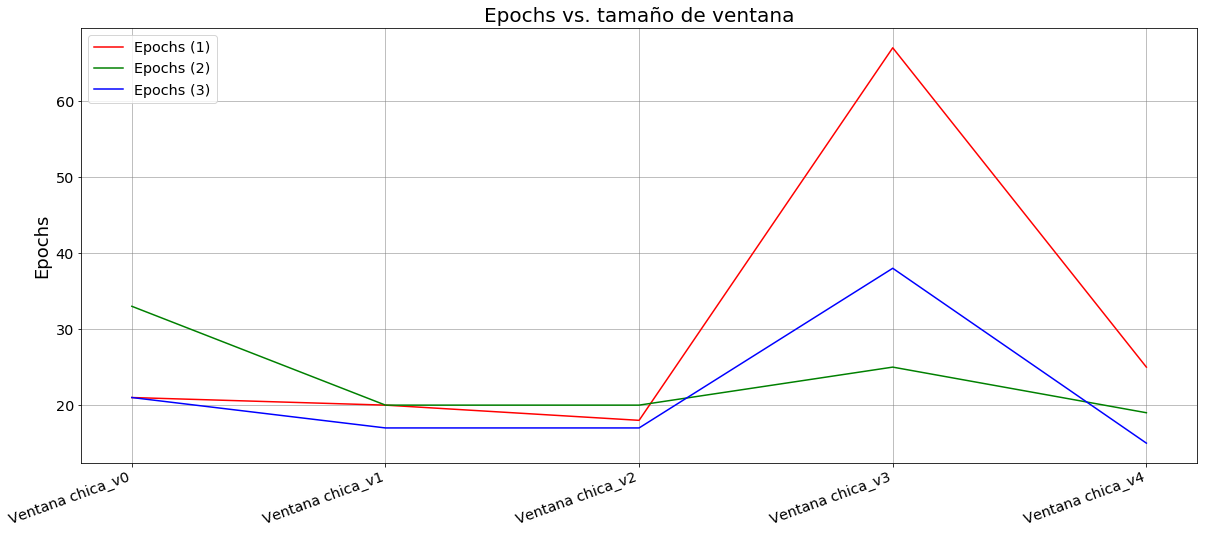

RMSEs guardados: predicciones/Close bitcoin/Close bitcoin Ventana grande_rmses.csv
Epochs guardados: predicciones/Close bitcoin/Close bitcoin Ventana grande_rmses.csv


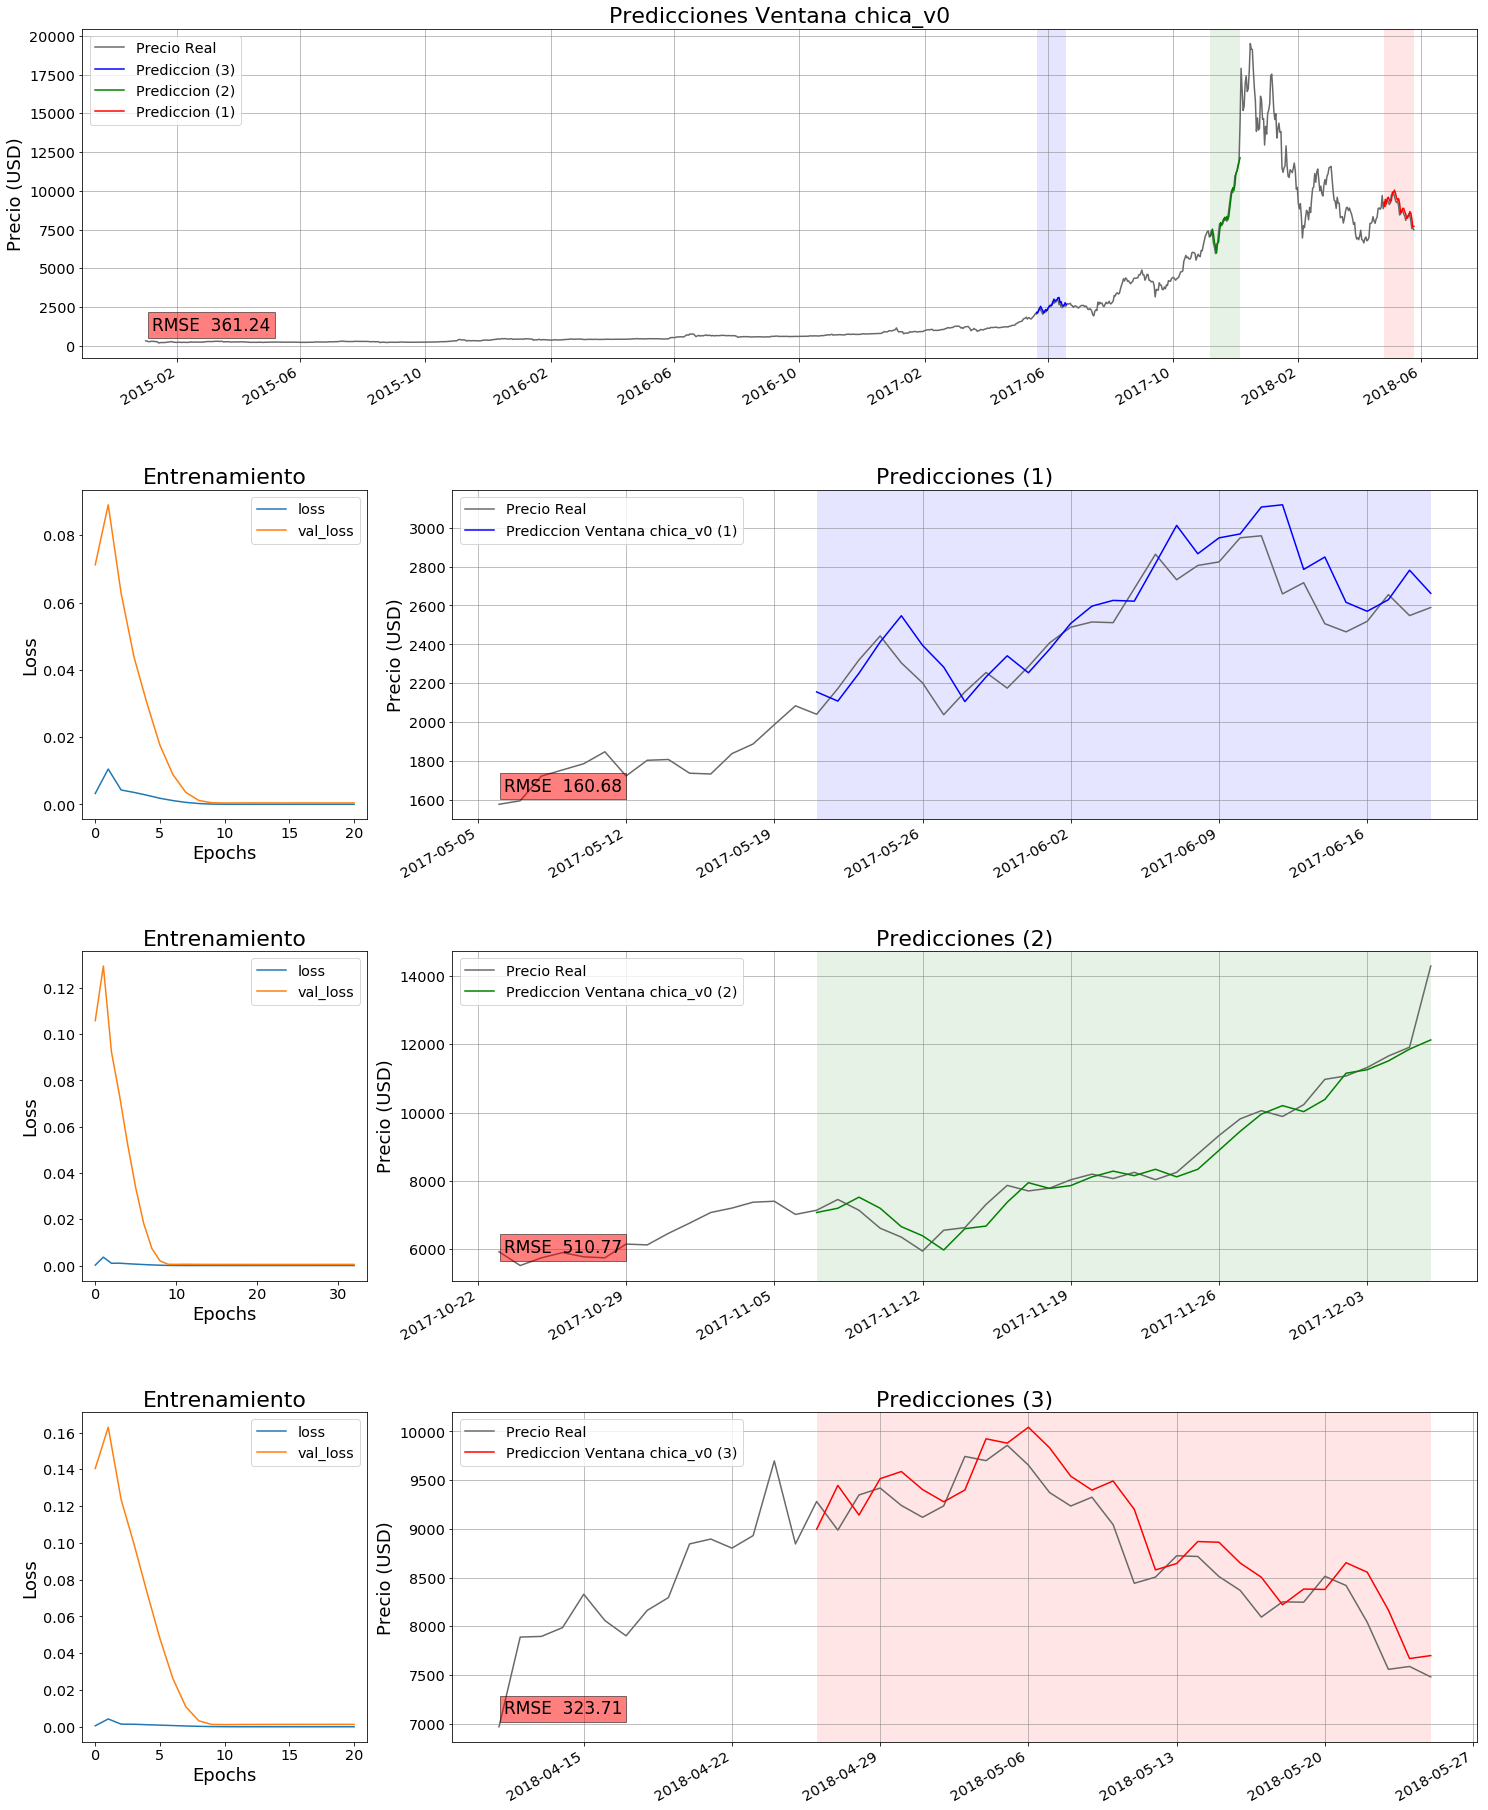

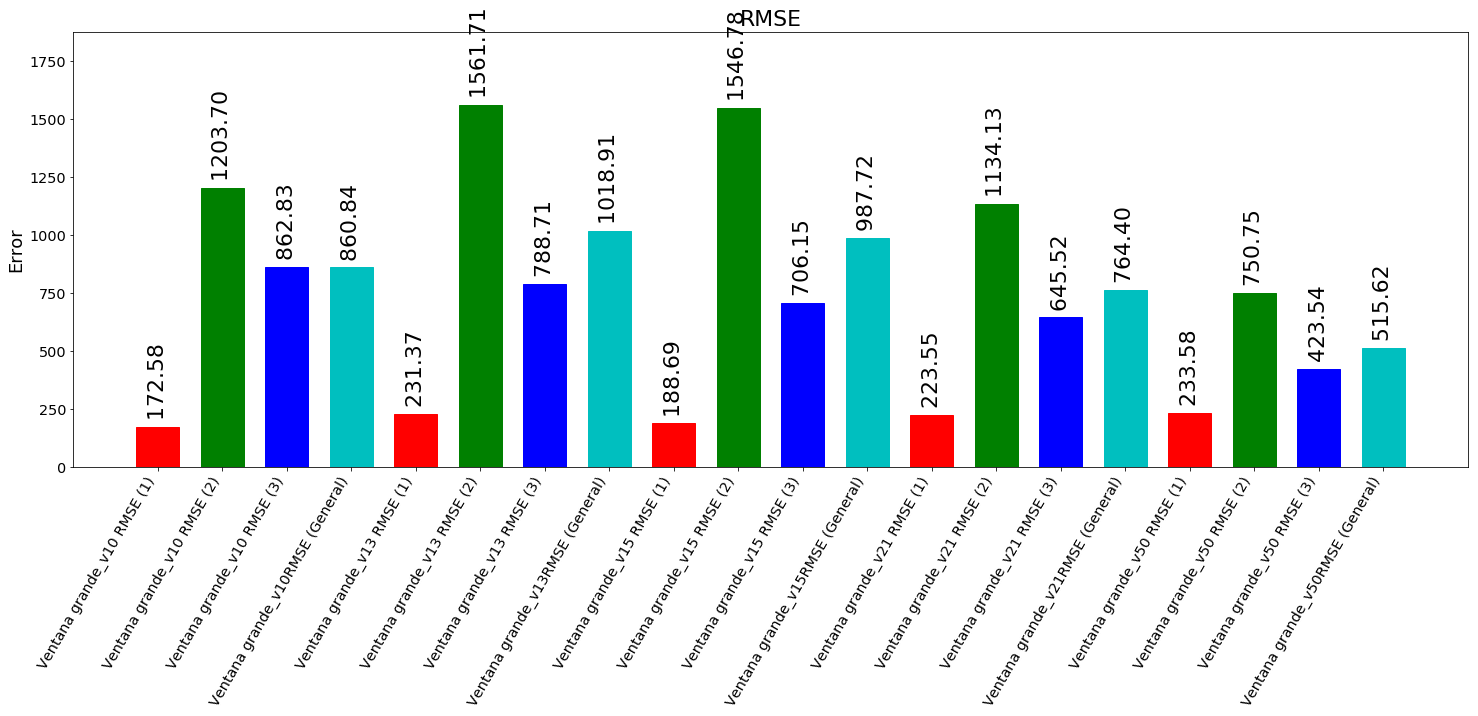

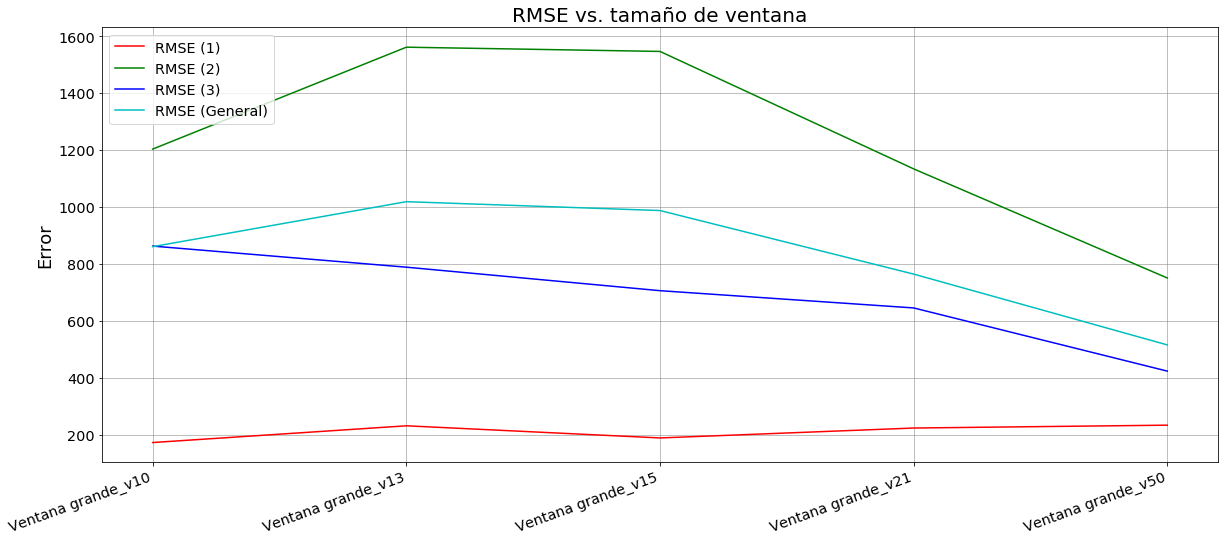

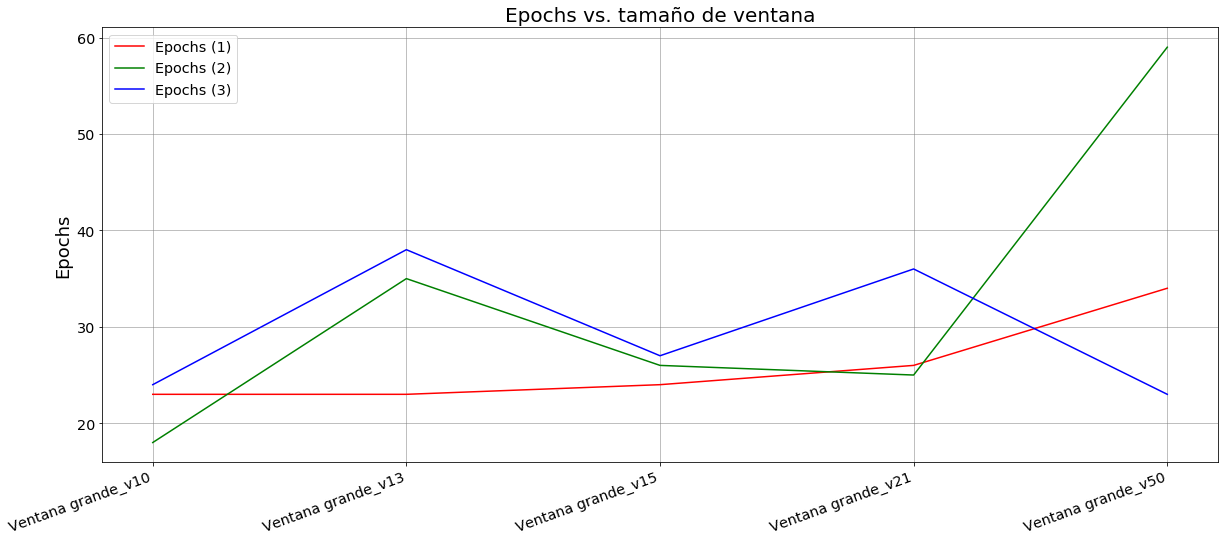

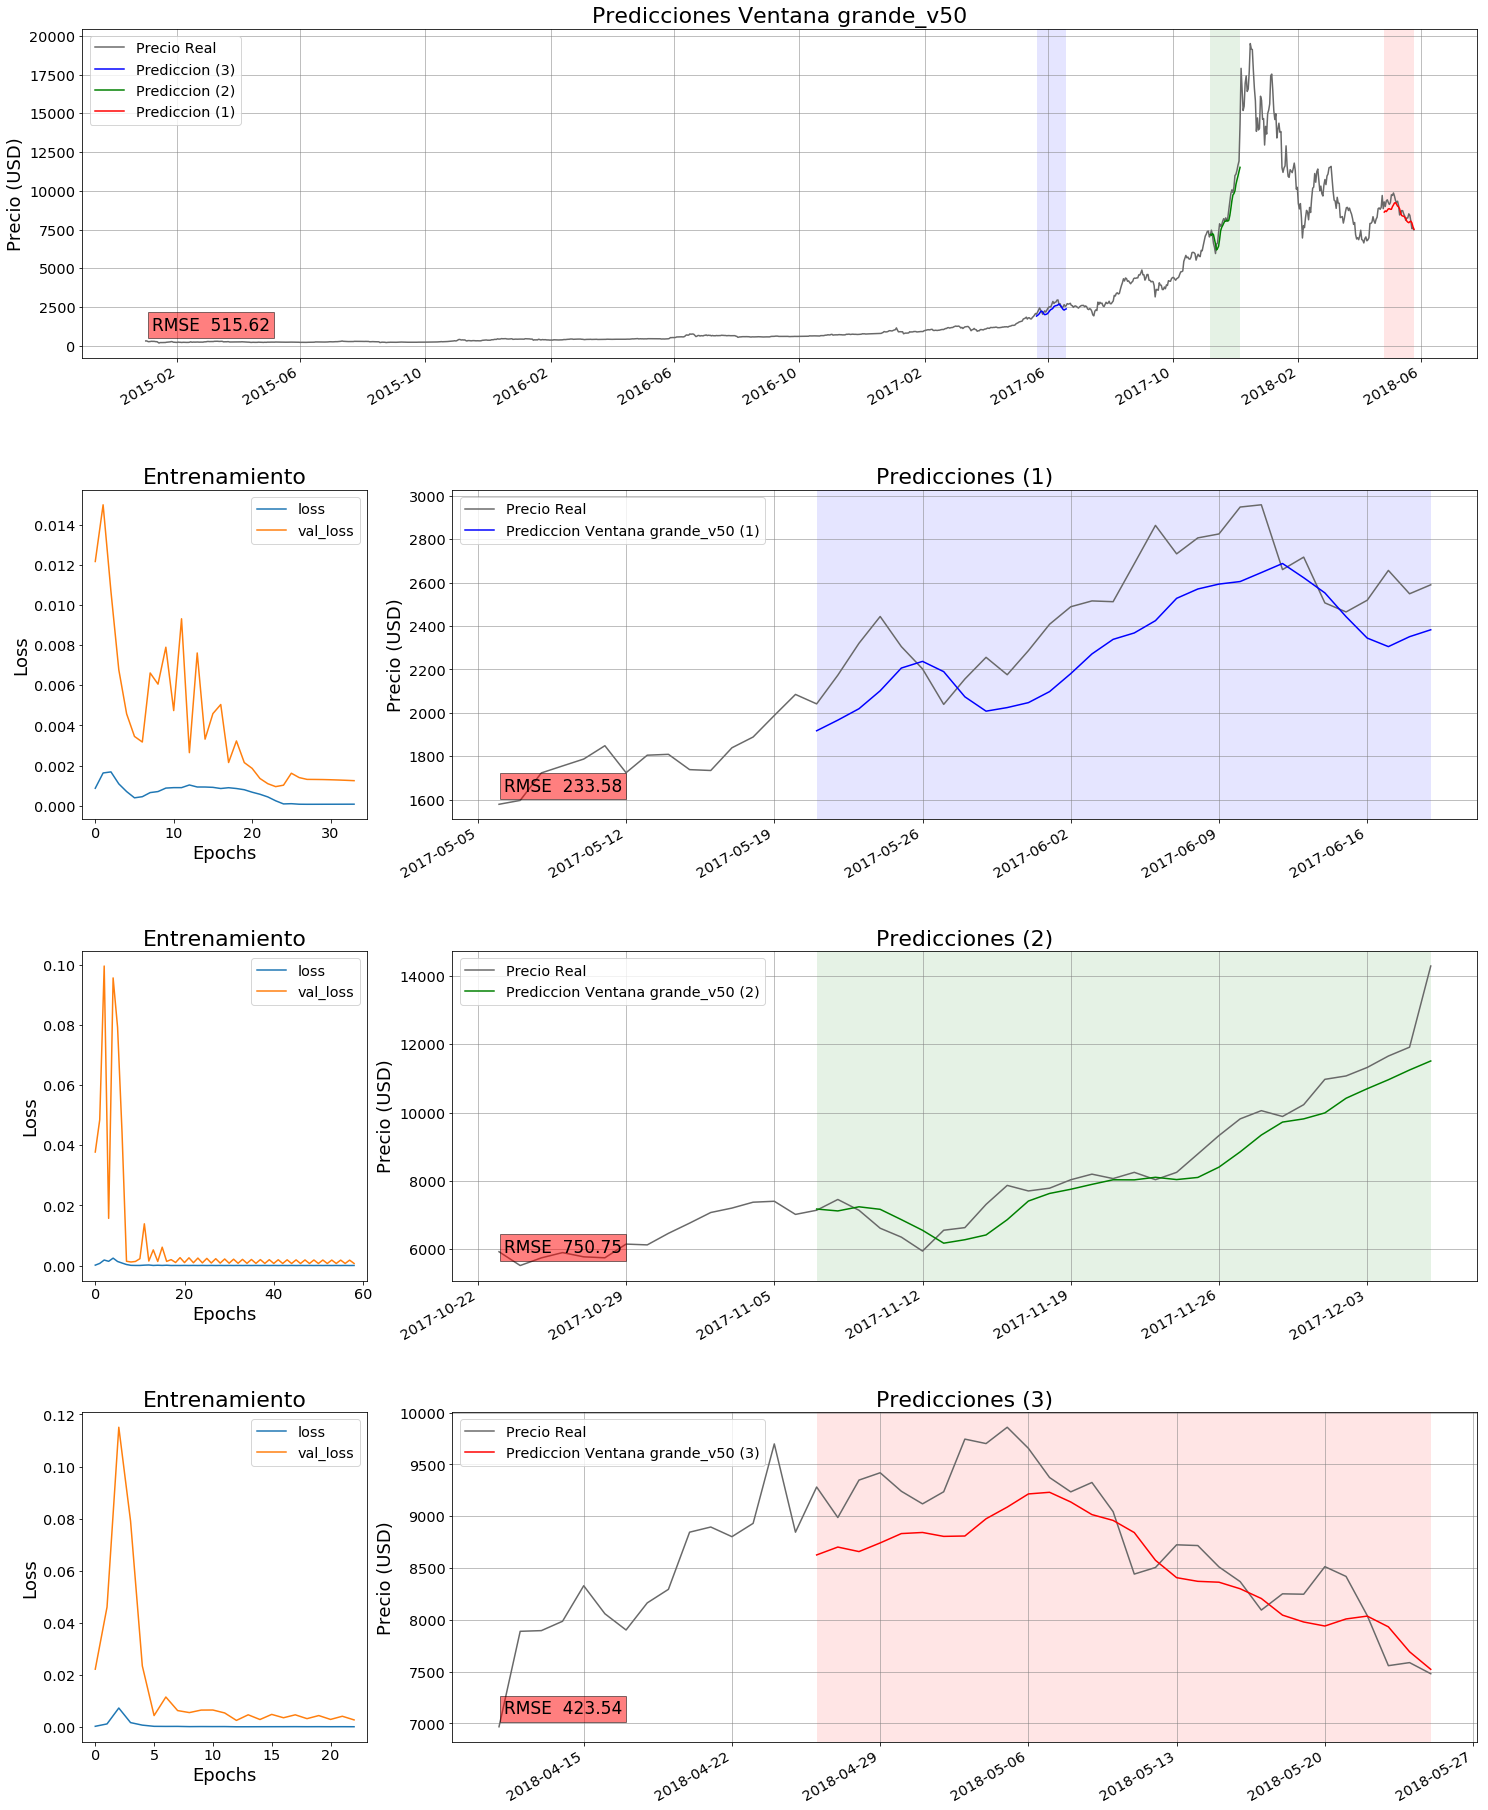

In [19]:
prediccion_ventana_chica = pd.read_csv(datasetfolder + '/' + 'Ventana chica' + '.csv')
prediccion_ventana_chica['Date'] = pd.to_datetime(prediccion_ventana_chica['Date'])
prediccion_ventana_chica.set_index('Date', inplace=True)

dataframe_rmse, dataframe_epochs = postprocesamiento(prediccion_ventana_chica,  name='Ventana chica', name_parametro='tamaño de ventana')
graficarSimulacion(prediccion_ventana_chica, 'Ventana chica_v0', dataframe_rmse, dataframe_epochs, name='Ventana chica', name_parametro='tamaño de ventana')

prediccion_ventana_grande = pd.read_csv(datasetfolder + '/' + 'Ventana grande' + '.csv')
prediccion_ventana_grande['Date'] = pd.to_datetime(prediccion_ventana_grande['Date'])
prediccion_ventana_grande.set_index('Date', inplace=True)

dataframe_rmse, dataframe_epochs = postprocesamiento(prediccion_ventana_grande,  name='Ventana grande', name_parametro='tamaño de ventana')
graficarSimulacion(prediccion_ventana_grande, 'Ventana grande_v50', dataframe_rmse, dataframe_epochs, name='Ventana grande', name_parametro='tamaño de ventana')


In [6]:
data = pd.read_csv('data/data.csv', usecols= ['Date'] + ['Close bitcoin'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[:'2018-05-25']

prediccion_extra_grande = simulacionVentana(data, [60,70,90,120], 512, "Ventana extra grande")

Train on 648 samples, validate on 162 samples
Epoch 1/300
648/648 [==============================] - 21s 32ms/step - loss: 9.4432e-04 - val_loss: 0.0092
Epoch 2/300
648/648 [==============================] - 20s 31ms/step - loss: 0.0016 - val_loss: 0.0075
Epoch 3/300
648/648 [==============================] - 20s 30ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 4/300
648/648 [==============================] - 19s 29ms/step - loss: 8.5148e-04 - val_loss: 0.0013
Epoch 5/300
648/648 [==============================] - 19s 29ms/step - loss: 3.5178e-04 - val_loss: 0.0030
Epoch 6/300
648/648 [==============================] - 19s 29ms/step - loss: 4.2003e-04 - val_loss: 0.0012
Epoch 7/300
648/648 [==============================] - 19s 29ms/step - loss: 3.1714e-04 - val_loss: 0.0031
Epoch 8/300
648/648 [==============================] - 19s 29ms/step - loss: 6.2551e-04 - val_loss: 0.0050
Epoch 9/300
648/648 [==============================] - 19s 30ms/step - loss: 4.0058e-04 - val_loss: 0.0027

Epoch 20/300
640/640 [==============================] - 21s 33ms/step - loss: 8.1122e-05 - val_loss: 0.0013
Epoch 21/300
640/640 [==============================] - 21s 33ms/step - loss: 8.2750e-05 - val_loss: 0.0013
Epoch 22/300
640/640 [==============================] - 21s 32ms/step - loss: 8.4765e-05 - val_loss: 0.0012
Epoch 00022: early stopping
Entrenamiento Ventana extra grande_v70(3) completo.
[[1913.0399]
 [1980.0686]
 [2041.0795]
 [2120.216 ]
 [2219.7866]
 [2273.9802]
 [2257.3113]
 [2167.9595]
 [2087.3596]
 [2067.6006]
 [2074.521 ]
 [2113.2705]
 [2188.911 ]
 [2283.2585]
 [2366.3018]
 [2416.928 ]
 [2473.5327]
 [2563.9326]
 [2622.9949]
 [2657.3098]
 [2676.3872]
 [2710.8647]
 [2751.2332]
 [2717.159 ]
 [2654.649 ]
 [2554.5862]
 [2447.7854]
 [2381.5164]
 [2390.8303]
 [2418.7004]]
Train on 776 samples, validate on 194 samples
Epoch 1/300
776/776 [==============================] - 27s 35ms/step - loss: 1.5325e-04 - val_loss: 0.0430
Epoch 2/300
776/776 [==============================]

896/896 [==============================] - 38s 43ms/step - loss: 3.7648e-05 - val_loss: 0.0033
Epoch 26/300
896/896 [==============================] - 38s 43ms/step - loss: 5.2431e-05 - val_loss: 0.0032
Epoch 27/300
896/896 [==============================] - 39s 44ms/step - loss: 3.5340e-05 - val_loss: 0.0032
Epoch 28/300
896/896 [==============================] - 39s 43ms/step - loss: 4.9499e-05 - val_loss: 0.0030
Epoch 29/300
896/896 [==============================] - 39s 43ms/step - loss: 3.3687e-05 - val_loss: 0.0031
Epoch 30/300
896/896 [==============================] - 39s 44ms/step - loss: 4.7510e-05 - val_loss: 0.0029
Epoch 31/300
896/896 [==============================] - 39s 43ms/step - loss: 3.2480e-05 - val_loss: 0.0030
Epoch 32/300
896/896 [==============================] - 39s 44ms/step - loss: 4.6117e-05 - val_loss: 0.0028
Epoch 33/300
896/896 [==============================] - 38s 43ms/step - loss: 3.1547e-05 - val_loss: 0.0030
Epoch 34/300
896/896 [===================

Epoch 101/300
896/896 [==============================] - 38s 43ms/step - loss: 2.5918e-05 - val_loss: 0.0023
Epoch 102/300
896/896 [==============================] - 39s 43ms/step - loss: 3.8971e-05 - val_loss: 0.0017
Epoch 103/300
896/896 [==============================] - 38s 43ms/step - loss: 2.6065e-05 - val_loss: 0.0022
Epoch 104/300
896/896 [==============================] - 38s 43ms/step - loss: 3.9122e-05 - val_loss: 0.0017
Epoch 105/300
896/896 [==============================] - 39s 43ms/step - loss: 2.6219e-05 - val_loss: 0.0022
Epoch 106/300
896/896 [==============================] - 38s 43ms/step - loss: 3.9280e-05 - val_loss: 0.0017
Epoch 107/300
896/896 [==============================] - 38s 43ms/step - loss: 2.6380e-05 - val_loss: 0.0022
Epoch 108/300
896/896 [==============================] - 39s 44ms/step - loss: 3.9443e-05 - val_loss: 0.0017
Epoch 109/300
896/896 [==============================] - 38s 43ms/step - loss: 2.6550e-05 - val_loss: 0.0022
Epoch 110/300
896/8

600/600 [==============================] - 34s 57ms/step - loss: 8.5417e-05 - val_loss: 9.3413e-04
Epoch 34/300
600/600 [==============================] - 34s 57ms/step - loss: 8.0885e-05 - val_loss: 9.2343e-04
Epoch 35/300
600/600 [==============================] - 35s 58ms/step - loss: 8.1956e-05 - val_loss: 9.1744e-04
Epoch 36/300
600/600 [==============================] - 35s 58ms/step - loss: 8.0286e-05 - val_loss: 9.0874e-04
Epoch 37/300
600/600 [==============================] - 34s 57ms/step - loss: 7.9673e-05 - val_loss: 9.0188e-04
Epoch 38/300
600/600 [==============================] - 34s 57ms/step - loss: 7.9263e-05 - val_loss: 8.9505e-04
Epoch 39/300
600/600 [==============================] - 35s 58ms/step - loss: 7.8444e-05 - val_loss: 8.8816e-04
Epoch 40/300
600/600 [==============================] - 34s 57ms/step - loss: 7.7931e-05 - val_loss: 8.8181e-04
Epoch 41/300
600/600 [==============================] - 34s 57ms/step - loss: 7.7535e-05 - val_loss: 8.7553e-04
Epoch

Train on 872 samples, validate on 218 samples
Epoch 1/300
872/872 [==============================] - 54s 62ms/step - loss: 2.2579e-04 - val_loss: 0.0298
Epoch 2/300
872/872 [==============================] - 52s 60ms/step - loss: 8.8719e-04 - val_loss: 0.0923
Epoch 3/300
872/872 [==============================] - 52s 60ms/step - loss: 0.0018 - val_loss: 0.0796
Epoch 4/300
872/872 [==============================] - 53s 60ms/step - loss: 0.0027 - val_loss: 0.1246
Epoch 5/300
872/872 [==============================] - 52s 60ms/step - loss: 0.0021 - val_loss: 0.0853
Epoch 6/300
872/872 [==============================] - 53s 61ms/step - loss: 0.0022 - val_loss: 0.0778
Epoch 7/300
872/872 [==============================] - 52s 60ms/step - loss: 0.0015 - val_loss: 0.0391
Epoch 8/300
872/872 [==============================] - 53s 60ms/step - loss: 9.0156e-04 - val_loss: 0.0090
Epoch 9/300
872/872 [==============================] - 52s 60ms/step - loss: 4.6509e-04 - val_loss: 0.0032
Epoch 10/30

RMSEs guardados: predicciones/Close bitcoin/Close bitcoin Ventana extra grande_rmses.csv
Epochs guardados: predicciones/Close bitcoin/Close bitcoin Ventana extra grande_rmses.csv


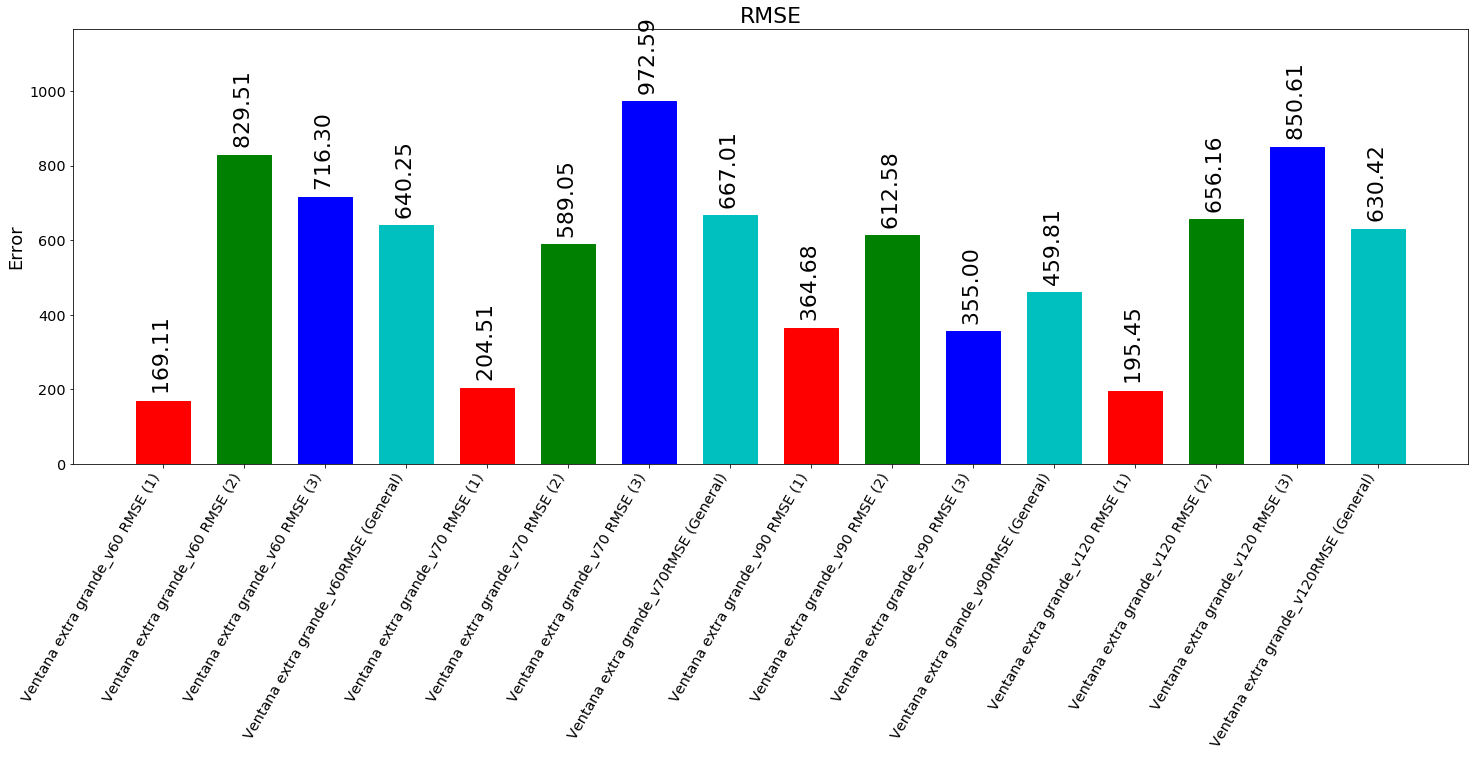

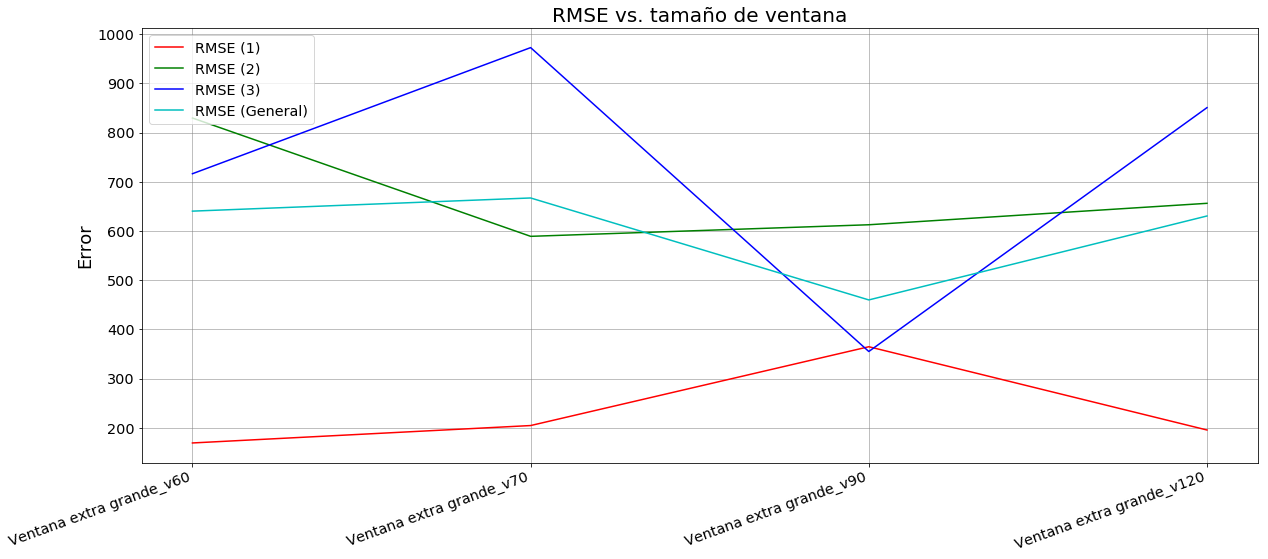

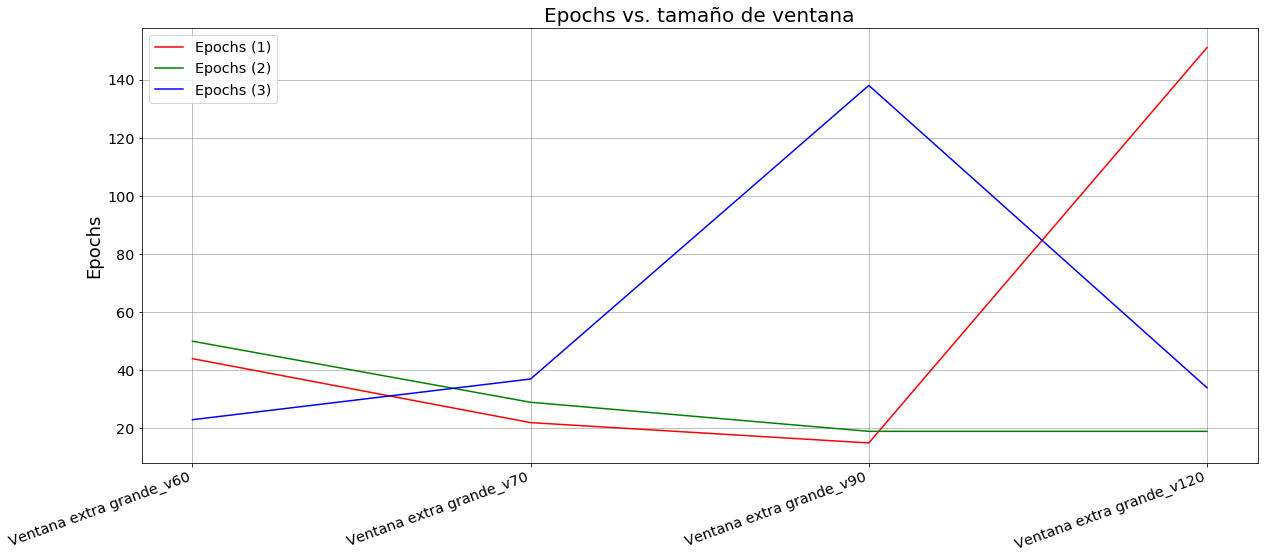

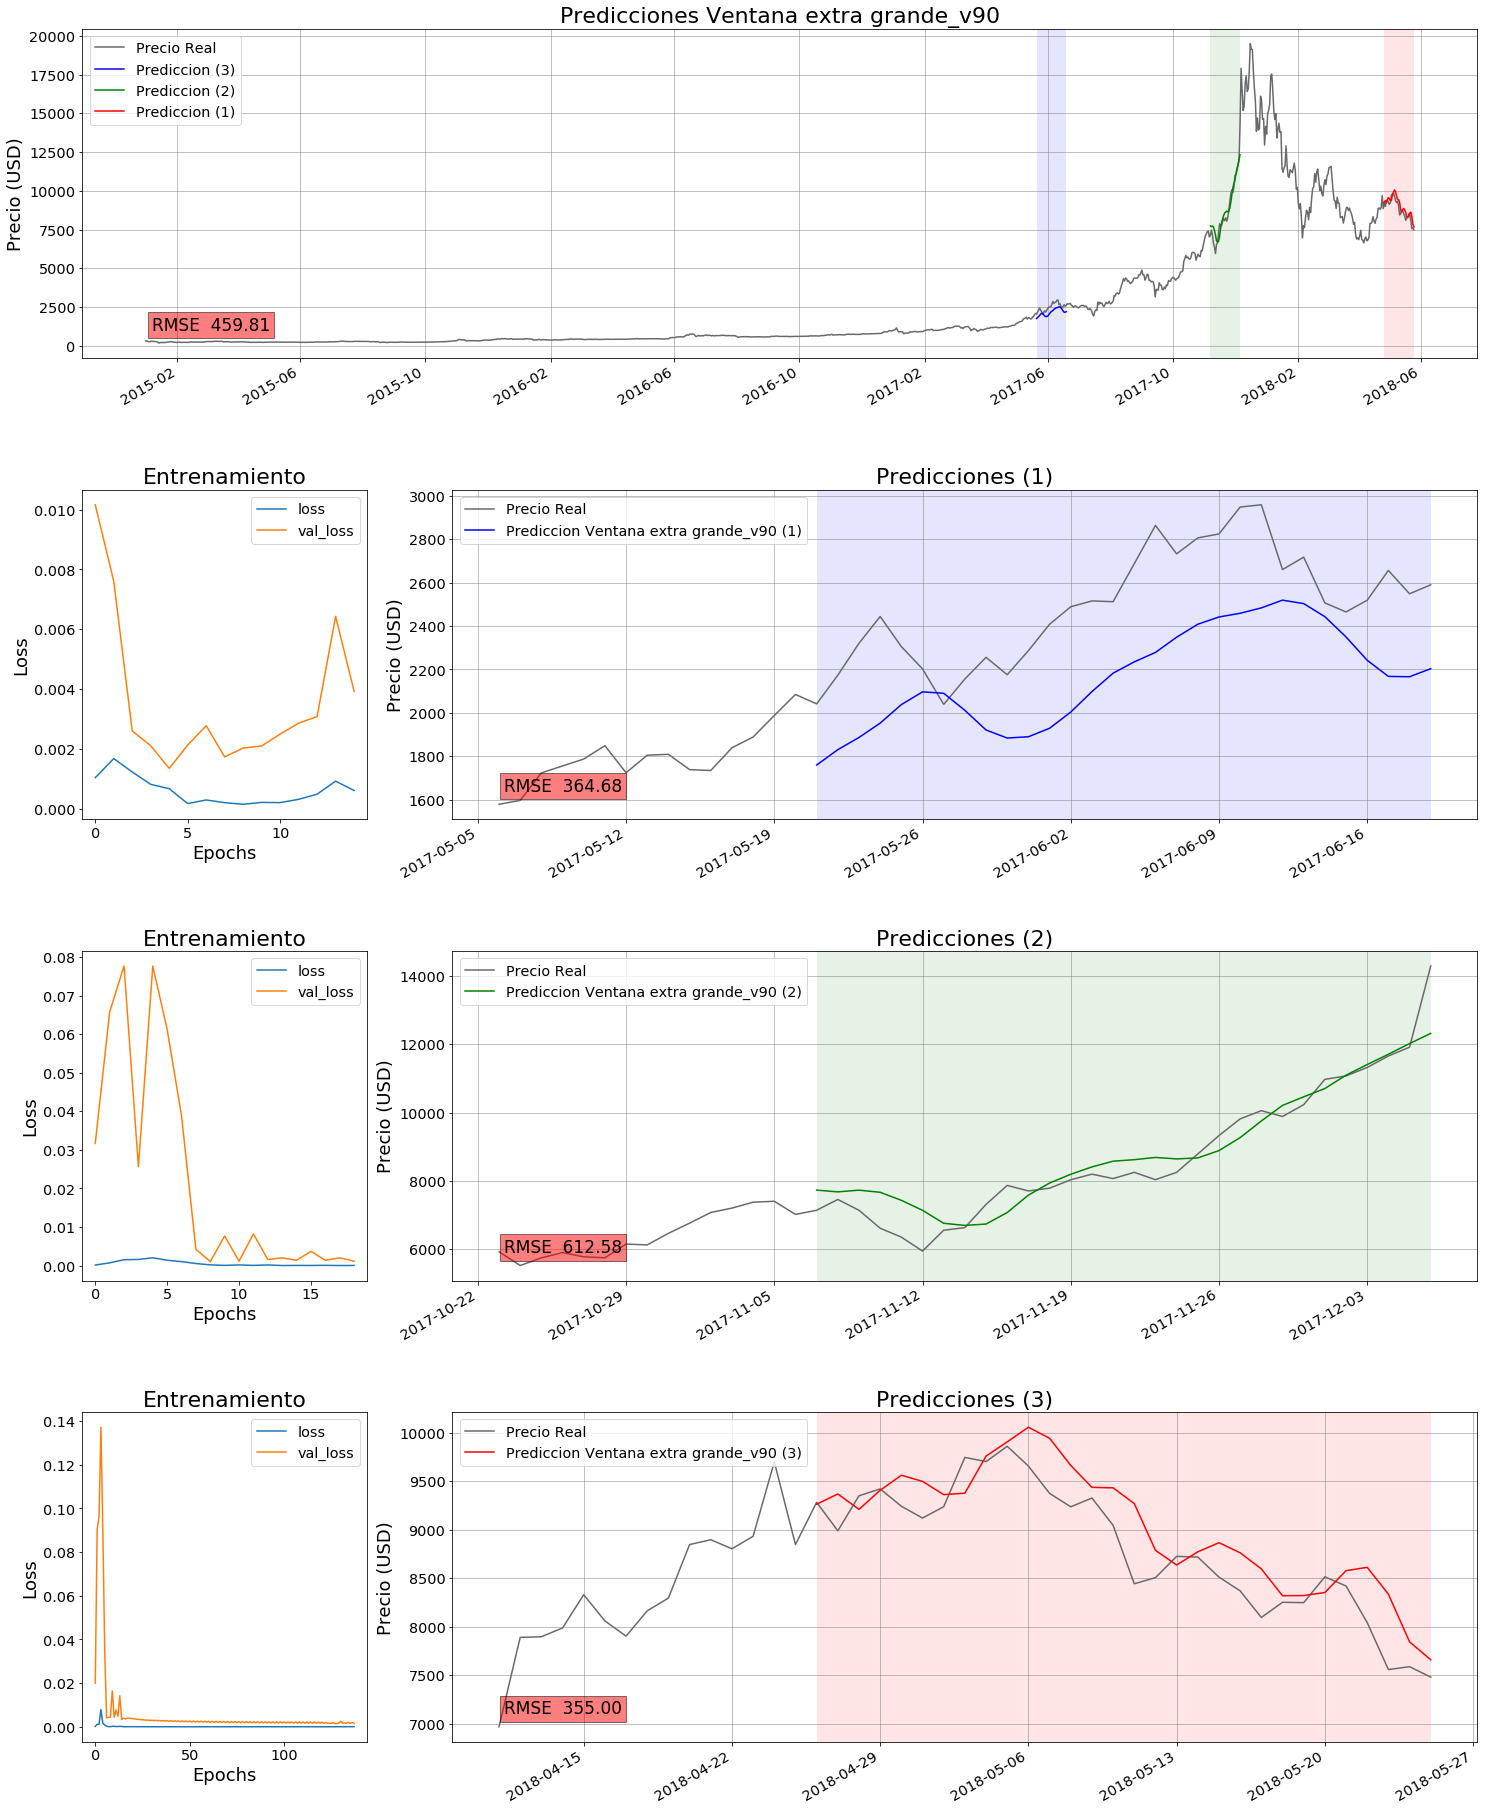

In [20]:
prediccion_extra_grande = pd.read_csv(datasetfolder + '/' + 'Ventana extra grande' + '.csv')
prediccion_extra_grande['Date'] = pd.to_datetime(prediccion_extra_grande['Date'])
prediccion_extra_grande.set_index('Date', inplace=True)

dataframe_rmse, dataframe_epochs = postprocesamiento(prediccion_extra_grande,  name='Ventana extra grande', name_parametro='tamaño de ventana')
graficarSimulacion(prediccion_extra_grande, 'Ventana extra grande_v90', dataframe_rmse, dataframe_epochs, name='Ventana extra grande', name_parametro='tamaño de ventana')

RMSEs guardados: predicciones/Close bitcoin/Close bitcoin Ventanas_rmses.csv
Epochs guardados: predicciones/Close bitcoin/Close bitcoin Ventanas_rmses.csv


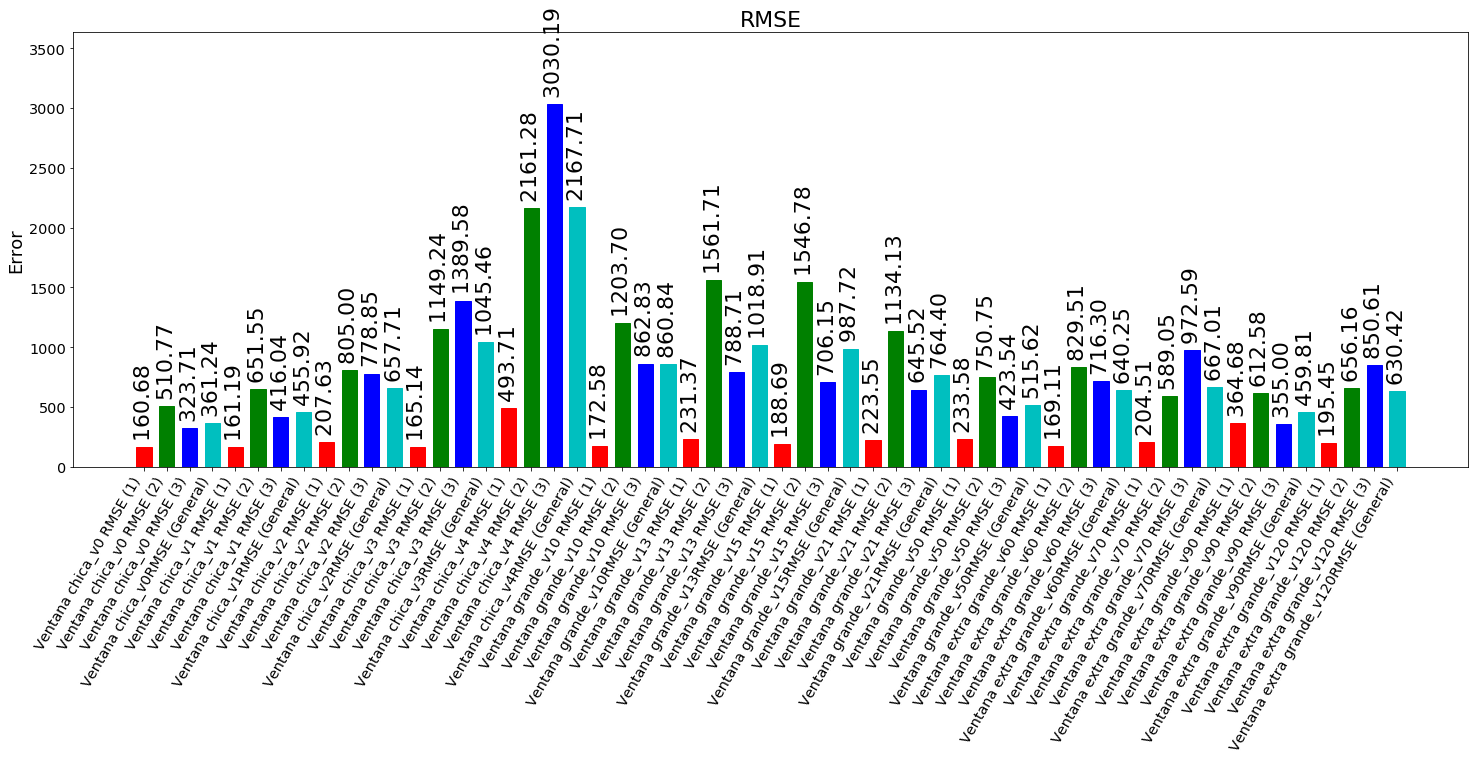

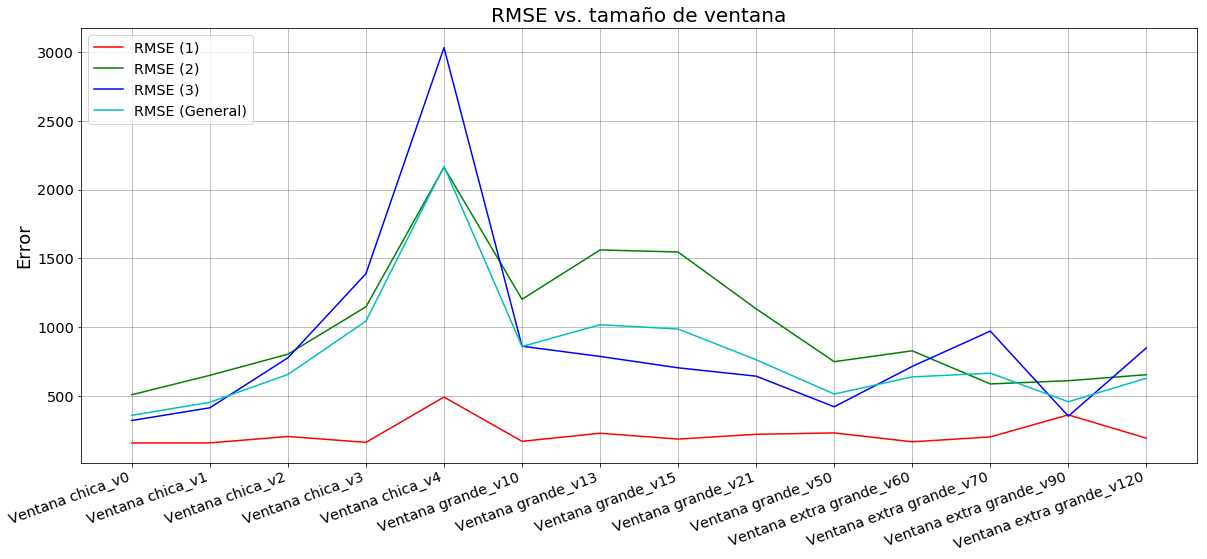

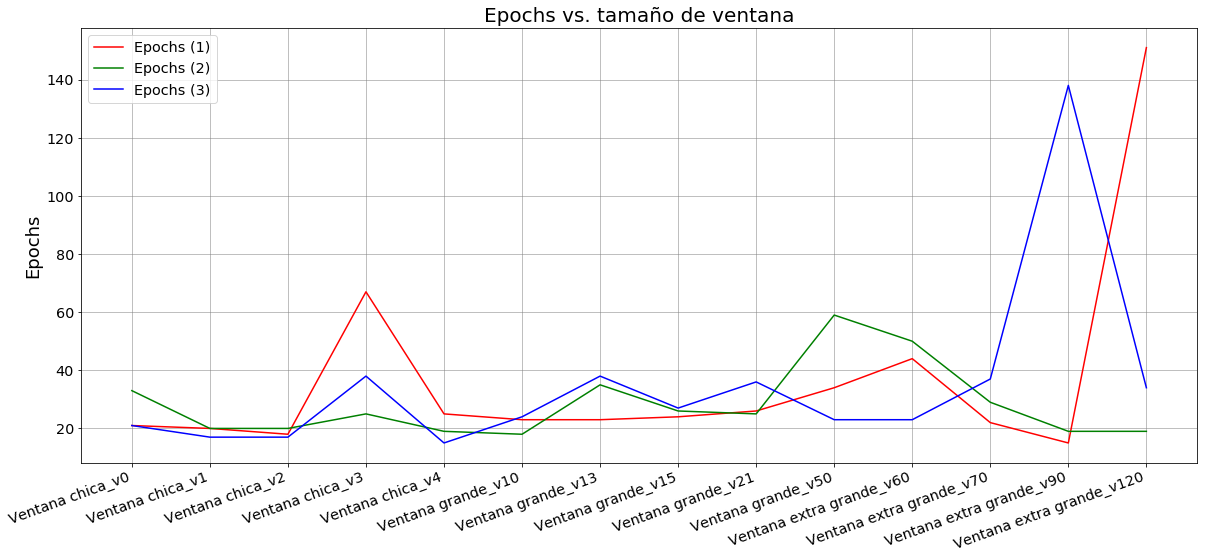

In [21]:
prediccion_ventanas = pd.merge(prediccion_ventana_chica, prediccion_ventana_grande.drop(columns=[target]), left_index=True, right_index=True)
prediccion_ventanas = pd.merge(prediccion_ventanas, prediccion_extra_grande.drop(columns=[target]), left_index=True, right_index=True)
prediccion_ventanas.to_csv(datasetfolder + '/' + 'ventanas' + '.csv')

dataframe_rmse, dataframe_epochs = postprocesamiento(prediccion_ventanas,  name='Ventanas', name_parametro='tamaño de ventana')

In [6]:
# Monedas con > 0.4 de correlacion
criptomonedas_correlacionadas = ['bitcoin','ethereum','litecoin','monero',
                                'dash','ethereum-classic','iota','neo','eos','vechain','qtum','omisego','binance-coin','lisk','zcash']    
cols = ['Close ' + m for m in criptomonedas_correlacionadas]
data = pd.read_csv('data/data.csv', usecols= ['Date'] +  cols)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[:'2018-05-25']


prediccion_variables_cripto = simulacionVariables(data, 512, "Criptos")

Train on 696 samples, validate on 174 samples
Epoch 1/300
696/696 [==============================] - 4s 5ms/step - loss: 0.0140 - val_loss: 0.1829
Epoch 2/300
696/696 [==============================] - 1s 795us/step - loss: 0.0067 - val_loss: 0.1304
Epoch 3/300
696/696 [==============================] - 1s 738us/step - loss: 0.0044 - val_loss: 0.0935
Epoch 4/300
696/696 [==============================] - 1s 721us/step - loss: 0.0048 - val_loss: 0.0724
Epoch 5/300
696/696 [==============================] - 0s 692us/step - loss: 0.0056 - val_loss: 0.0635
Epoch 6/300
696/696 [==============================] - 0s 688us/step - loss: 0.0055 - val_loss: 0.0609
Epoch 7/300
696/696 [==============================] - 1s 744us/step - loss: 0.0048 - val_loss: 0.0600
Epoch 8/300
696/696 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0577
Epoch 9/300
696/696 [==============================] - 1s 721us/step - loss: 0.0036 - val_loss: 0.0531
Epoch 10/300
696/696 [=========

968/968 [==============================] - 1s 652us/step - loss: 1.5348e-05 - val_loss: 0.0020
Epoch 83/300
968/968 [==============================] - 1s 666us/step - loss: 1.4672e-05 - val_loss: 0.0019
Epoch 84/300
968/968 [==============================] - 1s 650us/step - loss: 1.4027e-05 - val_loss: 0.0018
Epoch 85/300
968/968 [==============================] - 1s 652us/step - loss: 1.3411e-05 - val_loss: 0.0017
Epoch 86/300
968/968 [==============================] - 1s 649us/step - loss: 1.2829e-05 - val_loss: 0.0017
Epoch 87/300
968/968 [==============================] - 1s 648us/step - loss: 1.2275e-05 - val_loss: 0.0016
Epoch 88/300
968/968 [==============================] - 1s 645us/step - loss: 1.1753e-05 - val_loss: 0.0016
Epoch 89/300
968/968 [==============================] - 1s 656us/step - loss: 1.1261e-05 - val_loss: 0.0015
Epoch 90/300
968/968 [==============================] - 1s 649us/step - loss: 1.0799e-05 - val_loss: 0.0015
Epoch 91/300
968/968 [===================

832/832 [==============================] - 1s 810us/step - loss: 0.0013 - val_loss: 0.1388
Epoch 3/300
832/832 [==============================] - 1s 762us/step - loss: 0.0015 - val_loss: 0.1268
Epoch 4/300
832/832 [==============================] - 1s 728us/step - loss: 0.0013 - val_loss: 0.1164
Epoch 5/300
832/832 [==============================] - 1s 722us/step - loss: 0.0010 - val_loss: 0.1028
Epoch 6/300
832/832 [==============================] - 1s 665us/step - loss: 8.7314e-04 - val_loss: 0.0875
Epoch 7/300
832/832 [==============================] - 1s 657us/step - loss: 7.9904e-04 - val_loss: 0.0735
Epoch 8/300
832/832 [==============================] - 1s 680us/step - loss: 7.5851e-04 - val_loss: 0.0620
Epoch 9/300
832/832 [==============================] - 1s 661us/step - loss: 7.0063e-04 - val_loss: 0.0524
Epoch 10/300
832/832 [==============================] - 1s 682us/step - loss: 6.2323e-04 - val_loss: 0.0437
Epoch 11/300
832/832 [==============================] - 1s 679us

968/968 [==============================] - 1s 794us/step - loss: 2.7025e-05 - val_loss: 0.0024
Epoch 69/300
968/968 [==============================] - 1s 705us/step - loss: 2.6747e-05 - val_loss: 0.0024
Epoch 70/300
968/968 [==============================] - 1s 671us/step - loss: 2.6467e-05 - val_loss: 0.0024
Epoch 71/300
968/968 [==============================] - 1s 921us/step - loss: 2.6187e-05 - val_loss: 0.0023
Epoch 72/300
968/968 [==============================] - 1s 665us/step - loss: 2.5907e-05 - val_loss: 0.0023
Epoch 73/300
968/968 [==============================] - 1s 883us/step - loss: 2.5626e-05 - val_loss: 0.0023
Epoch 74/300
968/968 [==============================] - 1s 848us/step - loss: 2.5345e-05 - val_loss: 0.0023
Epoch 75/300
968/968 [==============================] - 1s 683us/step - loss: 2.5064e-05 - val_loss: 0.0023
Epoch 76/300
968/968 [==============================] - 1s 891us/step - loss: 2.4782e-05 - val_loss: 0.0022
Epoch 77/300
968/968 [===================

696/696 [==============================] - 1s 887us/step - loss: 4.7486e-04 - val_loss: 0.0048
Epoch 29/300
696/696 [==============================] - 1s 797us/step - loss: 3.9680e-04 - val_loss: 0.0045
Epoch 30/300
696/696 [==============================] - 1s 896us/step - loss: 3.3110e-04 - val_loss: 0.0044
Epoch 31/300
696/696 [==============================] - 1s 965us/step - loss: 2.7686e-04 - val_loss: 0.0044
Epoch 32/300
696/696 [==============================] - 1s 974us/step - loss: 2.3310e-04 - val_loss: 0.0045
Epoch 33/300
696/696 [==============================] - 1s 951us/step - loss: 1.9860e-04 - val_loss: 0.0047
Epoch 34/300
696/696 [==============================] - 1s 874us/step - loss: 1.7190e-04 - val_loss: 0.0050
Epoch 35/300
696/696 [==============================] - 1s 1ms/step - loss: 1.5159e-04 - val_loss: 0.0053
Epoch 36/300
696/696 [==============================] - 1s 890us/step - loss: 1.3641e-04 - val_loss: 0.0056
Epoch 37/300
696/696 [=====================

Epoch 29/300
832/832 [==============================] - 1s 705us/step - loss: 7.7945e-05 - val_loss: 0.0044
Epoch 30/300
832/832 [==============================] - 1s 772us/step - loss: 7.6342e-05 - val_loss: 0.0043
Epoch 31/300
832/832 [==============================] - 1s 818us/step - loss: 7.4750e-05 - val_loss: 0.0042
Epoch 32/300
832/832 [==============================] - 1s 987us/step - loss: 7.3169e-05 - val_loss: 0.0041
Epoch 33/300
832/832 [==============================] - 1s 754us/step - loss: 7.1592e-05 - val_loss: 0.0040
Epoch 34/300
832/832 [==============================] - 1s 754us/step - loss: 7.0011e-05 - val_loss: 0.0040
Epoch 35/300
832/832 [==============================] - 1s 820us/step - loss: 6.8430e-05 - val_loss: 0.0039
Epoch 36/300
832/832 [==============================] - 1s 1ms/step - loss: 6.6849e-05 - val_loss: 0.0038
Epoch 37/300
832/832 [==============================] - 1s 752us/step - loss: 6.5269e-05 - val_loss: 0.0037
Epoch 38/300
832/832 [========

832/832 [==============================] - 1s 1ms/step - loss: 6.9170e-06 - val_loss: 4.8131e-04
Epoch 176/300
832/832 [==============================] - 1s 1ms/step - loss: 6.9171e-06 - val_loss: 4.8131e-04
Epoch 00176: early stopping
Entrenamiento Criptos Close monero(2) completo.
[[ 7083.059 ]
 [ 7208.2754]
 [ 7523.329 ]
 [ 7197.884 ]
 [ 6669.9126]
 [ 6398.451 ]
 [ 5981.994 ]
 [ 6602.1   ]
 [ 6680.2036]
 [ 7372.678 ]
 [ 7939.5244]
 [ 7770.6255]
 [ 7851.1313]
 [ 8102.647 ]
 [ 8266.401 ]
 [ 8131.3657]
 [ 8302.372 ]
 [ 8088.4116]
 [ 8306.225 ]
 [ 8847.427 ]
 [ 9399.665 ]
 [ 9888.889 ]
 [10110.882 ]
 [ 9963.925 ]
 [10306.058 ]
 [11051.267 ]
 [11141.992 ]
 [11396.539 ]
 [11726.465 ]
 [11931.722 ]]
Train on 968 samples, validate on 242 samples
Epoch 1/300
968/968 [==============================] - 6s 6ms/step - loss: 0.0015 - val_loss: 0.2031
Epoch 2/300
968/968 [==============================] - 1s 690us/step - loss: 0.0016 - val_loss: 0.1713
Epoch 3/300
968/968 [========================

696/696 [==============================] - 1s 729us/step - loss: 3.1320e-04 - val_loss: 0.0022
Epoch 40/300
696/696 [==============================] - 0s 714us/step - loss: 2.9031e-04 - val_loss: 0.0020
Epoch 41/300
696/696 [==============================] - 0s 706us/step - loss: 2.6879e-04 - val_loss: 0.0019
Epoch 42/300
696/696 [==============================] - 1s 721us/step - loss: 2.4862e-04 - val_loss: 0.0018
Epoch 43/300
696/696 [==============================] - 1s 731us/step - loss: 2.2978e-04 - val_loss: 0.0016
Epoch 44/300
696/696 [==============================] - 1s 719us/step - loss: 2.1221e-04 - val_loss: 0.0015
Epoch 45/300
696/696 [==============================] - 0s 711us/step - loss: 1.9587e-04 - val_loss: 0.0014
Epoch 46/300
696/696 [==============================] - 0s 717us/step - loss: 1.8073e-04 - val_loss: 0.0013
Epoch 47/300
696/696 [==============================] - 1s 719us/step - loss: 1.6674e-04 - val_loss: 0.0012
Epoch 48/300
696/696 [===================

968/968 [==============================] - 1s 850us/step - loss: 3.2542e-05 - val_loss: 0.0064
Epoch 56/300
968/968 [==============================] - 1s 959us/step - loss: 2.9922e-05 - val_loss: 0.0057
Epoch 57/300
968/968 [==============================] - 1s 1ms/step - loss: 2.7448e-05 - val_loss: 0.0051
Epoch 58/300
968/968 [==============================] - 1s 991us/step - loss: 2.5145e-05 - val_loss: 0.0045
Epoch 59/300
968/968 [==============================] - 1s 920us/step - loss: 2.2980e-05 - val_loss: 0.0040
Epoch 60/300
968/968 [==============================] - 1s 766us/step - loss: 2.0992e-05 - val_loss: 0.0036
Epoch 61/300
968/968 [==============================] - 1s 757us/step - loss: 1.9154e-05 - val_loss: 0.0032
Epoch 62/300
968/968 [==============================] - 1s 707us/step - loss: 1.7478e-05 - val_loss: 0.0028
Epoch 63/300
968/968 [==============================] - 1s 701us/step - loss: 1.5952e-05 - val_loss: 0.0025
Epoch 64/300
968/968 [=====================

Train on 968 samples, validate on 242 samples
Epoch 1/300
968/968 [==============================] - 11s 12ms/step - loss: 0.0014 - val_loss: 0.1898
Epoch 2/300
968/968 [==============================] - 1s 691us/step - loss: 0.0015 - val_loss: 0.1630
Epoch 3/300
968/968 [==============================] - 1s 683us/step - loss: 0.0016 - val_loss: 0.1488
Epoch 4/300
968/968 [==============================] - 1s 760us/step - loss: 0.0014 - val_loss: 0.1357
Epoch 5/300
968/968 [==============================] - 1s 764us/step - loss: 0.0011 - val_loss: 0.1203
Epoch 6/300
968/968 [==============================] - 1s 742us/step - loss: 0.0010 - val_loss: 0.1041
Epoch 7/300
968/968 [==============================] - 1s 697us/step - loss: 9.2020e-04 - val_loss: 0.0892
Epoch 8/300
968/968 [==============================] - 1s 683us/step - loss: 8.4479e-04 - val_loss: 0.0761
Epoch 9/300
968/968 [==============================] - 1s 715us/step - loss: 7.4798e-04 - val_loss: 0.0640
Epoch 10/300
96

968/968 [==============================] - 1s 689us/step - loss: 5.0778e-04 - val_loss: 0.0387
Epoch 14/300
968/968 [==============================] - 1s 688us/step - loss: 4.3477e-04 - val_loss: 0.0308
Epoch 15/300
968/968 [==============================] - 1s 729us/step - loss: 3.6753e-04 - val_loss: 0.0243
Epoch 16/300
968/968 [==============================] - 1s 735us/step - loss: 3.0924e-04 - val_loss: 0.0190
Epoch 17/300
968/968 [==============================] - 1s 730us/step - loss: 2.6092e-04 - val_loss: 0.0152
Epoch 18/300
968/968 [==============================] - 1s 714us/step - loss: 2.2149e-04 - val_loss: 0.0125
Epoch 19/300
968/968 [==============================] - 1s 725us/step - loss: 1.9004e-04 - val_loss: 0.0109
Epoch 20/300
968/968 [==============================] - 1s 712us/step - loss: 1.6591e-04 - val_loss: 0.0100
Epoch 21/300
968/968 [==============================] - 1s 705us/step - loss: 1.4783e-04 - val_loss: 0.0096
Epoch 22/300
968/968 [===================

968/968 [==============================] - 1s 772us/step - loss: 5.8192e-06 - val_loss: 0.0011
Epoch 164/300
968/968 [==============================] - 1s 850us/step - loss: 5.8193e-06 - val_loss: 0.0011
Epoch 165/300
968/968 [==============================] - 1s 760us/step - loss: 5.8193e-06 - val_loss: 0.0011
Epoch 166/300
968/968 [==============================] - 1s 691us/step - loss: 5.8194e-06 - val_loss: 0.0011
Epoch 167/300
968/968 [==============================] - 1s 858us/step - loss: 5.8195e-06 - val_loss: 0.0011
Epoch 168/300
968/968 [==============================] - 1s 737us/step - loss: 5.8196e-06 - val_loss: 0.0011
Epoch 169/300
968/968 [==============================] - 1s 741us/step - loss: 5.8197e-06 - val_loss: 0.0011
Epoch 170/300
968/968 [==============================] - 1s 919us/step - loss: 5.8197e-06 - val_loss: 0.0011
Epoch 171/300
968/968 [==============================] - 1s 903us/step - loss: 5.8198e-06 - val_loss: 0.0011
Epoch 172/300
968/968 [==========

696/696 [==============================] - 1s 813us/step - loss: 0.0044 - val_loss: 0.0767
Epoch 10/300
696/696 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0721
Epoch 11/300
696/696 [==============================] - 1s 864us/step - loss: 0.0037 - val_loss: 0.0665
Epoch 12/300
696/696 [==============================] - 1s 843us/step - loss: 0.0035 - val_loss: 0.0608
Epoch 13/300
696/696 [==============================] - 1s 760us/step - loss: 0.0033 - val_loss: 0.0556
Epoch 14/300
696/696 [==============================] - 0s 715us/step - loss: 0.0031 - val_loss: 0.0510
Epoch 15/300
696/696 [==============================] - 1s 722us/step - loss: 0.0029 - val_loss: 0.0468
Epoch 16/300
696/696 [==============================] - 1s 737us/step - loss: 0.0027 - val_loss: 0.0430
Epoch 17/300
696/696 [==============================] - 1s 727us/step - loss: 0.0024 - val_loss: 0.0392
Epoch 18/300
696/696 [==============================] - 1s 734us/step - loss: 0

832/832 [==============================] - 1s 685us/step - loss: 1.1883e-04 - val_loss: 0.0111
Epoch 26/300
832/832 [==============================] - 1s 687us/step - loss: 9.4343e-05 - val_loss: 0.0085
Epoch 27/300
832/832 [==============================] - 1s 701us/step - loss: 7.3781e-05 - val_loss: 0.0064
Epoch 28/300
832/832 [==============================] - 1s 691us/step - loss: 5.6926e-05 - val_loss: 0.0048
Epoch 29/300
832/832 [==============================] - 1s 687us/step - loss: 4.3389e-05 - val_loss: 0.0035
Epoch 30/300
832/832 [==============================] - 1s 697us/step - loss: 3.2803e-05 - val_loss: 0.0025
Epoch 31/300
832/832 [==============================] - 1s 713us/step - loss: 2.4810e-05 - val_loss: 0.0018
Epoch 32/300
832/832 [==============================] - 1s 691us/step - loss: 1.8945e-05 - val_loss: 0.0013
Epoch 33/300
832/832 [==============================] - 1s 689us/step - loss: 1.4759e-05 - val_loss: 9.6880e-04
Epoch 34/300
832/832 [===============

Epoch 121/300
968/968 [==============================] - 1s 962us/step - loss: 5.8508e-06 - val_loss: 0.0013
Epoch 122/300
968/968 [==============================] - 1s 920us/step - loss: 5.8508e-06 - val_loss: 0.0013
Epoch 123/300
968/968 [==============================] - 1s 881us/step - loss: 5.8509e-06 - val_loss: 0.0013
Epoch 124/300
968/968 [==============================] - 1s 947us/step - loss: 5.8509e-06 - val_loss: 0.0013
Epoch 125/300
968/968 [==============================] - 1s 926us/step - loss: 5.8509e-06 - val_loss: 0.0013
Epoch 126/300
968/968 [==============================] - 1s 974us/step - loss: 5.8510e-06 - val_loss: 0.0013
Epoch 127/300
968/968 [==============================] - 1s 735us/step - loss: 5.8510e-06 - val_loss: 0.0013
Epoch 128/300
968/968 [==============================] - 1s 815us/step - loss: 5.8510e-06 - val_loss: 0.0013
Epoch 129/300
968/968 [==============================] - 1s 769us/step - loss: 5.8511e-06 - val_loss: 0.0013
Epoch 130/300
968/9

968/968 [==============================] - 1s 684us/step - loss: 5.8698e-06 - val_loss: 0.0013
Epoch 272/300
968/968 [==============================] - 1s 735us/step - loss: 5.8688e-06 - val_loss: 0.0013
Epoch 273/300
968/968 [==============================] - 1s 684us/step - loss: 5.8689e-06 - val_loss: 0.0012
Epoch 274/300
968/968 [==============================] - 1s 761us/step - loss: 5.8699e-06 - val_loss: 0.0012
Epoch 275/300
968/968 [==============================] - 1s 711us/step - loss: 5.8715e-06 - val_loss: 0.0012
Epoch 276/300
968/968 [==============================] - 1s 801us/step - loss: 5.8733e-06 - val_loss: 0.0012
Epoch 277/300
968/968 [==============================] - 1s 809us/step - loss: 5.8750e-06 - val_loss: 0.0012
Epoch 278/300
968/968 [==============================] - 1s 879us/step - loss: 5.8765e-06 - val_loss: 0.0012
Epoch 279/300
968/968 [==============================] - 1s 912us/step - loss: 5.8776e-06 - val_loss: 0.0012
Epoch 280/300
968/968 [==========

Epoch 43/300
696/696 [==============================] - 1s 722us/step - loss: 4.8167e-05 - val_loss: 4.3843e-04
Epoch 44/300
696/696 [==============================] - 0s 706us/step - loss: 4.6293e-05 - val_loss: 4.3316e-04
Epoch 45/300
696/696 [==============================] - 0s 715us/step - loss: 4.5077e-05 - val_loss: 4.3321e-04
Epoch 46/300
696/696 [==============================] - 1s 722us/step - loss: 4.4307e-05 - val_loss: 4.3608e-04
Epoch 47/300
696/696 [==============================] - 1s 768us/step - loss: 4.3827e-05 - val_loss: 4.4016e-04
Epoch 48/300
696/696 [==============================] - 0s 706us/step - loss: 4.3534e-05 - val_loss: 4.4448e-04
Epoch 49/300
696/696 [==============================] - 1s 727us/step - loss: 4.3359e-05 - val_loss: 4.4850e-04
Epoch 50/300
696/696 [==============================] - 1s 728us/step - loss: 4.3257e-05 - val_loss: 4.5196e-04
Epoch 51/300
696/696 [==============================] - 1s 725us/step - loss: 4.3198e-05 - val_loss: 4.5

696/696 [==============================] - 1s 790us/step - loss: 4.3728e-05 - val_loss: 4.3873e-04
Epoch 46/300
696/696 [==============================] - 1s 744us/step - loss: 4.3455e-05 - val_loss: 4.4270e-04
Epoch 47/300
696/696 [==============================] - 1s 800us/step - loss: 4.3297e-05 - val_loss: 4.4638e-04
Epoch 48/300
696/696 [==============================] - 1s 774us/step - loss: 4.3208e-05 - val_loss: 4.4950e-04
Epoch 49/300
696/696 [==============================] - 1s 774us/step - loss: 4.3158e-05 - val_loss: 4.5200e-04
Epoch 50/300
696/696 [==============================] - 1s 744us/step - loss: 4.3131e-05 - val_loss: 4.5391e-04
Epoch 51/300
696/696 [==============================] - 1s 780us/step - loss: 4.3116e-05 - val_loss: 4.5532e-04
Epoch 52/300
696/696 [==============================] - 1s 872us/step - loss: 4.3108e-05 - val_loss: 4.5631e-04
Epoch 53/300
696/696 [==============================] - 1s 895us/step - loss: 4.3103e-05 - val_loss: 4.5698e-04
Epoch

968/968 [==============================] - 1s 711us/step - loss: 1.1444e-05 - val_loss: 0.0015
Epoch 80/300
968/968 [==============================] - 1s 800us/step - loss: 1.0972e-05 - val_loss: 0.0015
Epoch 81/300
968/968 [==============================] - 1s 712us/step - loss: 1.0530e-05 - val_loss: 0.0015
Epoch 82/300
968/968 [==============================] - 1s 690us/step - loss: 1.0117e-05 - val_loss: 0.0015
Epoch 83/300
968/968 [==============================] - 1s 729us/step - loss: 9.7321e-06 - val_loss: 0.0014
Epoch 84/300
968/968 [==============================] - 1s 806us/step - loss: 9.3730e-06 - val_loss: 0.0014
Epoch 85/300
968/968 [==============================] - 1s 813us/step - loss: 9.0409e-06 - val_loss: 0.0014
Epoch 86/300
968/968 [==============================] - 1s 783us/step - loss: 8.7324e-06 - val_loss: 0.0014
Epoch 87/300
968/968 [==============================] - 1s 701us/step - loss: 8.4486e-06 - val_loss: 0.0014
Epoch 88/300
968/968 [===================

968/968 [==============================] - 1s 867us/step - loss: 5.8544e-06 - val_loss: 0.0012
Epoch 230/300
968/968 [==============================] - 1s 708us/step - loss: 5.8593e-06 - val_loss: 0.0012
Epoch 231/300
968/968 [==============================] - 1s 799us/step - loss: 5.8635e-06 - val_loss: 0.0012
Epoch 232/300
968/968 [==============================] - 1s 755us/step - loss: 5.8593e-06 - val_loss: 0.0012
Epoch 233/300
968/968 [==============================] - 1s 684us/step - loss: 5.8521e-06 - val_loss: 0.0012
Epoch 234/300
968/968 [==============================] - 1s 721us/step - loss: 5.8529e-06 - val_loss: 0.0012
Epoch 235/300
968/968 [==============================] - 1s 707us/step - loss: 5.8601e-06 - val_loss: 0.0012
Epoch 236/300
968/968 [==============================] - 1s 793us/step - loss: 5.8721e-06 - val_loss: 0.0012
Epoch 237/300
968/968 [==============================] - 1s 818us/step - loss: 5.8715e-06 - val_loss: 0.0012
Epoch 238/300
968/968 [==========

696/696 [==============================] - 1s 1ms/step - loss: 4.8418e-05 - val_loss: 4.4119e-04
Epoch 42/300
696/696 [==============================] - 1s 919us/step - loss: 4.6392e-05 - val_loss: 4.3369e-04
Epoch 43/300
696/696 [==============================] - 1s 907us/step - loss: 4.5095e-05 - val_loss: 4.3234e-04
Epoch 44/300
696/696 [==============================] - 1s 879us/step - loss: 4.4283e-05 - val_loss: 4.3433e-04
Epoch 45/300
696/696 [==============================] - 1s 926us/step - loss: 4.3788e-05 - val_loss: 4.3782e-04
Epoch 46/300
696/696 [==============================] - 1s 890us/step - loss: 4.3491e-05 - val_loss: 4.4171e-04
Epoch 47/300
696/696 [==============================] - 1s 918us/step - loss: 4.3317e-05 - val_loss: 4.4538e-04
Epoch 48/300
696/696 [==============================] - 1s 826us/step - loss: 4.3218e-05 - val_loss: 4.4856e-04
Epoch 49/300
696/696 [==============================] - 1s 895us/step - loss: 4.3163e-05 - val_loss: 4.5114e-04
Epoch 5

Epoch 58/300
832/832 [==============================] - 1s 874us/step - loss: 6.9190e-06 - val_loss: 5.2686e-04
Epoch 59/300
832/832 [==============================] - 1s 747us/step - loss: 6.9191e-06 - val_loss: 5.2688e-04
Epoch 60/300
832/832 [==============================] - 1s 808us/step - loss: 6.9192e-06 - val_loss: 5.2690e-04
Epoch 00060: early stopping
Entrenamiento Criptos Close omisego(2) completo.
[[ 7105.868 ]
 [ 7235.0884]
 [ 7547.4126]
 [ 7212.0337]
 [ 6676.191 ]
 [ 6400.711 ]
 [ 5985.5693]
 [ 6607.7373]
 [ 6683.814 ]
 [ 7396.1187]
 [ 7986.8105]
 [ 7810.4507]
 [ 7890.741 ]
 [ 8151.207 ]
 [ 8320.985 ]
 [ 8190.0103]
 [ 8377.837 ]
 [ 8154.9307]
 [ 8382.383 ]
 [ 8933.27  ]
 [ 9505.89  ]
 [10007.975 ]
 [10263.899 ]
 [10103.485 ]
 [10466.484 ]
 [11243.1455]
 [11342.571 ]
 [11605.086 ]
 [11944.963 ]
 [12227.259 ]]
Train on 968 samples, validate on 242 samples
Epoch 1/300
968/968 [==============================] - 9s 10ms/step - loss: 0.0015 - val_loss: 0.2073
Epoch 2/300
968/96

968/968 [==============================] - 1s 692us/step - loss: 5.8234e-06 - val_loss: 0.0012
Epoch 70/300
968/968 [==============================] - 1s 709us/step - loss: 5.8226e-06 - val_loss: 0.0012
Epoch 71/300
968/968 [==============================] - 1s 679us/step - loss: 5.8219e-06 - val_loss: 0.0012
Epoch 72/300
968/968 [==============================] - 1s 686us/step - loss: 5.8215e-06 - val_loss: 0.0012
Epoch 73/300
968/968 [==============================] - 1s 690us/step - loss: 5.8211e-06 - val_loss: 0.0012
Epoch 74/300
968/968 [==============================] - 1s 681us/step - loss: 5.8208e-06 - val_loss: 0.0012
Epoch 75/300
968/968 [==============================] - 1s 681us/step - loss: 5.8206e-06 - val_loss: 0.0012
Epoch 76/300
968/968 [==============================] - 1s 679us/step - loss: 5.8205e-06 - val_loss: 0.0012
Epoch 77/300
968/968 [==============================] - 1s 710us/step - loss: 5.8204e-06 - val_loss: 0.0012
Epoch 78/300
968/968 [===================

968/968 [==============================] - 1s 894us/step - loss: 5.8226e-06 - val_loss: 0.0011
Epoch 220/300
968/968 [==============================] - 1s 877us/step - loss: 5.8227e-06 - val_loss: 0.0011
Epoch 221/300
968/968 [==============================] - 1s 839us/step - loss: 5.8228e-06 - val_loss: 0.0011
Epoch 222/300
968/968 [==============================] - 1s 921us/step - loss: 5.8229e-06 - val_loss: 0.0011
Epoch 223/300
968/968 [==============================] - 1s 866us/step - loss: 5.8230e-06 - val_loss: 0.0011
Epoch 224/300
968/968 [==============================] - 1s 854us/step - loss: 5.8231e-06 - val_loss: 0.0011
Epoch 225/300
968/968 [==============================] - 1s 862us/step - loss: 5.8232e-06 - val_loss: 0.0011
Epoch 226/300
968/968 [==============================] - 1s 854us/step - loss: 5.8235e-06 - val_loss: 0.0011
Epoch 227/300
968/968 [==============================] - 1s 845us/step - loss: 5.8236e-06 - val_loss: 0.0011
Epoch 228/300
968/968 [==========

968/968 [==============================] - 1s 906us/step - loss: 5.8817e-06 - val_loss: 0.0011
Epoch 295/300
968/968 [==============================] - 1s 706us/step - loss: 5.8857e-06 - val_loss: 0.0011
Epoch 296/300
968/968 [==============================] - 1s 687us/step - loss: 5.8901e-06 - val_loss: 0.0011
Epoch 297/300
968/968 [==============================] - 1s 693us/step - loss: 5.8949e-06 - val_loss: 0.0011
Epoch 298/300
968/968 [==============================] - 1s 680us/step - loss: 5.9001e-06 - val_loss: 0.0011
Epoch 299/300
968/968 [==============================] - 1s 681us/step - loss: 5.9059e-06 - val_loss: 0.0011
Epoch 300/300
968/968 [==============================] - 1s 684us/step - loss: 5.9121e-06 - val_loss: 0.0011
Entrenamiento Criptos Close omisego(1) completo.
[[8920.236 ]
 [9349.696 ]
 [9057.509 ]
 [9417.031 ]
 [9487.572 ]
 [9312.1875]
 [9190.518 ]
 [9306.804 ]
 [9811.823 ]
 [9770.014 ]
 [9928.705 ]
 [9726.677 ]
 [9445.579 ]
 [9308.679 ]
 [9398.804 ]
 [9119.

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208069). Check your callbacks.
  % delta_t_median)


696/696 [==============================] - 45s 64ms/step - loss: 0.0138 - val_loss: 0.1816
Epoch 2/300
696/696 [==============================] - 1s 722us/step - loss: 0.0069 - val_loss: 0.1368
Epoch 3/300
696/696 [==============================] - 1s 734us/step - loss: 0.0045 - val_loss: 0.1043
Epoch 4/300
696/696 [==============================] - 1s 813us/step - loss: 0.0049 - val_loss: 0.0855
Epoch 5/300
696/696 [==============================] - 1s 864us/step - loss: 0.0057 - val_loss: 0.0777
Epoch 6/300
696/696 [==============================] - 1s 811us/step - loss: 0.0058 - val_loss: 0.0761
Epoch 7/300
696/696 [==============================] - 1s 758us/step - loss: 0.0053 - val_loss: 0.0764
Epoch 8/300
696/696 [==============================] - 1s 991us/step - loss: 0.0047 - val_loss: 0.0757
Epoch 9/300
696/696 [==============================] - 1s 748us/step - loss: 0.0042 - val_loss: 0.0728
Epoch 10/300
696/696 [==============================] - 1s 829us/step - loss: 0.0038 

Epoch 10/300
696/696 [==============================] - 0s 708us/step - loss: 0.0039 - val_loss: 0.0740
Epoch 11/300
696/696 [==============================] - 1s 857us/step - loss: 0.0037 - val_loss: 0.0685
Epoch 12/300
696/696 [==============================] - 1s 764us/step - loss: 0.0035 - val_loss: 0.0629
Epoch 13/300
696/696 [==============================] - 1s 938us/step - loss: 0.0033 - val_loss: 0.0578
Epoch 14/300
696/696 [==============================] - 1s 974us/step - loss: 0.0031 - val_loss: 0.0533
Epoch 15/300
696/696 [==============================] - 1s 903us/step - loss: 0.0029 - val_loss: 0.0493
Epoch 16/300
696/696 [==============================] - 1s 774us/step - loss: 0.0027 - val_loss: 0.0456
Epoch 17/300
696/696 [==============================] - 1s 889us/step - loss: 0.0025 - val_loss: 0.0419
Epoch 18/300
696/696 [==============================] - 1s 833us/step - loss: 0.0022 - val_loss: 0.0382
Epoch 19/300
696/696 [==============================] - 1s 834us

832/832 [==============================] - 1s 738us/step - loss: 1.2350e-04 - val_loss: 0.0092
Epoch 26/300
832/832 [==============================] - 1s 739us/step - loss: 9.8901e-05 - val_loss: 0.0071
Epoch 27/300
832/832 [==============================] - 1s 799us/step - loss: 7.7812e-05 - val_loss: 0.0054
Epoch 28/300
832/832 [==============================] - 1s 938us/step - loss: 6.0223e-05 - val_loss: 0.0041
Epoch 29/300
832/832 [==============================] - 1s 904us/step - loss: 4.6053e-05 - val_loss: 0.0030
Epoch 30/300
832/832 [==============================] - 1s 758us/step - loss: 3.4947e-05 - val_loss: 0.0022
Epoch 31/300
832/832 [==============================] - 1s 792us/step - loss: 2.6454e-05 - val_loss: 0.0016
Epoch 32/300
832/832 [==============================] - 1s 868us/step - loss: 2.0122e-05 - val_loss: 0.0012
Epoch 33/300
832/832 [==============================] - 1s 847us/step - loss: 1.5581e-05 - val_loss: 8.9792e-04
Epoch 34/300
832/832 [===============

832/832 [==============================] - 1s 793us/step - loss: 4.1541e-05 - val_loss: 0.0032
Epoch 32/300
832/832 [==============================] - 1s 999us/step - loss: 3.2002e-05 - val_loss: 0.0024
Epoch 33/300
832/832 [==============================] - 1s 770us/step - loss: 2.4693e-05 - val_loss: 0.0018
Epoch 34/300
832/832 [==============================] - 1s 1ms/step - loss: 1.9229e-05 - val_loss: 0.0013
Epoch 35/300
832/832 [==============================] - 1s 1ms/step - loss: 1.5239e-05 - val_loss: 9.9653e-04
Epoch 36/300
832/832 [==============================] - 1s 985us/step - loss: 1.2398e-05 - val_loss: 7.8828e-04
Epoch 37/300
832/832 [==============================] - 1s 753us/step - loss: 1.0449e-05 - val_loss: 6.5511e-04
Epoch 38/300
832/832 [==============================] - 1s 787us/step - loss: 9.1387e-06 - val_loss: 5.7414e-04
Epoch 39/300
832/832 [==============================] - 1s 783us/step - loss: 8.2829e-06 - val_loss: 5.2786e-04
Epoch 40/300
832/832 [===

RMSEs guardados: predicciones/Close bitcoin/Close bitcoin Criptos_rmses.csv
Epochs guardados: predicciones/Close bitcoin/Close bitcoin Criptos_rmses.csv


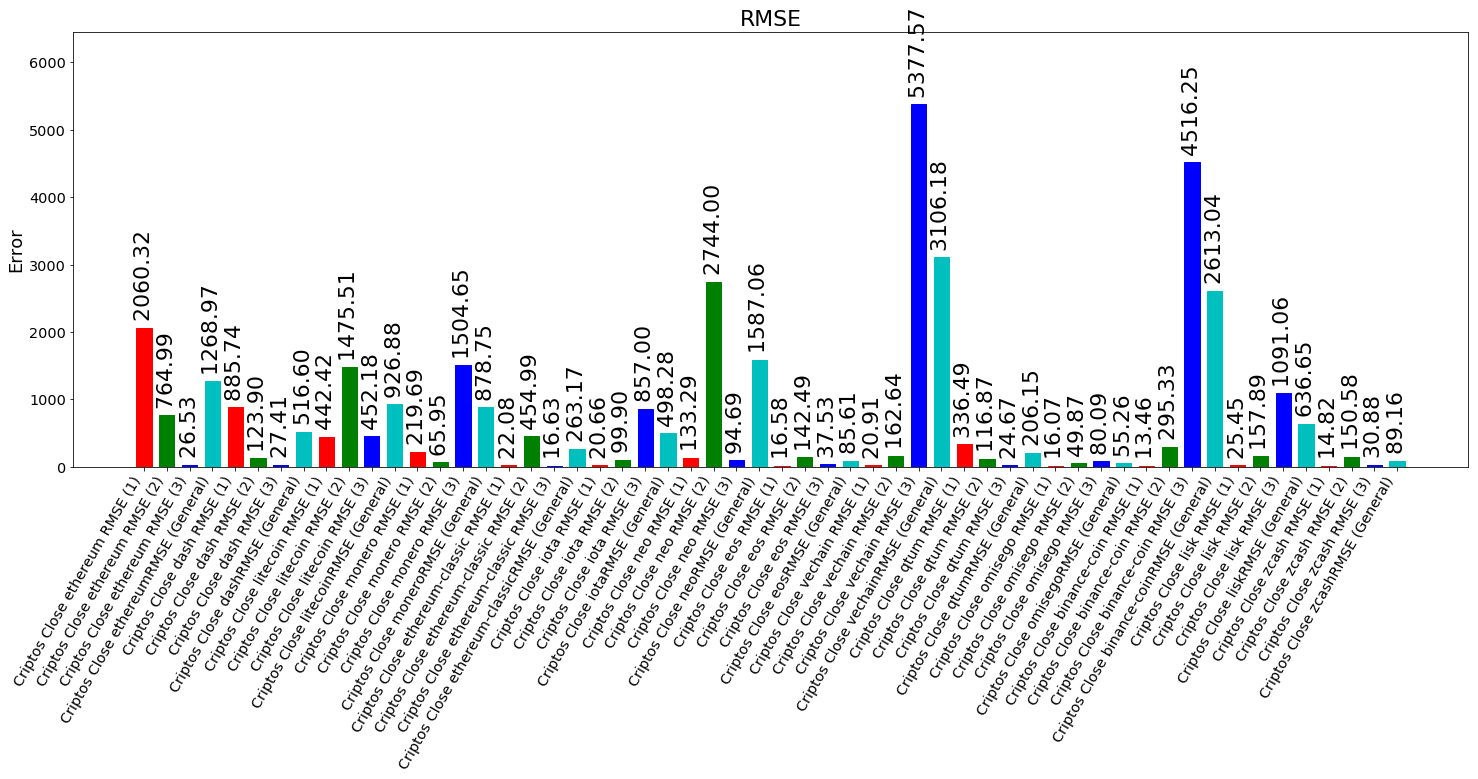

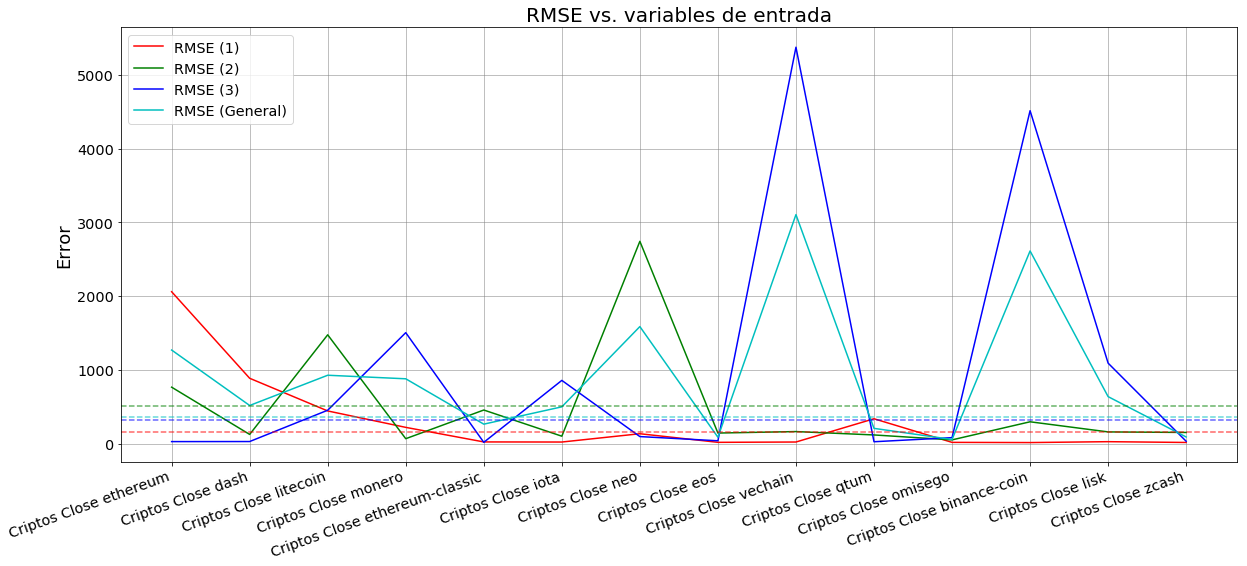

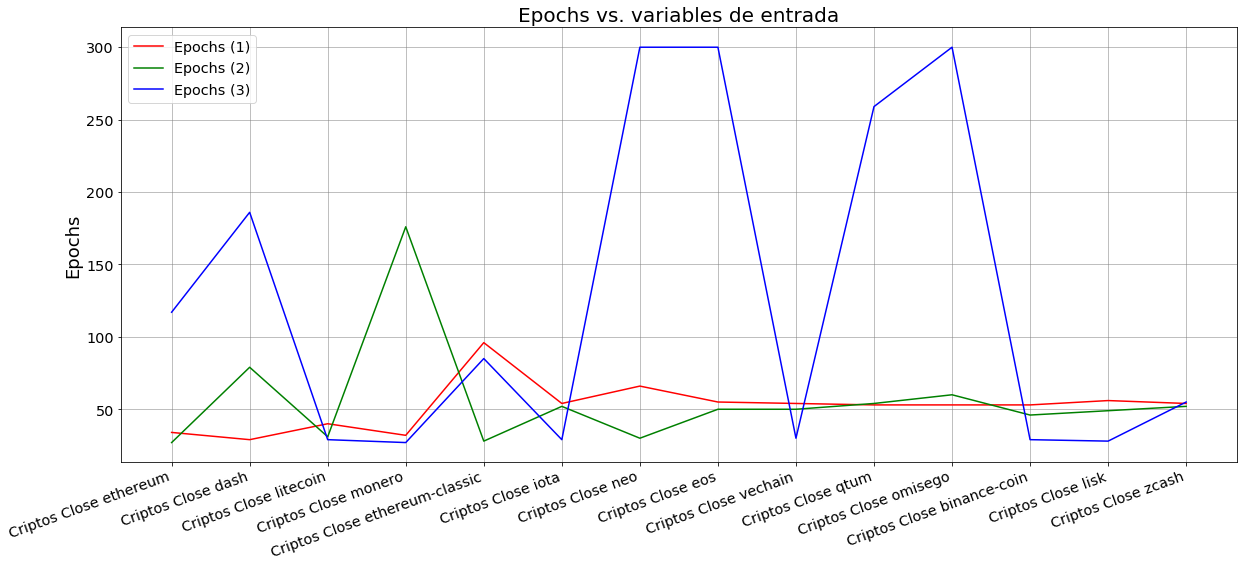

In [80]:
prediccion_variables_cripto = pd.read_csv(datasetfolder + '/' + 'Criptos' + '.csv')
prediccion_variables_cripto['Date'] = pd.to_datetime(prediccion_variables_cripto['Date'])
prediccion_variables_cripto.set_index('Date', inplace=True)

rmse_referencia = pd.read_csv(datasetfolder + '/' + 'Close bitcoin Ventana chica_rmses.csv')
ref = []
for r in range(1,5): 
    ref.append(rmse_referencia.iloc[0][r])
    
dataframe_rmse, dataframe_epochs = postprocesamiento(prediccion_ventana_chica, name='Criptos', name_parametro='variables de entrada', referencia = ref)

In [11]:
# Stocks
cols =  stockindex_names + stocks_names
data = pd.read_csv('data/data.csv', usecols= ['Date'] +  ['Close bitcoin'] + cols)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[:'2018-05-25']

prediccion_variables_stocks = simulacionVariables(data, 512, "Stocks")

Train on 696 samples, validate on 174 samples
Epoch 1/300
696/696 [==============================] - 26s 37ms/step - loss: 0.0101 - val_loss: 0.1536
Epoch 2/300
696/696 [==============================] - 1s 899us/step - loss: 0.0048 - val_loss: 0.1092
Epoch 3/300
696/696 [==============================] - 1s 831us/step - loss: 0.0070 - val_loss: 0.0944
Epoch 4/300
696/696 [==============================] - 1s 839us/step - loss: 0.0079 - val_loss: 0.0951
Epoch 5/300
696/696 [==============================] - 1s 854us/step - loss: 0.0071 - val_loss: 0.0996
Epoch 6/300
696/696 [==============================] - 1s 808us/step - loss: 0.0061 - val_loss: 0.1008
Epoch 7/300
696/696 [==============================] - 1s 795us/step - loss: 0.0054 - val_loss: 0.0966
Epoch 8/300
696/696 [==============================] - 1s 846us/step - loss: 0.0049 - val_loss: 0.0889
Epoch 9/300
696/696 [==============================] - 1s 820us/step - loss: 0.0046 - val_loss: 0.0805
Epoch 10/300
696/696 [=====

Epoch 99/300
832/832 [==============================] - 1s 738us/step - loss: 1.0630e-05 - val_loss: 6.3396e-04
Epoch 100/300
832/832 [==============================] - 1s 814us/step - loss: 1.0553e-05 - val_loss: 6.2985e-04
Epoch 101/300
832/832 [==============================] - 1s 810us/step - loss: 1.0477e-05 - val_loss: 6.2582e-04
Epoch 102/300
832/832 [==============================] - 1s 798us/step - loss: 1.0402e-05 - val_loss: 6.2186e-04
Epoch 103/300
832/832 [==============================] - 1s 789us/step - loss: 1.0329e-05 - val_loss: 6.1798e-04
Epoch 104/300
832/832 [==============================] - 1s 770us/step - loss: 1.0256e-05 - val_loss: 6.1417e-04
Epoch 105/300
832/832 [==============================] - 1s 799us/step - loss: 1.0184e-05 - val_loss: 6.1044e-04
Epoch 106/300
832/832 [==============================] - 1s 799us/step - loss: 1.0114e-05 - val_loss: 6.0678e-04
Epoch 107/300
832/832 [==============================] - 1s 808us/step - loss: 1.0045e-05 - val_l

832/832 [==============================] - 1s 770us/step - loss: 7.1918e-06 - val_loss: 4.8033e-04
Epoch 244/300
832/832 [==============================] - 1s 787us/step - loss: 7.1927e-06 - val_loss: 4.8032e-04
Epoch 245/300
832/832 [==============================] - 1s 790us/step - loss: 7.1934e-06 - val_loss: 4.8031e-04
Epoch 246/300
832/832 [==============================] - 1s 782us/step - loss: 7.1943e-06 - val_loss: 4.8030e-04
Epoch 247/300
832/832 [==============================] - 1s 806us/step - loss: 7.1960e-06 - val_loss: 4.8030e-04
Epoch 248/300
832/832 [==============================] - 1s 796us/step - loss: 7.1986e-06 - val_loss: 4.8029e-04
Epoch 249/300
832/832 [==============================] - 1s 806us/step - loss: 7.2015e-06 - val_loss: 4.8028e-04
Epoch 250/300
832/832 [==============================] - 1s 799us/step - loss: 7.2036e-06 - val_loss: 4.8027e-04
Epoch 251/300
832/832 [==============================] - 1s 804us/step - loss: 7.2045e-06 - val_loss: 4.8026e-

Epoch 15/300
968/968 [==============================] - 1s 773us/step - loss: 5.0683e-04 - val_loss: 0.0640
Epoch 16/300
968/968 [==============================] - 1s 770us/step - loss: 4.3792e-04 - val_loss: 0.0561
Epoch 17/300
968/968 [==============================] - 1s 777us/step - loss: 3.7530e-04 - val_loss: 0.0486-0
Epoch 18/300
968/968 [==============================] - 1s 770us/step - loss: 3.1624e-04 - val_loss: 0.0417
Epoch 19/300
968/968 [==============================] - 1s 792us/step - loss: 2.6155e-04 - val_loss: 0.0353
Epoch 20/300
968/968 [==============================] - 1s 800us/step - loss: 2.1330e-04 - val_loss: 0.0295
Epoch 21/300
968/968 [==============================] - 1s 823us/step - loss: 1.7086e-04 - val_loss: 0.0243
Epoch 22/300
968/968 [==============================] - 1s 815us/step - loss: 1.3451e-04 - val_loss: 0.0198
Epoch 23/300
968/968 [==============================] - 1s 811us/step - loss: 1.0456e-04 - val_loss: 0.0160
Epoch 24/300
968/968 [====

Epoch 91/300
968/968 [==============================] - 1s 784us/step - loss: 1.0952e-05 - val_loss: 0.0012
Epoch 92/300
968/968 [==============================] - 1s 795us/step - loss: 1.0784e-05 - val_loss: 0.0012
Epoch 93/300
968/968 [==============================] - 1s 764us/step - loss: 1.0621e-05 - val_loss: 0.0012
Epoch 94/300
968/968 [==============================] - 1s 790us/step - loss: 1.0461e-05 - val_loss: 0.0012
Epoch 95/300
968/968 [==============================] - 1s 779us/step - loss: 1.0305e-05 - val_loss: 0.0012
Epoch 96/300
968/968 [==============================] - 1s 785us/step - loss: 1.0152e-05 - val_loss: 0.0012
Epoch 97/300
968/968 [==============================] - 1s 781us/step - loss: 1.0003e-05 - val_loss: 0.0012
Epoch 98/300
968/968 [==============================] - 1s 777us/step - loss: 9.8569e-06 - val_loss: 0.0012
Epoch 99/300
968/968 [==============================] - 1s 802us/step - loss: 9.7151e-06 - val_loss: 0.0012
Epoch 100/300
968/968 [=====

832/832 [==============================] - 1s 787us/step - loss: 1.7479e-05 - val_loss: 7.5643e-04
Epoch 59/300
832/832 [==============================] - 1s 790us/step - loss: 1.7170e-05 - val_loss: 7.4672e-04
Epoch 60/300
832/832 [==============================] - 1s 783us/step - loss: 1.6866e-05 - val_loss: 7.3719e-04
Epoch 61/300
832/832 [==============================] - 1s 772us/step - loss: 1.6568e-05 - val_loss: 7.2787e-04
Epoch 62/300
832/832 [==============================] - 1s 807us/step - loss: 1.6274e-05 - val_loss: 7.1877e-04
Epoch 63/300
832/832 [==============================] - 1s 801us/step - loss: 1.5986e-05 - val_loss: 7.0990e-04
Epoch 64/300
832/832 [==============================] - 1s 824us/step - loss: 1.5702e-05 - val_loss: 7.0123e-04
Epoch 65/300
832/832 [==============================] - 1s 822us/step - loss: 1.5425e-05 - val_loss: 6.9281e-04
Epoch 66/300
832/832 [==============================] - 1s 800us/step - loss: 1.5152e-05 - val_loss: 6.8458e-04
Epoch

Epoch 131/300
832/832 [==============================] - 1s 792us/step - loss: 7.3540e-06 - val_loss: 4.8503e-04
Epoch 132/300
832/832 [==============================] - 1s 806us/step - loss: 7.3312e-06 - val_loss: 4.8466e-04
Epoch 133/300
832/832 [==============================] - 1s 795us/step - loss: 7.3097e-06 - val_loss: 4.8432e-04
Epoch 134/300
832/832 [==============================] - 1s 763us/step - loss: 7.2894e-06 - val_loss: 4.8400e-04
Epoch 135/300
832/832 [==============================] - 1s 788us/step - loss: 7.2701e-06 - val_loss: 4.8370e-04
Epoch 136/300
832/832 [==============================] - 1s 783us/step - loss: 7.2520e-06 - val_loss: 4.8343e-04
Epoch 137/300
832/832 [==============================] - 1s 805us/step - loss: 7.2349e-06 - val_loss: 4.8317e-04
Epoch 138/300
832/832 [==============================] - 1s 806us/step - loss: 7.2187e-06 - val_loss: 4.8293e-04
Epoch 139/300
832/832 [==============================] - 1s 798us/step - loss: 7.2035e-06 - val_

832/832 [==============================] - 1s 775us/step - loss: 7.0535e-06 - val_loss: 4.7974e-04
Epoch 276/300
832/832 [==============================] - 1s 794us/step - loss: 7.0477e-06 - val_loss: 4.7978e-04
Epoch 277/300
832/832 [==============================] - 1s 794us/step - loss: 7.0600e-06 - val_loss: 4.7981e-04
Epoch 278/300
832/832 [==============================] - 1s 790us/step - loss: 7.0918e-06 - val_loss: 4.7979e-04
Epoch 279/300
832/832 [==============================] - 1s 817us/step - loss: 7.1301e-06 - val_loss: 4.7970e-04
Epoch 280/300
832/832 [==============================] - 1s 788us/step - loss: 7.1463e-06 - val_loss: 4.7960e-04
Epoch 281/300
832/832 [==============================] - 1s 774us/step - loss: 7.1183e-06 - val_loss: 4.7959e-04
Epoch 282/300
832/832 [==============================] - 1s 789us/step - loss: 7.0591e-06 - val_loss: 4.7966e-04
Epoch 283/300
832/832 [==============================] - 1s 789us/step - loss: 7.0082e-06 - val_loss: 4.7978e-

696/696 [==============================] - 1s 803us/step - loss: 4.3915e-05 - val_loss: 4.3559e-04
Epoch 41/300
696/696 [==============================] - 1s 821us/step - loss: 4.3511e-05 - val_loss: 4.4014e-04
Epoch 42/300
696/696 [==============================] - 1s 816us/step - loss: 4.3338e-05 - val_loss: 4.4434e-04
Epoch 43/300
696/696 [==============================] - 1s 813us/step - loss: 4.3271e-05 - val_loss: 4.4752e-04
Epoch 44/300
696/696 [==============================] - 1s 824us/step - loss: 4.3249e-05 - val_loss: 4.4962e-04
Epoch 45/300
696/696 [==============================] - 1s 841us/step - loss: 4.3242e-05 - val_loss: 4.5080e-04
Epoch 46/300
696/696 [==============================] - 1s 808us/step - loss: 4.3239e-05 - val_loss: 4.5132e-04
Epoch 47/300
696/696 [==============================] - 1s 823us/step - loss: 4.3237e-05 - val_loss: 4.5141e-04
Epoch 48/300
696/696 [==============================] - 1s 823us/step - loss: 4.3234e-05 - val_loss: 4.5125e-04
Epoch

Epoch 134/300
832/832 [==============================] - 1s 808us/step - loss: 8.0449e-06 - val_loss: 5.1438e-04
Epoch 135/300
832/832 [==============================] - 1s 800us/step - loss: 8.0225e-06 - val_loss: 5.1322e-04
Epoch 136/300
832/832 [==============================] - 1s 745us/step - loss: 8.0004e-06 - val_loss: 5.1210e-04
Epoch 137/300
832/832 [==============================] - 1s 748us/step - loss: 7.9787e-06 - val_loss: 5.1101e-04
Epoch 138/300
832/832 [==============================] - 1s 812us/step - loss: 7.9575e-06 - val_loss: 5.0994e-04
Epoch 139/300
832/832 [==============================] - 1s 834us/step - loss: 7.9367e-06 - val_loss: 5.0890e-04
Epoch 140/300
832/832 [==============================] - 1s 796us/step - loss: 7.9162e-06 - val_loss: 5.0788e-04
Epoch 141/300
832/832 [==============================] - 1s 788us/step - loss: 7.8961e-06 - val_loss: 5.0689e-04
Epoch 142/300
832/832 [==============================] - 1s 793us/step - loss: 7.8765e-06 - val_

832/832 [==============================] - 1s 796us/step - loss: 7.4362e-06 - val_loss: 4.7898e-04
Epoch 279/300
832/832 [==============================] - 1s 782us/step - loss: 7.4132e-06 - val_loss: 4.7901e-04
Epoch 280/300
832/832 [==============================] - 1s 794us/step - loss: 7.3662e-06 - val_loss: 4.7904e-04
Epoch 281/300
832/832 [==============================] - 1s 790us/step - loss: 7.3251e-06 - val_loss: 4.7908e-04
Epoch 282/300
832/832 [==============================] - 1s 819us/step - loss: 7.3210e-06 - val_loss: 4.7911e-04
Epoch 283/300
832/832 [==============================] - 1s 788us/step - loss: 7.3733e-06 - val_loss: 4.7913e-04
Epoch 284/300
832/832 [==============================] - 1s 786us/step - loss: 7.4795e-06 - val_loss: 4.7908e-04
Epoch 285/300
832/832 [==============================] - 1s 796us/step - loss: 7.6006e-06 - val_loss: 4.7895e-04
Epoch 286/300
832/832 [==============================] - 1s 802us/step - loss: 7.6623e-06 - val_loss: 4.7890e-

696/696 [==============================] - 15s 21ms/step - loss: 0.0123 - val_loss: 0.1642
Epoch 2/300
696/696 [==============================] - 0s 675us/step - loss: 0.0046 - val_loss: 0.1125
Epoch 3/300
696/696 [==============================] - 0s 712us/step - loss: 0.0069 - val_loss: 0.0946
Epoch 4/300
696/696 [==============================] - 0s 695us/step - loss: 0.0083 - val_loss: 0.0953
Epoch 5/300
696/696 [==============================] - 0s 686us/step - loss: 0.0075 - val_loss: 0.1015
Epoch 6/300
696/696 [==============================] - 0s 683us/step - loss: 0.0063 - val_loss: 0.1044
Epoch 7/300
696/696 [==============================] - 0s 704us/step - loss: 0.0056 - val_loss: 0.1010
Epoch 8/300
696/696 [==============================] - 0s 701us/step - loss: 0.0050 - val_loss: 0.0933
Epoch 9/300
696/696 [==============================] - 0s 717us/step - loss: 0.0047 - val_loss: 0.0846
Epoch 10/300
696/696 [==============================] - 1s 790us/step - loss: 0.0046 

Epoch 96/300
832/832 [==============================] - 1s 750us/step - loss: 8.5931e-06 - val_loss: 5.4878e-04
Epoch 97/300
832/832 [==============================] - 1s 741us/step - loss: 8.5682e-06 - val_loss: 5.4743e-04
Epoch 98/300
832/832 [==============================] - 1s 763us/step - loss: 8.5435e-06 - val_loss: 5.4610e-04
Epoch 99/300
832/832 [==============================] - 1s 741us/step - loss: 8.5190e-06 - val_loss: 5.4479e-04
Epoch 100/300
832/832 [==============================] - 1s 770us/step - loss: 8.4946e-06 - val_loss: 5.4349e-04
Epoch 101/300
832/832 [==============================] - 1s 760us/step - loss: 8.4707e-06 - val_loss: 5.4221e-04
Epoch 102/300
832/832 [==============================] - 1s 789us/step - loss: 8.4468e-06 - val_loss: 5.4095e-04
Epoch 103/300
832/832 [==============================] - 1s 765us/step - loss: 8.4232e-06 - val_loss: 5.3970e-04
Epoch 104/300
832/832 [==============================] - 1s 754us/step - loss: 8.4001e-06 - val_loss

832/832 [==============================] - 1s 756us/step - loss: 7.2650e-06 - val_loss: 4.8158e-04
Epoch 241/300
832/832 [==============================] - 1s 750us/step - loss: 7.2714e-06 - val_loss: 4.8158e-04
Epoch 242/300
832/832 [==============================] - 1s 753us/step - loss: 7.2815e-06 - val_loss: 4.8156e-04
Epoch 243/300
832/832 [==============================] - 1s 777us/step - loss: 7.2906e-06 - val_loss: 4.8150e-04
Epoch 244/300
832/832 [==============================] - 1s 774us/step - loss: 7.2927e-06 - val_loss: 4.8142e-04
Epoch 245/300
832/832 [==============================] - 1s 758us/step - loss: 7.2863e-06 - val_loss: 4.8136e-04
Epoch 246/300
832/832 [==============================] - 1s 748us/step - loss: 7.2768e-06 - val_loss: 4.8135e-04
Epoch 247/300
832/832 [==============================] - 1s 753us/step - loss: 7.2739e-06 - val_loss: 4.8139e-04
Epoch 248/300
832/832 [==============================] - 1s 765us/step - loss: 7.2855e-06 - val_loss: 4.8146e-

Epoch 108/300
968/968 [==============================] - 1s 762us/step - loss: 8.2996e-06 - val_loss: 0.0011
Epoch 109/300
968/968 [==============================] - 1s 753us/step - loss: 8.2326e-06 - val_loss: 0.0011
Epoch 110/300
968/968 [==============================] - 1s 758us/step - loss: 8.1671e-06 - val_loss: 0.0011
Epoch 111/300
968/968 [==============================] - 1s 752us/step - loss: 8.1031e-06 - val_loss: 0.0011
Epoch 00111: early stopping
Entrenamiento Stocks ^GSPC(1) completo.
[[8826.949 ]
 [9272.561 ]
 [8980.25  ]
 [9337.54  ]
 [9404.893 ]
 [9223.814 ]
 [9105.491 ]
 [9214.026 ]
 [9718.041 ]
 [9689.424 ]
 [9847.925 ]
 [9646.156 ]
 [9366.217 ]
 [9228.079 ]
 [9329.063 ]
 [9058.965 ]
 [8460.301 ]
 [8523.778 ]
 [8742.4   ]
 [8735.601 ]
 [8522.355 ]
 [8385.829 ]
 [8111.69  ]
 [8264.714 ]
 [8263.6045]
 [8531.221 ]
 [8440.017 ]
 [8061.1255]
 [7583.462 ]
 [7610.6597]]
Predicción Stocks ^GSPC completa.
Train on 696 samples, validate on 174 samples
Epoch 1/300
696/696 [====

Epoch 140/300
696/696 [==============================] - 1s 765us/step - loss: 4.4656e-05 - val_loss: 4.3419e-04
Epoch 141/300
696/696 [==============================] - 1s 773us/step - loss: 4.4590e-05 - val_loss: 4.3434e-04
Epoch 142/300
696/696 [==============================] - 1s 783us/step - loss: 4.4525e-05 - val_loss: 4.3451e-04
Epoch 143/300
696/696 [==============================] - 1s 768us/step - loss: 4.4462e-05 - val_loss: 4.3472e-04
Epoch 144/300
696/696 [==============================] - 1s 785us/step - loss: 4.4402e-05 - val_loss: 4.3494e-04
Epoch 145/300
696/696 [==============================] - 1s 781us/step - loss: 4.4343e-05 - val_loss: 4.3519e-04
Epoch 146/300
696/696 [==============================] - 1s 773us/step - loss: 4.4287e-05 - val_loss: 4.3547e-04
Epoch 00146: early stopping
Entrenamiento Stocks AAPL(3) completo.
[[2152.5269]
 [2105.3762]
 [2249.1555]
 [2409.7502]
 [2544.8843]
 [2392.8606]
 [2280.6836]
 [2102.837 ]
 [2229.8818]
 [2338.7773]
 [2251.3179]

Epoch 9/300
968/968 [==============================] - 1s 729us/step - loss: 9.9588e-04 - val_loss: 0.1242
Epoch 10/300
968/968 [==============================] - 1s 733us/step - loss: 9.2412e-04 - val_loss: 0.1149
Epoch 11/300
968/968 [==============================] - 1s 764us/step - loss: 8.6431e-04 - val_loss: 0.1064
Epoch 12/300
968/968 [==============================] - 1s 745us/step - loss: 7.8746e-04 - val_loss: 0.0981
Epoch 13/300
968/968 [==============================] - 1s 743us/step - loss: 7.0769e-04 - val_loss: 0.0897
Epoch 14/300
968/968 [==============================] - 1s 726us/step - loss: 6.3789e-04 - val_loss: 0.0813
Epoch 15/300
968/968 [==============================] - 1s 694us/step - loss: 5.7348e-04 - val_loss: 0.0733
Epoch 16/300
968/968 [==============================] - 1s 696us/step - loss: 5.0728e-04 - val_loss: 0.0655
Epoch 17/300
968/968 [==============================] - 1s 691us/step - loss: 4.4437e-04 - val_loss: 0.0580
Epoch 18/300
968/968 [=======

Epoch 85/300
968/968 [==============================] - 1s 828us/step - loss: 7.9634e-06 - val_loss: 0.0011
Epoch 86/300
968/968 [==============================] - 1s 819us/step - loss: 7.7644e-06 - val_loss: 0.0011
Epoch 87/300
968/968 [==============================] - 1s 820us/step - loss: 7.5816e-06 - val_loss: 0.0011
Epoch 88/300
968/968 [==============================] - 1s 824us/step - loss: 7.4147e-06 - val_loss: 0.0012
Epoch 00088: early stopping
Entrenamiento Stocks AAPL(1) completo.
[[8879.746 ]
 [9319.472 ]
 [9015.971 ]
 [9382.784 ]
 [9457.884 ]
 [9282.758 ]
 [9176.823 ]
 [9325.922 ]
 [9839.556 ]
 [9826.291 ]
 [9987.413 ]
 [9783.661 ]
 [9500.622 ]
 [9364.666 ]
 [9461.557 ]
 [9188.192 ]
 [8573.2295]
 [8636.703 ]
 [8857.473 ]
 [8849.656 ]
 [8634.32  ]
 [8498.227 ]
 [8216.505 ]
 [8371.958 ]
 [8369.839 ]
 [8640.188 ]
 [8546.729 ]
 [8164.1396]
 [7680.459 ]
 [7709.457 ]]
Predicción Stocks AAPL completa.
Train on 696 samples, validate on 174 samples
Epoch 1/300
696/696 [==========

696/696 [==============================] - 1s 773us/step - loss: 7.1832e-05 - val_loss: 8.0663e-04
Epoch 69/300
696/696 [==============================] - 1s 866us/step - loss: 7.1198e-05 - val_loss: 7.9531e-04
Epoch 70/300
696/696 [==============================] - 1s 808us/step - loss: 7.0571e-05 - val_loss: 7.8415e-04
Epoch 71/300
696/696 [==============================] - 1s 806us/step - loss: 6.9950e-05 - val_loss: 7.7319e-04
Epoch 72/300
696/696 [==============================] - 1s 811us/step - loss: 6.9335e-05 - val_loss: 7.6240e-04
Epoch 73/300
696/696 [==============================] - 1s 788us/step - loss: 6.8728e-05 - val_loss: 7.5180e-04
Epoch 74/300
696/696 [==============================] - 1s 778us/step - loss: 6.8127e-05 - val_loss: 7.4137e-04
Epoch 75/300
696/696 [==============================] - 1s 823us/step - loss: 6.7534e-05 - val_loss: 7.3113e-04
Epoch 76/300
696/696 [==============================] - 1s 813us/step - loss: 6.6947e-05 - val_loss: 7.2108e-04
Epoch

Epoch 141/300
696/696 [==============================] - 1s 869us/step - loss: 4.5206e-05 - val_loss: 4.3222e-04
Epoch 142/300
696/696 [==============================] - 1s 872us/step - loss: 4.5086e-05 - val_loss: 4.3183e-04
Epoch 143/300
696/696 [==============================] - 1s 870us/step - loss: 4.4971e-05 - val_loss: 4.3150e-04
Epoch 144/300
696/696 [==============================] - 1s 883us/step - loss: 4.4860e-05 - val_loss: 4.3123e-04
Epoch 145/300
696/696 [==============================] - 1s 926us/step - loss: 4.4753e-05 - val_loss: 4.3102e-04
Epoch 146/300
696/696 [==============================] - 1s 885us/step - loss: 4.4650e-05 - val_loss: 4.3086e-04
Epoch 147/300
696/696 [==============================] - 1s 897us/step - loss: 4.4550e-05 - val_loss: 4.3076e-04
Epoch 148/300
696/696 [==============================] - 1s 876us/step - loss: 4.4455e-05 - val_loss: 4.3070e-04
Epoch 149/300
696/696 [==============================] - 1s 872us/step - loss: 4.4363e-05 - val_

832/832 [==============================] - 1s 853us/step - loss: 7.1295e-06 - val_loss: 4.9066e-04
Epoch 127/300
832/832 [==============================] - 1s 908us/step - loss: 7.1072e-06 - val_loss: 4.9208e-04
Epoch 128/300
832/832 [==============================] - 1s 866us/step - loss: 7.0873e-06 - val_loss: 4.9356e-04
Epoch 129/300
832/832 [==============================] - 1s 861us/step - loss: 7.0695e-06 - val_loss: 4.9506e-04
Epoch 00129: early stopping
Entrenamiento Stocks FB(2) completo.
[[ 7186.5376]
 [ 7313.447 ]
 [ 7640.405 ]
 [ 7310.1626]
 [ 6761.4126]
 [ 6491.1333]
 [ 6068.912 ]
 [ 6701.224 ]
 [ 6778.772 ]
 [ 7485.8096]
 [ 8070.686 ]
 [ 7899.0757]
 [ 7983.591 ]
 [ 8240.762 ]
 [ 8412.17  ]
 [ 8285.906 ]
 [ 8473.831 ]
 [ 8251.801 ]
 [ 8479.631 ]
 [ 9043.263 ]
 [ 9610.447 ]
 [10123.98  ]
 [10375.039 ]
 [10170.109 ]
 [10540.106 ]
 [11313.159 ]
 [11412.637 ]
 [11669.507 ]
 [12016.177 ]
 [12295.171 ]]
Train on 968 samples, validate on 242 samples
Epoch 1/300
968/968 [=========

696/696 [==============================] - 1s 844us/step - loss: 7.8345e-05 - val_loss: 5.3172e-04
Epoch 48/300
696/696 [==============================] - 1s 843us/step - loss: 7.7592e-05 - val_loss: 5.2770e-04
Epoch 49/300
696/696 [==============================] - 1s 882us/step - loss: 7.6836e-05 - val_loss: 5.2387e-04
Epoch 50/300
696/696 [==============================] - 1s 887us/step - loss: 7.6082e-05 - val_loss: 5.2006e-04
Epoch 51/300
696/696 [==============================] - 1s 850us/step - loss: 7.5338e-05 - val_loss: 5.1624e-04
Epoch 52/300
696/696 [==============================] - 1s 892us/step - loss: 7.4595e-05 - val_loss: 5.1239e-04
Epoch 53/300
696/696 [==============================] - 1s 869us/step - loss: 7.3863e-05 - val_loss: 5.0851e-04
Epoch 54/300
696/696 [==============================] - 1s 860us/step - loss: 7.3138e-05 - val_loss: 5.0464e-04
Epoch 55/300
696/696 [==============================] - 1s 874us/step - loss: 7.2422e-05 - val_loss: 5.0079e-04
Epoch

832/832 [==============================] - 1s 823us/step - loss: 9.8527e-04 - val_loss: 0.1212
Epoch 8/300
832/832 [==============================] - 1s 817us/step - loss: 8.3287e-04 - val_loss: 0.1149
Epoch 9/300
832/832 [==============================] - 1s 837us/step - loss: 7.3431e-04 - val_loss: 0.1064
Epoch 10/300
832/832 [==============================] - 1s 825us/step - loss: 7.0793e-04 - val_loss: 0.0991
Epoch 11/300
832/832 [==============================] - 1s 824us/step - loss: 6.7279e-04 - val_loss: 0.0931
Epoch 12/300
832/832 [==============================] - 1s 834us/step - loss: 6.0415e-04 - val_loss: 0.0869
Epoch 13/300
832/832 [==============================] - 1s 834us/step - loss: 5.3879e-04 - val_loss: 0.0802
Epoch 14/300
832/832 [==============================] - 1s 831us/step - loss: 4.9212e-04 - val_loss: 0.0737
Epoch 15/300
832/832 [==============================] - 1s 838us/step - loss: 4.4828e-04 - val_loss: 0.0677
Epoch 16/300
832/832 [=====================

968/968 [==============================] - 1s 836us/step - loss: 1.0616e-04 - val_loss: 0.0131
Epoch 28/300
968/968 [==============================] - 1s 856us/step - loss: 1.0189e-04 - val_loss: 0.0115
Epoch 29/300
968/968 [==============================] - 1s 861us/step - loss: 9.8520e-05 - val_loss: 0.0103
Epoch 30/300
968/968 [==============================] - 1s 835us/step - loss: 9.5640e-05 - val_loss: 0.0093
Epoch 31/300
968/968 [==============================] - 1s 849us/step - loss: 9.2992e-05 - val_loss: 0.0084
Epoch 32/300
968/968 [==============================] - 1s 874us/step - loss: 9.0317e-05 - val_loss: 0.0077
Epoch 33/300
968/968 [==============================] - 1s 839us/step - loss: 8.7611e-05 - val_loss: 0.0072
Epoch 34/300
968/968 [==============================] - 1s 843us/step - loss: 8.4836e-05 - val_loss: 0.0067
Epoch 35/300
968/968 [==============================] - 1s 853us/step - loss: 8.1944e-05 - val_loss: 0.0062
Epoch 36/300
968/968 [===================

696/696 [==============================] - 1s 847us/step - loss: 5.0936e-05 - val_loss: 4.2476e-04
Epoch 89/300
696/696 [==============================] - 1s 854us/step - loss: 5.0626e-05 - val_loss: 4.2440e-04
Epoch 90/300
696/696 [==============================] - 1s 830us/step - loss: 5.0324e-05 - val_loss: 4.2409e-04
Epoch 91/300
696/696 [==============================] - 1s 876us/step - loss: 5.0031e-05 - val_loss: 4.2384e-04
Epoch 92/300
696/696 [==============================] - 1s 857us/step - loss: 4.9746e-05 - val_loss: 4.2363e-04
Epoch 93/300
696/696 [==============================] - 1s 834us/step - loss: 4.9470e-05 - val_loss: 4.2348e-04
Epoch 94/300
696/696 [==============================] - 1s 860us/step - loss: 4.9202e-05 - val_loss: 4.2338e-04
Epoch 95/300
696/696 [==============================] - 1s 840us/step - loss: 4.8942e-05 - val_loss: 4.2332e-04
Epoch 96/300
696/696 [==============================] - 1s 869us/step - loss: 4.8690e-05 - val_loss: 4.2330e-04
Epoch

Epoch 53/300
832/832 [==============================] - 1s 847us/step - loss: 3.3841e-05 - val_loss: 0.0026
Epoch 54/300
832/832 [==============================] - 1s 832us/step - loss: 3.2720e-05 - val_loss: 0.0025
Epoch 55/300
832/832 [==============================] - 1s 812us/step - loss: 3.1608e-05 - val_loss: 0.0023
Epoch 56/300
832/832 [==============================] - 1s 834us/step - loss: 3.0539e-05 - val_loss: 0.0022
Epoch 57/300
832/832 [==============================] - 1s 841us/step - loss: 2.9491e-05 - val_loss: 0.0021
Epoch 58/300
832/832 [==============================] - 1s 847us/step - loss: 2.8472e-05 - val_loss: 0.0020
Epoch 59/300
832/832 [==============================] - 1s 818us/step - loss: 2.7479e-05 - val_loss: 0.0019
Epoch 60/300
832/832 [==============================] - 1s 828us/step - loss: 2.6520e-05 - val_loss: 0.0018
Epoch 61/300
832/832 [==============================] - 1s 832us/step - loss: 2.5581e-05 - val_loss: 0.0018
Epoch 62/300
832/832 [======

968/968 [==============================] - 1s 807us/step - loss: 7.2471e-06 - val_loss: 0.0012
Epoch 82/300
968/968 [==============================] - 1s 802us/step - loss: 7.0735e-06 - val_loss: 0.0012
Epoch 00082: early stopping
Entrenamiento Stocks GOOGL(1) completo.
[[8904.608 ]
 [9360.841 ]
 [9053.601 ]
 [9418.164 ]
 [9487.071 ]
 [9302.706 ]
 [9193.828 ]
 [9302.976 ]
 [9819.907 ]
 [9793.076 ]
 [9955.528 ]
 [9750.099 ]
 [9464.807 ]
 [9323.467 ]
 [9435.736 ]
 [9159.625 ]
 [8544.213 ]
 [8609.443 ]
 [8833.3125]
 [8826.701 ]
 [8602.9   ]
 [8458.43  ]
 [8177.6914]
 [8329.824 ]
 [8328.883 ]
 [8602.3125]
 [8509.396 ]
 [8120.7793]
 [7635.792 ]
 [7665.449 ]]
Predicción Stocks GOOGL completa.
Train on 696 samples, validate on 174 samples
Epoch 1/300
696/696 [==============================] - 21s 30ms/step - loss: 0.0091 - val_loss: 0.1530
Epoch 2/300
696/696 [==============================] - 1s 846us/step - loss: 0.0054 - val_loss: 0.1140
Epoch 3/300
696/696 [==============================]

Epoch 16/300
832/832 [==============================] - 1s 823us/step - loss: 5.8253e-04 - val_loss: 0.0694
Epoch 17/300
832/832 [==============================] - 1s 823us/step - loss: 5.2980e-04 - val_loss: 0.0631
Epoch 18/300
832/832 [==============================] - 1s 842us/step - loss: 4.8341e-04 - val_loss: 0.0571
Epoch 19/300
832/832 [==============================] - 1s 852us/step - loss: 4.3625e-04 - val_loss: 0.0513
Epoch 20/300
832/832 [==============================] - 1s 813us/step - loss: 3.8916e-04 - val_loss: 0.0458
Epoch 21/300
832/832 [==============================] - 1s 817us/step - loss: 3.4571e-04 - val_loss: 0.0405
Epoch 22/300
832/832 [==============================] - 1s 811us/step - loss: 3.0403e-04 - val_loss: 0.0354
Epoch 23/300
832/832 [==============================] - 1s 814us/step - loss: 2.6472e-04 - val_loss: 0.0308
Epoch 24/300
832/832 [==============================] - 1s 816us/step - loss: 2.2871e-04 - val_loss: 0.0264
Epoch 25/300
832/832 [======

832/832 [==============================] - 1s 823us/step - loss: 7.6518e-06 - val_loss: 5.5436e-04
Epoch 91/300
832/832 [==============================] - 1s 823us/step - loss: 7.6070e-06 - val_loss: 5.5183e-04
Epoch 92/300
832/832 [==============================] - 1s 811us/step - loss: 7.5647e-06 - val_loss: 5.4942e-04
Epoch 93/300
832/832 [==============================] - 1s 823us/step - loss: 7.5247e-06 - val_loss: 5.4711e-04
Epoch 94/300
832/832 [==============================] - 1s 825us/step - loss: 7.4870e-06 - val_loss: 5.4490e-04
Epoch 95/300
832/832 [==============================] - 1s 818us/step - loss: 7.4515e-06 - val_loss: 5.4279e-04
Epoch 96/300
832/832 [==============================] - 1s 835us/step - loss: 7.4180e-06 - val_loss: 5.4078e-04
Epoch 97/300
832/832 [==============================] - 1s 826us/step - loss: 7.3865e-06 - val_loss: 5.3885e-04
Epoch 98/300
832/832 [==============================] - 1s 824us/step - loss: 7.3569e-06 - val_loss: 5.3702e-04
Epoch

968/968 [==============================] - 1s 782us/step - loss: 8.2266e-06 - val_loss: 0.0012
Epoch 39/300
968/968 [==============================] - 1s 818us/step - loss: 7.7977e-06 - val_loss: 0.0012
Epoch 40/300
968/968 [==============================] - 1s 806us/step - loss: 7.5275e-06 - val_loss: 0.0012
Epoch 41/300
968/968 [==============================] - 1s 832us/step - loss: 7.3499e-06 - val_loss: 0.0012
Epoch 42/300
968/968 [==============================] - 1s 816us/step - loss: 7.2255e-06 - val_loss: 0.0012
Epoch 43/300
968/968 [==============================] - 1s 821us/step - loss: 7.1315e-06 - val_loss: 0.0012
Epoch 44/300
968/968 [==============================] - 1s 818us/step - loss: 7.0552e-06 - val_loss: 0.0012
Epoch 45/300
968/968 [==============================] - 1s 810us/step - loss: 6.9896e-06 - val_loss: 0.0013
Epoch 46/300
968/968 [==============================] - 1s 836us/step - loss: 6.9308e-06 - val_loss: 0.0013
Epoch 47/300
968/968 [===================

832/832 [==============================] - 1s 804us/step - loss: 8.0414e-06 - val_loss: 5.0294e-04
Epoch 83/300
832/832 [==============================] - 1s 783us/step - loss: 7.9996e-06 - val_loss: 5.0185e-04
Epoch 84/300
832/832 [==============================] - 1s 784us/step - loss: 7.9589e-06 - val_loss: 5.0079e-04
Epoch 85/300
832/832 [==============================] - 1s 796us/step - loss: 7.9196e-06 - val_loss: 4.9977e-04
Epoch 86/300
832/832 [==============================] - 1s 776us/step - loss: 7.8813e-06 - val_loss: 4.9880e-04
Epoch 87/300
832/832 [==============================] - 1s 798us/step - loss: 7.8442e-06 - val_loss: 4.9786e-04
Epoch 88/300
832/832 [==============================] - 1s 783us/step - loss: 7.8083e-06 - val_loss: 4.9696e-04
Epoch 89/300
832/832 [==============================] - 1s 787us/step - loss: 7.7735e-06 - val_loss: 4.9609e-04
Epoch 90/300
832/832 [==============================] - 1s 800us/step - loss: 7.7398e-06 - val_loss: 4.9526e-04
Epoch

696/696 [==============================] - 1s 791us/step - loss: 0.0021 - val_loss: 0.0350
Epoch 19/300
696/696 [==============================] - 1s 817us/step - loss: 0.0018 - val_loss: 0.0309
Epoch 20/300
696/696 [==============================] - 1s 816us/step - loss: 0.0016 - val_loss: 0.0270
Epoch 21/300
696/696 [==============================] - 1s 814us/step - loss: 0.0014 - val_loss: 0.0232
Epoch 22/300
696/696 [==============================] - 1s 830us/step - loss: 0.0012 - val_loss: 0.0197
Epoch 23/300
696/696 [==============================] - 1s 797us/step - loss: 0.0010 - val_loss: 0.0165
Epoch 24/300
696/696 [==============================] - 1s 827us/step - loss: 8.5176e-04 - val_loss: 0.0136
Epoch 25/300
696/696 [==============================] - 1s 798us/step - loss: 7.0243e-04 - val_loss: 0.0111
Epoch 26/300
696/696 [==============================] - 1s 827us/step - loss: 5.7108e-04 - val_loss: 0.0088
Epoch 27/300
696/696 [==============================] - 1s 814us/

696/696 [==============================] - 1s 830us/step - loss: 5.2359e-05 - val_loss: 4.1956e-04
Epoch 93/300
696/696 [==============================] - 1s 821us/step - loss: 5.2182e-05 - val_loss: 4.1939e-04
Epoch 94/300
696/696 [==============================] - 1s 826us/step - loss: 5.2007e-05 - val_loss: 4.1924e-04
Epoch 95/300
696/696 [==============================] - 1s 836us/step - loss: 5.1834e-05 - val_loss: 4.1910e-04
Epoch 96/300
696/696 [==============================] - 1s 820us/step - loss: 5.1663e-05 - val_loss: 4.1897e-04
Epoch 97/300
696/696 [==============================] - 1s 829us/step - loss: 5.1494e-05 - val_loss: 4.1886e-04
Epoch 98/300
696/696 [==============================] - 1s 810us/step - loss: 5.1327e-05 - val_loss: 4.1876e-04
Epoch 99/300
696/696 [==============================] - 1s 810us/step - loss: 5.1162e-05 - val_loss: 4.1867e-04
Epoch 100/300
696/696 [==============================] - 1s 814us/step - loss: 5.0999e-05 - val_loss: 4.1860e-04
Epoc

832/832 [==============================] - 1s 772us/step - loss: 9.1743e-06 - val_loss: 7.5069e-04
Epoch 122/300
832/832 [==============================] - 1s 787us/step - loss: 9.0643e-06 - val_loss: 7.3329e-04
Epoch 123/300
832/832 [==============================] - 1s 756us/step - loss: 8.9581e-06 - val_loss: 7.1674e-04
Epoch 124/300
832/832 [==============================] - 1s 795us/step - loss: 8.8560e-06 - val_loss: 7.0103e-04
Epoch 125/300
832/832 [==============================] - 1s 786us/step - loss: 8.7580e-06 - val_loss: 6.8612e-04
Epoch 126/300
832/832 [==============================] - 1s 772us/step - loss: 8.6637e-06 - val_loss: 6.7198e-04
Epoch 127/300
832/832 [==============================] - 1s 792us/step - loss: 8.5732e-06 - val_loss: 6.5860e-04
Epoch 128/300
832/832 [==============================] - 1s 786us/step - loss: 8.4864e-06 - val_loss: 6.4595e-04
Epoch 129/300
832/832 [==============================] - 1s 770us/step - loss: 8.4031e-06 - val_loss: 6.3399e-

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.088407). Check your callbacks.
  % delta_t_median)


968/968 [==============================] - 89s 92ms/step - loss: 0.0013 - val_loss: 0.1858
Epoch 2/300
968/968 [==============================] - 1s 869us/step - loss: 0.0019 - val_loss: 0.1697
Epoch 3/300
968/968 [==============================] - 1s 826us/step - loss: 0.0018 - val_loss: 0.1731
Epoch 4/300
968/968 [==============================] - 1s 836us/step - loss: 0.0013 - val_loss: 0.1652
Epoch 5/300
968/968 [==============================] - 1s 842us/step - loss: 0.0011 - val_loss: 0.1501
Epoch 6/300
968/968 [==============================] - 1s 821us/step - loss: 0.0011 - val_loss: 0.1385
Epoch 7/300
968/968 [==============================] - 1s 827us/step - loss: 0.0011 - val_loss: 0.1308
Epoch 8/300
968/968 [==============================] - 1s 936us/step - loss: 9.4948e-04 - val_loss: 0.1225
Epoch 9/300
968/968 [==============================] - 1s 851us/step - loss: 8.3522e-04 - val_loss: 0.1127
Epoch 10/300
968/968 [==============================] - 1s 852us/step - loss:

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.280362). Check your callbacks.
  % delta_t_median)


696/696 [==============================] - 62s 89ms/step - loss: 0.0120 - val_loss: 0.1600
Epoch 2/300
696/696 [==============================] - 1s 993us/step - loss: 0.0047 - val_loss: 0.1070
Epoch 3/300
696/696 [==============================] - 1s 849us/step - loss: 0.0057 - val_loss: 0.0835
Epoch 4/300
696/696 [==============================] - 1s 918us/step - loss: 0.0072 - val_loss: 0.0792
Epoch 5/300
696/696 [==============================] - 1s 880us/step - loss: 0.0069 - val_loss: 0.0832
Epoch 6/300
696/696 [==============================] - 1s 846us/step - loss: 0.0060 - val_loss: 0.0872
Epoch 7/300
696/696 [==============================] - 1s 889us/step - loss: 0.0053 - val_loss: 0.0869
Epoch 8/300
696/696 [==============================] - 1s 827us/step - loss: 0.0048 - val_loss: 0.0821
Epoch 9/300
696/696 [==============================] - 1s 866us/step - loss: 0.0044 - val_loss: 0.0748
Epoch 10/300
696/696 [==============================] - 1s 885us/step - loss: 0.0042 

Epoch 27/300
832/832 [==============================] - 1s 841us/step - loss: 1.5272e-04 - val_loss: 0.0175
Epoch 28/300
832/832 [==============================] - 1s 855us/step - loss: 1.4357e-04 - val_loss: 0.0156
Epoch 29/300
832/832 [==============================] - 1s 848us/step - loss: 1.3549e-04 - val_loss: 0.0140
Epoch 30/300
832/832 [==============================] - 1s 859us/step - loss: 1.2823e-04 - val_loss: 0.0126
Epoch 31/300
832/832 [==============================] - 1s 829us/step - loss: 1.2156e-04 - val_loss: 0.0114
Epoch 32/300
832/832 [==============================] - 1s 853us/step - loss: 1.1534e-04 - val_loss: 0.0103
Epoch 33/300
832/832 [==============================] - 1s 841us/step - loss: 1.0949e-04 - val_loss: 0.0094
Epoch 34/300
832/832 [==============================] - 1s 854us/step - loss: 1.0390e-04 - val_loss: 0.0086
Epoch 35/300
832/832 [==============================] - 1s 865us/step - loss: 9.8527e-05 - val_loss: 0.0079
Epoch 36/300
832/832 [======

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.545823). Check your callbacks.
  % delta_t_median)


968/968 [==============================] - 64s 66ms/step - loss: 0.0015 - val_loss: 0.1994
Epoch 2/300
968/968 [==============================] - 1s 747us/step - loss: 0.0016 - val_loss: 0.1756
Epoch 3/300
968/968 [==============================] - 1s 760us/step - loss: 0.0018 - val_loss: 0.1723
Epoch 4/300
968/968 [==============================] - 1s 736us/step - loss: 0.0014 - val_loss: 0.1673
Epoch 5/300
968/968 [==============================] - 1s 747us/step - loss: 0.0012 - val_loss: 0.1557
Epoch 6/300
968/968 [==============================] - 1s 861us/step - loss: 0.0010 - val_loss: 0.1424
Epoch 7/300
968/968 [==============================] - 1s 750us/step - loss: 0.0010 - val_loss: 0.1315
Epoch 8/300
968/968 [==============================] - 1s 743us/step - loss: 9.3601e-04 - val_loss: 0.1226
Epoch 9/300
968/968 [==============================] - 1s 989us/step - loss: 8.3072e-04 - val_loss: 0.1137
Epoch 10/300
968/968 [==============================] - 1s 761us/step - loss:

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.579288). Check your callbacks.
  % delta_t_median)


696/696 [==============================] - 75s 108ms/step - loss: 0.0093 - val_loss: 0.1521
Epoch 2/300
696/696 [==============================] - 1s 871us/step - loss: 0.0053 - val_loss: 0.1118
Epoch 3/300
696/696 [==============================] - 1s 762us/step - loss: 0.0077 - val_loss: 0.1001
Epoch 4/300
696/696 [==============================] - 1s 757us/step - loss: 0.0082 - val_loss: 0.1017
Epoch 5/300
696/696 [==============================] - 1s 784us/step - loss: 0.0073 - val_loss: 0.1053
Epoch 6/300
696/696 [==============================] - 1s 775us/step - loss: 0.0063 - val_loss: 0.1047
Epoch 7/300
696/696 [==============================] - 1s 788us/step - loss: 0.0056 - val_loss: 0.0987
Epoch 8/300
696/696 [==============================] - 1s 768us/step - loss: 0.0051 - val_loss: 0.0901
Epoch 9/300
696/696 [==============================] - 1s 773us/step - loss: 0.0048 - val_loss: 0.0815
Epoch 10/300
696/696 [==============================] - 1s 758us/step - loss: 0.0046

Epoch 26/300
968/968 [==============================] - 1s 708us/step - loss: 7.3521e-05 - val_loss: 0.0087
Epoch 27/300
968/968 [==============================] - 1s 707us/step - loss: 5.8745e-05 - val_loss: 0.0068
Epoch 28/300
968/968 [==============================] - 1s 710us/step - loss: 4.7638e-05 - val_loss: 0.0054
Epoch 29/300
968/968 [==============================] - 1s 779us/step - loss: 3.9977e-05 - val_loss: 0.0043
Epoch 30/300
968/968 [==============================] - 1s 767us/step - loss: 3.4761e-05 - val_loss: 0.0035
Epoch 31/300
968/968 [==============================] - 1s 770us/step - loss: 3.1316e-05 - val_loss: 0.0030
Epoch 32/300
968/968 [==============================] - 1s 782us/step - loss: 2.9182e-05 - val_loss: 0.0026-
Epoch 33/300
968/968 [==============================] - 1s 775us/step - loss: 2.7772e-05 - val_loss: 0.0023
Epoch 34/300
968/968 [==============================] - 1s 765us/step - loss: 2.6862e-05 - val_loss: 0.0021
Epoch 35/300
968/968 [=====

Epoch 102/300
968/968 [==============================] - 1s 738us/step - loss: 7.1876e-06 - val_loss: 0.0011
Epoch 00102: early stopping
Entrenamiento Stocks ORCL(1) completo.
[[8822.617 ]
 [9261.475 ]
 [8960.594 ]
 [9322.622 ]
 [9393.942 ]
 [9216.112 ]
 [9098.789 ]
 [9209.062 ]
 [9710.016 ]
 [9677.088 ]
 [9836.504 ]
 [9634.839 ]
 [9354.691 ]
 [9214.467 ]
 [9314.596 ]
 [9038.324 ]
 [8433.964 ]
 [8497.365 ]
 [8716.47  ]
 [8709.317 ]
 [8502.713 ]
 [8360.036 ]
 [8083.021 ]
 [8236.464 ]
 [8236.838 ]
 [8507.061 ]
 [8417.003 ]
 [8028.185 ]
 [7552.0083]
 [7575.641 ]]
Predicción Stocks ORCL completa.
Train on 696 samples, validate on 174 samples
Epoch 1/300
384/696 [===============>..............] - ETA: 38s - loss: 0.0024 

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195149). Check your callbacks.
  % delta_t_median)


696/696 [==============================] - 49s 71ms/step - loss: 0.0108 - val_loss: 0.1535
Epoch 2/300
696/696 [==============================] - 1s 807us/step - loss: 0.0051 - val_loss: 0.1073
Epoch 3/300
696/696 [==============================] - 1s 841us/step - loss: 0.0068 - val_loss: 0.0895
Epoch 4/300
696/696 [==============================] - 1s 889us/step - loss: 0.0079 - val_loss: 0.0877
Epoch 5/300
696/696 [==============================] - 1s 811us/step - loss: 0.0072 - val_loss: 0.0912
Epoch 6/300
696/696 [==============================] - 1s 945us/step - loss: 0.0062 - val_loss: 0.0929
Epoch 7/300
696/696 [==============================] - 1s 859us/step - loss: 0.0054 - val_loss: 0.0898
Epoch 8/300
696/696 [==============================] - 1s 820us/step - loss: 0.0049 - val_loss: 0.0829
Epoch 9/300
696/696 [==============================] - 1s 818us/step - loss: 0.0045 - val_loss: 0.0747
Epoch 10/300
696/696 [==============================] - 1s 807us/step - loss: 0.0042 

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.356482). Check your callbacks.
  % delta_t_median)


832/832 [==============================] - 35s 42ms/step - loss: 6.0084e-04 - val_loss: 0.1429
Epoch 2/300
832/832 [==============================] - 1s 858us/step - loss: 0.0025 - val_loss: 0.1495
Epoch 3/300
832/832 [==============================] - 1s 806us/step - loss: 0.0017 - val_loss: 0.1570
Epoch 4/300
832/832 [==============================] - 1s 776us/step - loss: 0.0012 - val_loss: 0.1456
Epoch 5/300
832/832 [==============================] - 1s 763us/step - loss: 0.0010 - val_loss: 0.1299
Epoch 6/300
832/832 [==============================] - 1s 760us/step - loss: 0.0011 - val_loss: 0.1208
Epoch 7/300
832/832 [==============================] - 1s 771us/step - loss: 0.0012 - val_loss: 0.1161422e-0
Epoch 8/300
832/832 [==============================] - 1s 772us/step - loss: 0.0010 - val_loss: 0.1102
Epoch 9/300
832/832 [==============================] - 1s 776us/step - loss: 9.0115e-04 - val_loss: 0.1020
Epoch 10/300
832/832 [==============================] - 1s 780us/step -

968/968 [==============================] - 1s 749us/step - loss: 1.3916e-04 - val_loss: 0.0257
Epoch 26/300
968/968 [==============================] - 1s 785us/step - loss: 1.3296e-04 - val_loss: 0.0236
Epoch 27/300
968/968 [==============================] - 1s 769us/step - loss: 1.2784e-04 - val_loss: 0.0218
Epoch 28/300
968/968 [==============================] - 1s 756us/step - loss: 1.2327e-04 - val_loss: 0.0203
Epoch 29/300
968/968 [==============================] - 1s 758us/step - loss: 1.1905e-04 - val_loss: 0.0190
Epoch 30/300
968/968 [==============================] - 1s 776us/step - loss: 1.1502e-04 - val_loss: 0.0179
Epoch 31/300
968/968 [==============================] - 1s 782us/step - loss: 1.1105e-04 - val_loss: 0.0169
Epoch 32/300
968/968 [==============================] - 1s 762us/step - loss: 1.0715e-04 - val_loss: 0.0160
Epoch 33/300
968/968 [==============================] - 1s 785us/step - loss: 1.0325e-04 - val_loss: 0.0152
Epoch 34/300
968/968 [===================

Predicción Stocks TSLA completa.
Simulación Stocks completa.
            Close bitcoin  Stocks ^IXIC  Stocks ^RUT  Stocks ^DJI  \
Date                                                                
2015-01-01         314.25           NaN          NaN          NaN   
2015-01-02         315.03           NaN          NaN          NaN   
2015-01-03         281.08           NaN          NaN          NaN   
2015-01-04         264.20           NaN          NaN          NaN   
2015-01-05         274.47           NaN          NaN          NaN   
2015-01-06         286.19           NaN          NaN          NaN   
2015-01-07         294.34           NaN          NaN          NaN   
2015-01-08         283.35           NaN          NaN          NaN   
2015-01-09         290.41           NaN          NaN          NaN   
2015-01-10         274.80           NaN          NaN          NaN   
2015-01-11         265.66           NaN          NaN          NaN   
2015-01-12         267.80           NaN   

RMSEs guardados: predicciones/Close bitcoin/Close bitcoin Stocks_rmses.csv
Epochs guardados: predicciones/Close bitcoin/Close bitcoin Stocks_rmses.csv


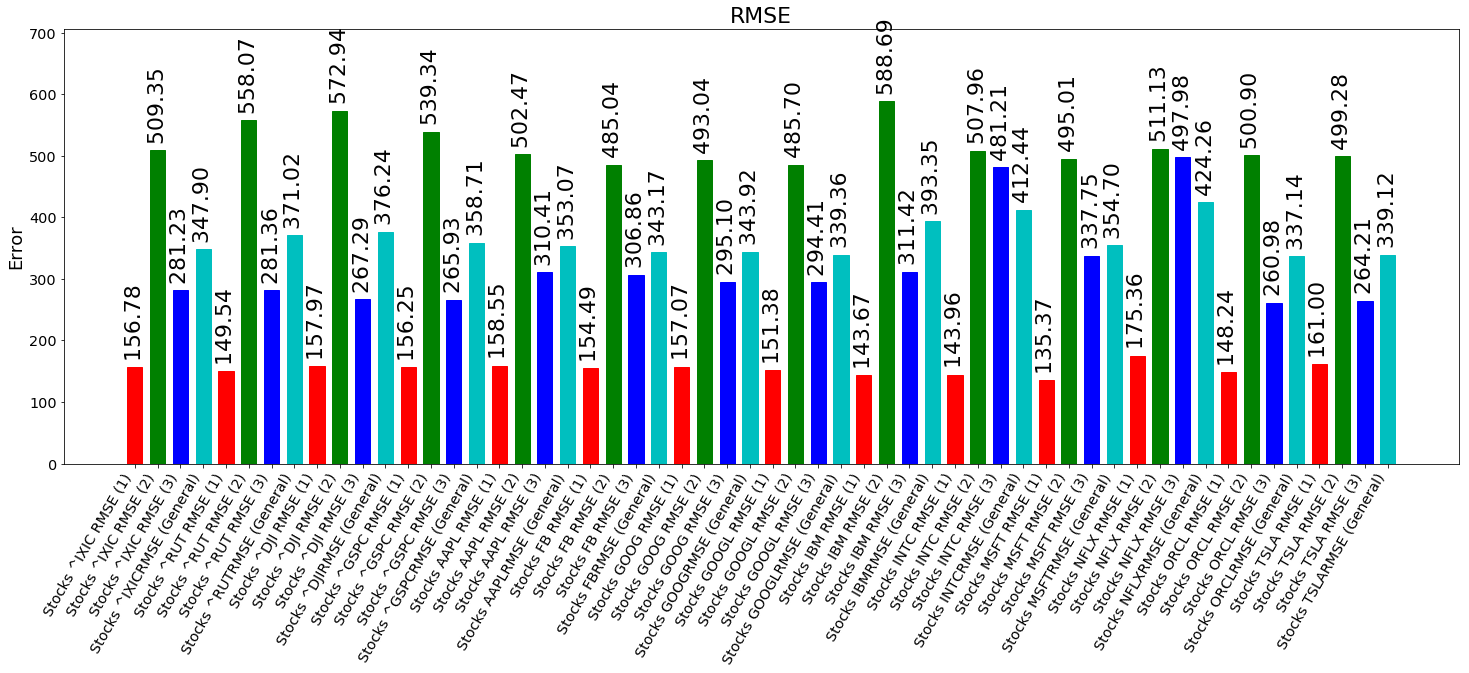

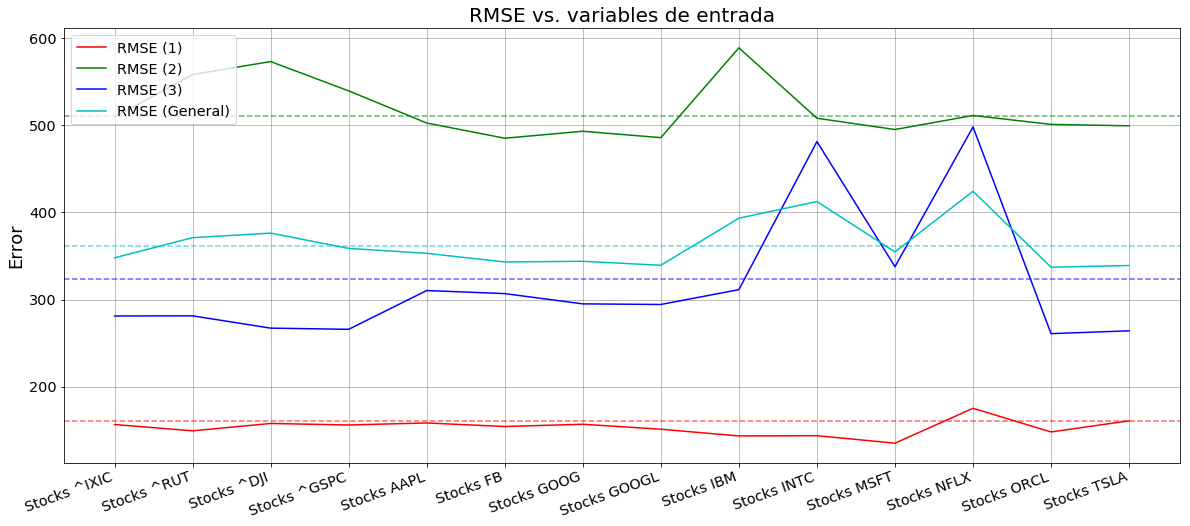

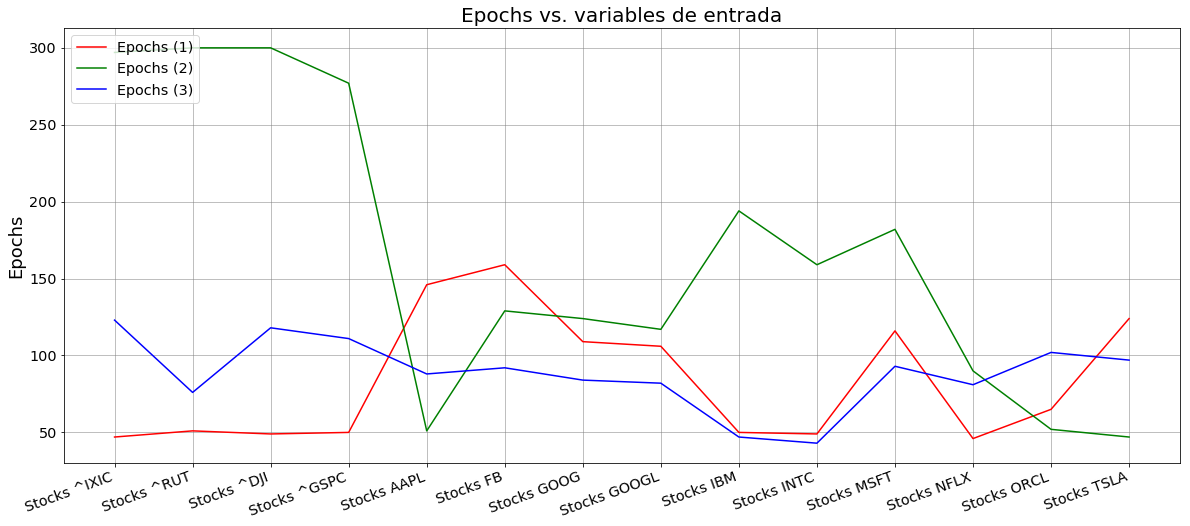

In [81]:
prediccion_variables_stocks = pd.read_csv(datasetfolder + '/' + 'Stocks' + '.csv')
prediccion_variables_stocks['Date'] = pd.to_datetime(prediccion_variables_stocks['Date'])
prediccion_variables_stocks.set_index('Date', inplace=True)

dataframe_rmse, dataframe_epochs = postprocesamiento(prediccion_variables_stocks, name='Stocks', name_parametro='variables de entrada', referencia = ref)

In [22]:
# Trends
cols =  cols = ['trend_' + m for m in top_criptomonedas]
data = pd.read_csv('data/data.csv', usecols= ['Date'] +  ['Close bitcoin'] + cols)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[:'2018-05-25']

prediccion_variables_trends = simulacionVariables(data, 512, "Trends")

Train on 696 samples, validate on 174 samples
Epoch 1/300
696/696 [==============================] - 2s 3ms/step - loss: 0.0137 - val_loss: 0.1783
Epoch 2/300
696/696 [==============================] - 1s 836us/step - loss: 0.0065 - val_loss: 0.1267
Epoch 3/300
696/696 [==============================] - 1s 810us/step - loss: 0.0045 - val_loss: 0.0922
Epoch 4/300
696/696 [==============================] - 1s 754us/step - loss: 0.0053 - val_loss: 0.0748
Epoch 5/300
696/696 [==============================] - 1s 783us/step - loss: 0.0062 - val_loss: 0.0695
Epoch 6/300
696/696 [==============================] - 1s 778us/step - loss: 0.0060 - val_loss: 0.0700
Epoch 7/300
696/696 [==============================] - 1s 728us/step - loss: 0.0054 - val_loss: 0.0713
Epoch 8/300
696/696 [==============================] - 1s 798us/step - loss: 0.0047 - val_loss: 0.0704
Epoch 9/300
696/696 [==============================] - 1s 818us/step - loss: 0.0043 - val_loss: 0.0669
Epoch 10/300
696/696 [=======

832/832 [==============================] - 1s 913us/step - loss: 5.6028e-05 - val_loss: 0.0013
Epoch 29/300
832/832 [==============================] - 1s 760us/step - loss: 5.4668e-05 - val_loss: 0.0013
Epoch 30/300
832/832 [==============================] - 1s 776us/step - loss: 5.3534e-05 - val_loss: 0.0013
Epoch 31/300
832/832 [==============================] - 1s 790us/step - loss: 5.2542e-05 - val_loss: 0.0013
Epoch 32/300
832/832 [==============================] - 1s 774us/step - loss: 5.1633e-05 - val_loss: 0.0013
Epoch 33/300
832/832 [==============================] - 1s 793us/step - loss: 5.0771e-05 - val_loss: 0.0013
Epoch 34/300
832/832 [==============================] - 1s 777us/step - loss: 4.9938e-05 - val_loss: 0.0012
Epoch 35/300
832/832 [==============================] - 1s 740us/step - loss: 4.9123e-05 - val_loss: 0.0012
Epoch 36/300
832/832 [==============================] - 1s 775us/step - loss: 4.8315e-05 - val_loss: 0.0012
Epoch 37/300
832/832 [===================

Epoch 102/300
832/832 [==============================] - 1s 826us/step - loss: 1.0269e-05 - val_loss: 4.9691e-04
Epoch 103/300
832/832 [==============================] - 1s 805us/step - loss: 1.0058e-05 - val_loss: 4.9420e-04
Epoch 104/300
832/832 [==============================] - 1s 900us/step - loss: 9.8564e-06 - val_loss: 4.9168e-04
Epoch 105/300
832/832 [==============================] - 1s 826us/step - loss: 9.6656e-06 - val_loss: 4.8935e-04
Epoch 106/300
832/832 [==============================] - 1s 829us/step - loss: 9.4838e-06 - val_loss: 4.8720e-04
Epoch 107/300
832/832 [==============================] - 1s 825us/step - loss: 9.3119e-06 - val_loss: 4.8522e-04
Epoch 108/300
832/832 [==============================] - 1s 777us/step - loss: 9.1489e-06 - val_loss: 4.8340e-04
Epoch 109/300
832/832 [==============================] - 1s 799us/step - loss: 8.9949e-06 - val_loss: 4.8174e-04
Epoch 110/300
832/832 [==============================] - 1s 762us/step - loss: 8.8493e-06 - val_

968/968 [==============================] - 1s 754us/step - loss: 2.6973e-05 - val_loss: 0.0060
Epoch 36/300
968/968 [==============================] - 1s 771us/step - loss: 2.6801e-05 - val_loss: 0.0059
Epoch 37/300
968/968 [==============================] - 1s 750us/step - loss: 2.6628e-05 - val_loss: 0.0059
Epoch 38/300
968/968 [==============================] - 1s 781us/step - loss: 2.6453e-05 - val_loss: 0.0059
Epoch 39/300
968/968 [==============================] - 1s 801us/step - loss: 2.6277e-05 - val_loss: 0.0058
Epoch 40/300
968/968 [==============================] - 1s 845us/step - loss: 2.6099e-05 - val_loss: 0.0058
Epoch 41/300
968/968 [==============================] - 1s 810us/step - loss: 2.5920e-05 - val_loss: 0.0057
Epoch 42/300
968/968 [==============================] - 1s 829us/step - loss: 2.5739e-05 - val_loss: 0.0057
Epoch 43/300
968/968 [==============================] - 1s 792us/step - loss: 2.5557e-05 - val_loss: 0.0056
Epoch 44/300
968/968 [===================

Epoch 111/300
968/968 [==============================] - 1s 867us/step - loss: 1.3198e-05 - val_loss: 0.0028
Epoch 112/300
968/968 [==============================] - 1s 882us/step - loss: 1.3046e-05 - val_loss: 0.0028
Epoch 113/300
968/968 [==============================] - 1s 820us/step - loss: 1.2896e-05 - val_loss: 0.0027
Epoch 114/300
968/968 [==============================] - 1s 763us/step - loss: 1.2748e-05 - val_loss: 0.0027
Epoch 115/300
968/968 [==============================] - 1s 798us/step - loss: 1.2601e-05 - val_loss: 0.0027
Epoch 116/300
968/968 [==============================] - 1s 814us/step - loss: 1.2456e-05 - val_loss: 0.0026
Epoch 117/300
968/968 [==============================] - 1s 838us/step - loss: 1.2313e-05 - val_loss: 0.0026
Epoch 118/300
968/968 [==============================] - 1s 970us/step - loss: 1.2171e-05 - val_loss: 0.0026
Epoch 119/300
968/968 [==============================] - 1s 1ms/step - loss: 1.2030e-05 - val_loss: 0.0025
Epoch 120/300
968/968

968/968 [==============================] - 1s 734us/step - loss: 6.5904e-06 - val_loss: 0.0014
Epoch 187/300
968/968 [==============================] - 1s 737us/step - loss: 6.5615e-06 - val_loss: 0.0014
Epoch 188/300
968/968 [==============================] - 1s 865us/step - loss: 6.5338e-06 - val_loss: 0.0014
Epoch 189/300
968/968 [==============================] - 1s 935us/step - loss: 6.5068e-06 - val_loss: 0.0014
Epoch 190/300
968/968 [==============================] - 1s 1ms/step - loss: 6.4808e-06 - val_loss: 0.0014
Epoch 191/300
968/968 [==============================] - 1s 1ms/step - loss: 6.4560e-06 - val_loss: 0.0014
Epoch 192/300
968/968 [==============================] - 1s 895us/step - loss: 6.4324e-06 - val_loss: 0.0014
Epoch 193/300
968/968 [==============================] - 1s 796us/step - loss: 6.4097e-06 - val_loss: 0.0014
Epoch 194/300
968/968 [==============================] - 1s 939us/step - loss: 6.3876e-06 - val_loss: 0.0014
Epoch 195/300
968/968 [==============

968/968 [==============================] - 1s 700us/step - loss: 1.6226e-05 - val_loss: 0.0013
Epoch 262/300
968/968 [==============================] - 1s 738us/step - loss: 6.8123e-05 - val_loss: 0.0012
Epoch 263/300
968/968 [==============================] - 1s 847us/step - loss: 7.9848e-05 - val_loss: 0.0021
Epoch 264/300
968/968 [==============================] - 1s 833us/step - loss: 5.0696e-05 - val_loss: 0.0034
Epoch 265/300
968/968 [==============================] - 1s 830us/step - loss: 1.8385e-04 - val_loss: 0.0012
Epoch 266/300
968/968 [==============================] - 1s 858us/step - loss: 9.4711e-05 - val_loss: 0.0033
Epoch 00266: early stopping
Entrenamiento Trends trend_bitcoin(1) completo.
[[7727.762 ]
 [8082.8193]
 [7839.432 ]
 [8133.626 ]
 [8189.4653]
 [8043.0845]
 [7943.466 ]
 [8039.2896]
 [8455.913 ]
 [8420.543 ]
 [8549.721 ]
 [8382.827 ]
 [8147.5776]
 [8030.1826]
 [8100.15  ]
 [7865.5664]
 [7368.2905]
 [7416.0825]
 [7591.254 ]
 [7585.402 ]
 [7416.497 ]
 [7300.714 

696/696 [==============================] - 1s 1ms/step - loss: 6.3344e-05 - val_loss: 6.1976e-04
Epoch 67/300
696/696 [==============================] - 1s 969us/step - loss: 6.0654e-05 - val_loss: 5.9999e-04
Epoch 68/300
696/696 [==============================] - 1s 1ms/step - loss: 5.8278e-05 - val_loss: 5.8272e-04
Epoch 69/300
696/696 [==============================] - 1s 916us/step - loss: 5.6187e-05 - val_loss: 5.6770e-04
Epoch 70/300
696/696 [==============================] - 1s 784us/step - loss: 5.4351e-05 - val_loss: 5.5470e-04
Epoch 71/300
696/696 [==============================] - 1s 831us/step - loss: 5.2744e-05 - val_loss: 5.4349e-04
Epoch 72/300
696/696 [==============================] - 1s 870us/step - loss: 5.1344e-05 - val_loss: 5.3389e-04
Epoch 73/300
696/696 [==============================] - 1s 810us/step - loss: 5.0129e-05 - val_loss: 5.2569e-04
Epoch 74/300
696/696 [==============================] - 1s 818us/step - loss: 4.9077e-05 - val_loss: 5.1872e-04
Epoch 75/

696/696 [==============================] - 1s 863us/step - loss: 4.3136e-05 - val_loss: 4.7951e-04
Epoch 140/300
696/696 [==============================] - 1s 827us/step - loss: 4.3135e-05 - val_loss: 4.7930e-04
Epoch 141/300
696/696 [==============================] - 1s 882us/step - loss: 4.3135e-05 - val_loss: 4.7909e-04
Epoch 142/300
696/696 [==============================] - 1s 869us/step - loss: 4.3134e-05 - val_loss: 4.7887e-04
Epoch 143/300
696/696 [==============================] - 1s 847us/step - loss: 4.3133e-05 - val_loss: 4.7866e-04
Epoch 144/300
696/696 [==============================] - 1s 821us/step - loss: 4.3133e-05 - val_loss: 4.7844e-04
Epoch 145/300
696/696 [==============================] - 1s 869us/step - loss: 4.3132e-05 - val_loss: 4.7823e-04
Epoch 146/300
696/696 [==============================] - 1s 849us/step - loss: 4.3131e-05 - val_loss: 4.7801e-04
Epoch 147/300
696/696 [==============================] - 1s 841us/step - loss: 4.3131e-05 - val_loss: 4.7780e-

696/696 [==============================] - 0s 656us/step - loss: 4.3080e-05 - val_loss: 4.6368e-04
Epoch 212/300
696/696 [==============================] - 0s 638us/step - loss: 4.3079e-05 - val_loss: 4.6346e-04
Epoch 213/300
696/696 [==============================] - 0s 661us/step - loss: 4.3078e-05 - val_loss: 4.6324e-04
Epoch 214/300
696/696 [==============================] - 0s 648us/step - loss: 4.3077e-05 - val_loss: 4.6302e-04
Epoch 215/300
696/696 [==============================] - 0s 649us/step - loss: 4.3076e-05 - val_loss: 4.6281e-04
Epoch 216/300
696/696 [==============================] - 0s 653us/step - loss: 4.3075e-05 - val_loss: 4.6259e-04
Epoch 217/300
696/696 [==============================] - 0s 661us/step - loss: 4.3074e-05 - val_loss: 4.6237e-04
Epoch 218/300
696/696 [==============================] - 0s 650us/step - loss: 4.3073e-05 - val_loss: 4.6216e-04
Epoch 219/300
696/696 [==============================] - 0s 653us/step - loss: 4.3073e-05 - val_loss: 4.6194e-

696/696 [==============================] - 0s 653us/step - loss: 4.3013e-05 - val_loss: 4.4918e-04
Epoch 284/300
696/696 [==============================] - 0s 648us/step - loss: 4.3012e-05 - val_loss: 4.4900e-04
Epoch 285/300
696/696 [==============================] - 0s 673us/step - loss: 4.3011e-05 - val_loss: 4.4883e-04
Epoch 286/300
696/696 [==============================] - 0s 643us/step - loss: 4.3010e-05 - val_loss: 4.4865e-04
Epoch 287/300
696/696 [==============================] - 0s 656us/step - loss: 4.3009e-05 - val_loss: 4.4848e-04
Epoch 288/300
696/696 [==============================] - 0s 648us/step - loss: 4.3008e-05 - val_loss: 4.4831e-04
Epoch 289/300
696/696 [==============================] - 0s 655us/step - loss: 4.3007e-05 - val_loss: 4.4813e-04
Epoch 290/300
696/696 [==============================] - 0s 649us/step - loss: 4.3006e-05 - val_loss: 4.4796e-04
Epoch 291/300
696/696 [==============================] - 0s 646us/step - loss: 4.3005e-05 - val_loss: 4.4779e-

Epoch 54/300
832/832 [==============================] - 1s 645us/step - loss: 1.7701e-05 - val_loss: 0.0016
Epoch 55/300
832/832 [==============================] - 1s 652us/step - loss: 1.6411e-05 - val_loss: 0.0015
Epoch 56/300
832/832 [==============================] - 1s 637us/step - loss: 1.5243e-05 - val_loss: 0.0014
Epoch 57/300
832/832 [==============================] - 1s 638us/step - loss: 1.4188e-05 - val_loss: 0.0012
Epoch 58/300
832/832 [==============================] - 1s 650us/step - loss: 1.3239e-05 - val_loss: 0.0011
Epoch 59/300
832/832 [==============================] - 1s 645us/step - loss: 1.2392e-05 - val_loss: 0.0010
Epoch 60/300
832/832 [==============================] - 1s 633us/step - loss: 1.1636e-05 - val_loss: 9.5142e-04
Epoch 61/300
832/832 [==============================] - 1s 643us/step - loss: 1.0969e-05 - val_loss: 8.7745e-04
Epoch 62/300
832/832 [==============================] - 1s 653us/step - loss: 1.0378e-05 - val_loss: 8.1313e-04
Epoch 63/300
832

Epoch 33/300
968/968 [==============================] - 1s 644us/step - loss: 8.8643e-05 - val_loss: 0.0183
Epoch 34/300
968/968 [==============================] - 1s 624us/step - loss: 8.0232e-05 - val_loss: 0.0163
Epoch 35/300
968/968 [==============================] - 1s 629us/step - loss: 7.2219e-05 - val_loss: 0.0144
Epoch 36/300
968/968 [==============================] - 1s 633us/step - loss: 6.4641e-05 - val_loss: 0.0127
Epoch 37/300
968/968 [==============================] - 1s 630us/step - loss: 5.7529e-05 - val_loss: 0.0111
Epoch 38/300
968/968 [==============================] - 1s 641us/step - loss: 5.0911e-05 - val_loss: 0.0096
Epoch 39/300
968/968 [==============================] - 1s 623us/step - loss: 4.4807e-05 - val_loss: 0.0082
Epoch 40/300
968/968 [==============================] - 1s 631us/step - loss: 3.9231e-05 - val_loss: 0.0070
Epoch 41/300
968/968 [==============================] - 1s 639us/step - loss: 3.4188e-05 - val_loss: 0.0059
Epoch 42/300
968/968 [======

696/696 [==============================] - 0s 656us/step - loss: 4.8021e-05 - val_loss: 4.3675e-04
Epoch 40/300
696/696 [==============================] - 0s 665us/step - loss: 4.6087e-05 - val_loss: 4.3479e-04
Epoch 41/300
696/696 [==============================] - 0s 666us/step - loss: 4.5023e-05 - val_loss: 4.3824e-04
Epoch 42/300
696/696 [==============================] - 0s 709us/step - loss: 4.4464e-05 - val_loss: 4.4352e-04
Epoch 43/300
696/696 [==============================] - 1s 807us/step - loss: 4.4185e-05 - val_loss: 4.4876e-04
Epoch 44/300
696/696 [==============================] - 0s 671us/step - loss: 4.4053e-05 - val_loss: 4.5311e-04
Epoch 45/300
696/696 [==============================] - 0s 698us/step - loss: 4.3993e-05 - val_loss: 4.5635e-04
Epoch 46/300
696/696 [==============================] - 0s 688us/step - loss: 4.3964e-05 - val_loss: 4.5855e-04
Epoch 47/300
696/696 [==============================] - 0s 682us/step - loss: 4.3949e-05 - val_loss: 4.5993e-04
Epoch

Epoch 10/300
968/968 [==============================] - 1s 645us/step - loss: 8.6360e-04 - val_loss: 0.0811
Epoch 11/300
968/968 [==============================] - ETA: 0s - loss: 3.9466e-0 - 1s 670us/step - loss: 7.7183e-04 - val_loss: 0.0704
Epoch 12/300
968/968 [==============================] - 1s 676us/step - loss: 6.8875e-04 - val_loss: 0.0601
Epoch 13/300
968/968 [==============================] - 1s 712us/step - loss: 6.0879e-04 - val_loss: 0.0503
Epoch 14/300
968/968 [==============================] - 1s 707us/step - loss: 5.2887e-04 - val_loss: 0.0413
Epoch 15/300
968/968 [==============================] - ETA: 0s - loss: 2.3731e-0 - 1s 686us/step - loss: 4.5034e-04 - val_loss: 0.0330
Epoch 16/300
968/968 [==============================] - 1s 660us/step - loss: 3.7654e-04 - val_loss: 0.0256
Epoch 17/300
968/968 [==============================] - 1s 669us/step - loss: 3.0919e-04 - val_loss: 0.0194
Epoch 18/300
968/968 [==============================] - 1s 727us/step - loss: 2.

696/696 [==============================] - 0s 659us/step - loss: 8.7319e-05 - val_loss: 6.0930e-04
Epoch 49/300
696/696 [==============================] - 0s 663us/step - loss: 8.5948e-05 - val_loss: 6.0235e-04
Epoch 50/300
696/696 [==============================] - 0s 673us/step - loss: 8.4612e-05 - val_loss: 5.9549e-04
Epoch 51/300
696/696 [==============================] - 0s 658us/step - loss: 8.3296e-05 - val_loss: 5.8873e-04
Epoch 52/300
696/696 [==============================] - 0s 662us/step - loss: 8.2010e-05 - val_loss: 5.8215e-04
Epoch 53/300
696/696 [==============================] - 0s 672us/step - loss: 8.0750e-05 - val_loss: 5.7576e-04
Epoch 54/300
696/696 [==============================] - 0s 676us/step - loss: 7.9516e-05 - val_loss: 5.6954e-04
Epoch 55/300
696/696 [==============================] - 0s 653us/step - loss: 7.8310e-05 - val_loss: 5.6355e-04
Epoch 56/300
696/696 [==============================] - 0s 669us/step - loss: 7.7131e-05 - val_loss: 5.5774e-04
Epoch

696/696 [==============================] - 1s 739us/step - loss: 4.4750e-05 - val_loss: 4.3378e-04
Epoch 122/300
696/696 [==============================] - 1s 729us/step - loss: 4.4654e-05 - val_loss: 4.3373e-04
Epoch 123/300
696/696 [==============================] - 1s 739us/step - loss: 4.4563e-05 - val_loss: 4.3369e-04
Epoch 124/300
696/696 [==============================] - 1s 741us/step - loss: 4.4477e-05 - val_loss: 4.3367e-04
Epoch 125/300
696/696 [==============================] - ETA: 0s - loss: 4.4500e-0 - 1s 774us/step - loss: 4.4395e-05 - val_loss: 4.3366e-04
Epoch 126/300
696/696 [==============================] - 1s 758us/step - loss: 4.4317e-05 - val_loss: 4.3365e-04
Epoch 127/300
696/696 [==============================] - 1s 741us/step - loss: 4.4244e-05 - val_loss: 4.3366e-04
Epoch 128/300
696/696 [==============================] - 1s 747us/step - loss: 4.4174e-05 - val_loss: 4.3368e-04
Epoch 129/300
696/696 [==============================] - 1s 742us/step - loss: 4.4

Epoch 55/300
832/832 [==============================] - 1s 733us/step - loss: 1.0972e-05 - val_loss: 5.2774e-04
Epoch 56/300
832/832 [==============================] - 1s 741us/step - loss: 1.0647e-05 - val_loss: 5.2396e-04
Epoch 57/300
832/832 [==============================] - 1s 733us/step - loss: 1.0344e-05 - val_loss: 5.2048e-04
Epoch 58/300
832/832 [==============================] - 1s 738us/step - loss: 1.0062e-05 - val_loss: 5.1726e-04
Epoch 59/300
832/832 [==============================] - 1s 734us/step - loss: 9.8003e-06 - val_loss: 5.1430e-04
Epoch 60/300
832/832 [==============================] - 1s 728us/step - loss: 9.5577e-06 - val_loss: 5.1158e-04
Epoch 61/300
832/832 [==============================] - 1s 723us/step - loss: 9.3329e-06 - val_loss: 5.0907e-04
Epoch 62/300
832/832 [==============================] - 1s 726us/step - loss: 9.1249e-06 - val_loss: 5.0678e-04
Epoch 63/300
832/832 [==============================] - 1s 756us/step - loss: 8.9326e-06 - val_loss: 5.0

Epoch 128/300
832/832 [==============================] - 1s 751us/step - loss: 6.9287e-06 - val_loss: 4.8335e-04
Epoch 129/300
832/832 [==============================] - 1s 748us/step - loss: 6.9288e-06 - val_loss: 4.8334e-04
Epoch 130/300
832/832 [==============================] - 1s 717us/step - loss: 6.9289e-06 - val_loss: 4.8333e-04
Epoch 131/300
832/832 [==============================] - 1s 752us/step - loss: 6.9290e-06 - val_loss: 4.8332e-04
Epoch 132/300
832/832 [==============================] - 1s 714us/step - loss: 6.9292e-06 - val_loss: 4.8331e-04
Epoch 133/300
832/832 [==============================] - 1s 733us/step - loss: 6.9293e-06 - val_loss: 4.8330e-04
Epoch 134/300
832/832 [==============================] - 1s 730us/step - loss: 6.9295e-06 - val_loss: 4.8329e-04
Epoch 135/300
832/832 [==============================] - 1s 729us/step - loss: 6.9297e-06 - val_loss: 4.8328e-04
Epoch 136/300
832/832 [==============================] - 1s 742us/step - loss: 6.9298e-06 - val_

832/832 [==============================] - 1s 726us/step - loss: 6.9528e-06 - val_loss: 4.8280e-04
Epoch 201/300
832/832 [==============================] - 1s 733us/step - loss: 6.9533e-06 - val_loss: 4.8279e-04
Epoch 202/300
832/832 [==============================] - 1s 765us/step - loss: 6.9539e-06 - val_loss: 4.8279e-04
Epoch 203/300
832/832 [==============================] - 1s 728us/step - loss: 6.9545e-06 - val_loss: 4.8279e-04
Epoch 204/300
832/832 [==============================] - 1s 750us/step - loss: 6.9551e-06 - val_loss: 4.8278e-04
Epoch 205/300
832/832 [==============================] - 1s 733us/step - loss: 6.9557e-06 - val_loss: 4.8278e-04
Epoch 206/300
832/832 [==============================] - 1s 732us/step - loss: 6.9563e-06 - val_loss: 4.8277e-04
Epoch 207/300
832/832 [==============================] - 1s 734us/step - loss: 6.9570e-06 - val_loss: 4.8277e-04
Epoch 208/300
832/832 [==============================] - 1s 727us/step - loss: 6.9577e-06 - val_loss: 4.8277e-

968/968 [==============================] - 1s 714us/step - loss: 5.9807e-05 - val_loss: 0.0036
Epoch 31/300
968/968 [==============================] - 1s 725us/step - loss: 5.7075e-05 - val_loss: 0.0032
Epoch 32/300
968/968 [==============================] - 1s 723us/step - loss: 5.4549e-05 - val_loss: 0.0029
Epoch 33/300
968/968 [==============================] - 1s 705us/step - loss: 5.2105e-05 - val_loss: 0.0026
Epoch 34/300
968/968 [==============================] - 1s 709us/step - loss: 4.9689e-05 - val_loss: 0.0024
Epoch 35/300
968/968 [==============================] - 1s 739us/step - loss: 4.7295e-05 - val_loss: 0.0023
Epoch 36/300
968/968 [==============================] - 1s 722us/step - loss: 4.4935e-05 - val_loss: 0.0021
Epoch 37/300
968/968 [==============================] - 1s 715us/step - loss: 4.2628e-05 - val_loss: 0.0020
Epoch 38/300
968/968 [==============================] - 1s 713us/step - loss: 4.0389e-05 - val_loss: 0.0019
Epoch 39/300
968/968 [===================

Epoch 29/300
696/696 [==============================] - 1s 727us/step - loss: 6.6343e-04 - val_loss: 0.0188
Epoch 30/300
696/696 [==============================] - 1s 731us/step - loss: 5.6547e-04 - val_loss: 0.0156
Epoch 31/300
696/696 [==============================] - 1s 725us/step - loss: 4.7758e-04 - val_loss: 0.0128
Epoch 32/300
696/696 [==============================] - 1s 738us/step - loss: 3.9989e-04 - val_loss: 0.0104
Epoch 33/300
696/696 [==============================] - 1s 833us/step - loss: 3.3233e-04 - val_loss: 0.0083
Epoch 34/300
696/696 [==============================] - 1s 761us/step - loss: 2.7441e-04 - val_loss: 0.0066
Epoch 35/300
696/696 [==============================] - 1s 788us/step - loss: 2.2557e-04 - val_loss: 0.0051
Epoch 36/300
696/696 [==============================] - 1s 791us/step - loss: 1.8500e-04 - val_loss: 0.0039
Epoch 37/300
696/696 [==============================] - 1s 770us/step - loss: 1.5178e-04 - val_loss: 0.0030
Epoch 38/300
696/696 [======

832/832 [==============================] - 1s 729us/step - loss: 8.0804e-06 - val_loss: 5.1178e-04
Epoch 41/300
832/832 [==============================] - 1s 724us/step - loss: 7.6563e-06 - val_loss: 5.0842e-04
Epoch 42/300
832/832 [==============================] - 1s 744us/step - loss: 7.3798e-06 - val_loss: 5.0665e-04
Epoch 43/300
832/832 [==============================] - 1s 752us/step - loss: 7.2016e-06 - val_loss: 5.0586e-04
Epoch 44/300
832/832 [==============================] - 1s 738us/step - loss: 7.0894e-06 - val_loss: 5.0565e-04
Epoch 45/300
832/832 [==============================] - 1s 772us/step - loss: 7.0203e-06 - val_loss: 5.0573e-04
Epoch 46/300
832/832 [==============================] - 1s 735us/step - loss: 6.9781e-06 - val_loss: 5.0596e-04
Epoch 47/300
832/832 [==============================] - 1s 750us/step - loss: 6.9530e-06 - val_loss: 5.0622e-04
Epoch 48/300
832/832 [==============================] - 1s 744us/step - loss: 6.9381e-06 - val_loss: 5.0648e-04
Epoch

696/696 [==============================] - 1s 768us/step - loss: 0.0014 - val_loss: 0.0137
Epoch 20/300
696/696 [==============================] - 1s 775us/step - loss: 0.0013 - val_loss: 0.0115
Epoch 21/300
696/696 [==============================] - 1s 777us/step - loss: 0.0012 - val_loss: 0.0096
Epoch 22/300
696/696 [==============================] - 1s 752us/step - loss: 0.0011 - val_loss: 0.0080
Epoch 23/300
696/696 [==============================] - 1s 758us/step - loss: 9.6257e-04 - val_loss: 0.0067
Epoch 24/300
696/696 [==============================] - 1s 747us/step - loss: 8.7844e-04 - val_loss: 0.0055
Epoch 25/300
696/696 [==============================] - 1s 778us/step - loss: 8.0427e-04 - val_loss: 0.0046
Epoch 26/300
696/696 [==============================] - 1s 744us/step - loss: 7.3847e-04 - val_loss: 0.0038
Epoch 27/300
696/696 [==============================] - 1s 757us/step - loss: 6.7910e-04 - val_loss: 0.0032
Epoch 28/300
696/696 [==============================] - 1

832/832 [==============================] - 1s 744us/step - loss: 1.5409e-04 - val_loss: 0.0099
Epoch 22/300
832/832 [==============================] - 1s 736us/step - loss: 1.4863e-04 - val_loss: 0.0091
Epoch 23/300
832/832 [==============================] - 1s 753us/step - loss: 1.4335e-04 - val_loss: 0.0085
Epoch 24/300
832/832 [==============================] - 1s 747us/step - loss: 1.3817e-04 - val_loss: 0.0080
Epoch 25/300
832/832 [==============================] - 1s 746us/step - loss: 1.3294e-04 - val_loss: 0.0076
Epoch 26/300
832/832 [==============================] - 1s 747us/step - loss: 1.2771e-04 - val_loss: 0.0072
Epoch 27/300
832/832 [==============================] - 1s 735us/step - loss: 1.2252e-04 - val_loss: 0.0069
Epoch 28/300
832/832 [==============================] - 1s 747us/step - loss: 1.1737e-04 - val_loss: 0.0066
Epoch 29/300
832/832 [==============================] - 1s 763us/step - loss: 1.1228e-04 - val_loss: 0.0062
Epoch 30/300
832/832 [===================

Train on 968 samples, validate on 242 samples
Epoch 1/300
968/968 [==============================] - 4s 4ms/step - loss: 0.0015 - val_loss: 0.1988
Epoch 2/300
968/968 [==============================] - 1s 736us/step - loss: 0.0015 - val_loss: 0.1704
Epoch 3/300
968/968 [==============================] - 1s 729us/step - loss: 0.0016 - val_loss: 0.1558
Epoch 4/300
968/968 [==============================] - 1s 735us/step - loss: 0.0013 - val_loss: 0.1431
Epoch 5/300
968/968 [==============================] - 1s 747us/step - loss: 0.0010 - val_loss: 0.1282
Epoch 6/300
968/968 [==============================] - 1s 728us/step - loss: 8.6453e-04 - val_loss: 0.1121
Epoch 7/300
968/968 [==============================] - 1s 727us/step - loss: 7.5379e-04 - val_loss: 0.0971
Epoch 8/300
968/968 [==============================] - 1s 770us/step - loss: 6.5909e-04 - val_loss: 0.0841
Epoch 9/300
968/968 [==============================] - 1s 745us/step - loss: 5.5244e-04 - val_loss: 0.0722
Epoch 10/300


968/968 [==============================] - 1s 736us/step - loss: 1.2288e-05 - val_loss: 0.0014
Epoch 77/300
968/968 [==============================] - 1s 734us/step - loss: 1.1681e-05 - val_loss: 0.0014
Epoch 78/300
968/968 [==============================] - 1s 740us/step - loss: 1.1115e-05 - val_loss: 0.0013
Epoch 79/300
968/968 [==============================] - 1s 735us/step - loss: 1.0588e-05 - val_loss: 0.0013
Epoch 80/300
968/968 [==============================] - 1s 735us/step - loss: 1.0099e-05 - val_loss: 0.0013
Epoch 81/300
968/968 [==============================] - 1s 741us/step - loss: 9.6478e-06 - val_loss: 0.0012
Epoch 82/300
968/968 [==============================] - 1s 743us/step - loss: 9.2324e-06 - val_loss: 0.0012-0
Epoch 83/300
968/968 [==============================] - 1s 730us/step - loss: 8.8514e-06 - val_loss: 0.0012
Epoch 84/300
968/968 [==============================] - 1s 749us/step - loss: 8.5039e-06 - val_loss: 0.0012
Epoch 85/300
968/968 [=================

696/696 [==============================] - 1s 758us/step - loss: 4.6747e-05 - val_loss: 4.3351e-04
Epoch 46/300
696/696 [==============================] - 1s 768us/step - loss: 4.5407e-05 - val_loss: 4.3150e-04
Epoch 47/300
696/696 [==============================] - 1s 783us/step - loss: 4.4519e-05 - val_loss: 4.3263e-04
Epoch 48/300
696/696 [==============================] - 1s 791us/step - loss: 4.3940e-05 - val_loss: 4.3538e-04
Epoch 49/300
696/696 [==============================] - 1s 748us/step - loss: 4.3568e-05 - val_loss: 4.3878e-04
Epoch 50/300
696/696 [==============================] - 1s 777us/step - loss: 4.3334e-05 - val_loss: 4.4224e-04
Epoch 51/300
696/696 [==============================] - 1s 767us/step - loss: 4.3188e-05 - val_loss: 4.4544e-04
Epoch 52/300
696/696 [==============================] - 1s 803us/step - loss: 4.3098e-05 - val_loss: 4.4820e-04
Epoch 53/300
696/696 [==============================] - 1s 783us/step - loss: 4.3043e-05 - val_loss: 4.5050e-04
Epoch

Train on 968 samples, validate on 242 samples
Epoch 1/300
968/968 [==============================] - 5s 5ms/step - loss: 0.0015 - val_loss: 0.1981
Epoch 2/300
968/968 [==============================] - 1s 805us/step - loss: 0.0014 - val_loss: 0.1667
Epoch 3/300
968/968 [==============================] - 1s 778us/step - loss: 0.0014 - val_loss: 0.1521
Epoch 4/300
968/968 [==============================] - 1s 743us/step - loss: 0.0011 - val_loss: 0.1407
Epoch 5/300
968/968 [==============================] - 1s 800us/step - loss: 7.9957e-04 - val_loss: 0.1272
Epoch 6/300
968/968 [==============================] - 1s 761us/step - loss: 6.6537e-04 - val_loss: 0.1131
Epoch 7/300
968/968 [==============================] - 1s 722us/step - loss: 6.1551e-04 - val_loss: 0.1012
Epoch 8/300
968/968 [==============================] - 1s 707us/step - loss: 5.8782e-04 - val_loss: 0.0925
Epoch 9/300
968/968 [==============================] - 1s 772us/step - loss: 5.5254e-04 - val_loss: 0.0855
Epoch 10/

696/696 [==============================] - 1s 788us/step - loss: 0.0023 - val_loss: 0.0380
Epoch 18/300
696/696 [==============================] - 1s 781us/step - loss: 0.0021 - val_loss: 0.0331
Epoch 19/300
696/696 [==============================] - 1s 774us/step - loss: 0.0018 - val_loss: 0.0285
Epoch 20/300
696/696 [==============================] - 1s 793us/step - loss: 0.0015 - val_loss: 0.0242
Epoch 21/300
696/696 [==============================] - 1s 784us/step - loss: 0.0013 - val_loss: 0.0201
Epoch 22/300
696/696 [==============================] - 1s 785us/step - loss: 0.0011 - val_loss: 0.0165
Epoch 23/300
696/696 [==============================] - 1s 790us/step - loss: 8.8118e-04 - val_loss: 0.0132
Epoch 24/300
696/696 [==============================] - 1s 810us/step - loss: 7.1153e-04 - val_loss: 0.0105
Epoch 25/300
696/696 [==============================] - 1s 775us/step - loss: 5.6371e-04 - val_loss: 0.0081
Epoch 26/300
696/696 [==============================] - 1s 784us/

696/696 [==============================] - 1s 762us/step - loss: 5.1845e-05 - val_loss: 4.3271e-04
Epoch 92/300
696/696 [==============================] - 1s 780us/step - loss: 5.1648e-05 - val_loss: 4.3258e-04
Epoch 93/300
696/696 [==============================] - 1s 785us/step - loss: 5.1454e-05 - val_loss: 4.3246e-04
Epoch 94/300
696/696 [==============================] - 1s 793us/step - loss: 5.1263e-05 - val_loss: 4.3234e-04
Epoch 95/300
696/696 [==============================] - 1s 783us/step - loss: 5.1074e-05 - val_loss: 4.3223e-04
Epoch 96/300
696/696 [==============================] - 1s 785us/step - loss: 5.0889e-05 - val_loss: 4.3212e-04
Epoch 97/300
696/696 [==============================] - 1s 771us/step - loss: 5.0707e-05 - val_loss: 4.3201e-04
Epoch 98/300
696/696 [==============================] - 1s 781us/step - loss: 5.0527e-05 - val_loss: 4.3191e-04
Epoch 99/300
696/696 [==============================] - 1s 765us/step - loss: 5.0351e-05 - val_loss: 4.3182e-04
Epoch

832/832 [==============================] - 1s 760us/step - loss: 3.4834e-04 - val_loss: 0.0380
Epoch 22/300
832/832 [==============================] - 1s 769us/step - loss: 3.0343e-04 - val_loss: 0.0330
Epoch 23/300
832/832 [==============================] - 1s 789us/step - loss: 2.6158e-04 - val_loss: 0.0284
Epoch 24/300
832/832 [==============================] - 1s 735us/step - loss: 2.2294e-04 - val_loss: 0.0242
Epoch 25/300
832/832 [==============================] - 1s 759us/step - loss: 1.8809e-04 - val_loss: 0.0203
Epoch 26/300
832/832 [==============================] - 1s 777us/step - loss: 1.5695e-04 - val_loss: 0.0169
Epoch 27/300
832/832 [==============================] - 1s 807us/step - loss: 1.2935e-04 - val_loss: 0.0139
Epoch 28/300
832/832 [==============================] - 1s 765us/step - loss: 1.0587e-04 - val_loss: 0.0113
Epoch 29/300
832/832 [==============================] - 1s 794us/step - loss: 8.5714e-05 - val_loss: 0.0091
Epoch 30/300
832/832 [===================

Epoch 95/300
832/832 [==============================] - 1s 774us/step - loss: 8.5116e-06 - val_loss: 5.1481e-04
Epoch 96/300
832/832 [==============================] - 1s 771us/step - loss: 8.4415e-06 - val_loss: 5.1307e-04
Epoch 97/300
832/832 [==============================] - 1s 794us/step - loss: 8.3738e-06 - val_loss: 5.1140e-04
Epoch 98/300
832/832 [==============================] - 1s 775us/step - loss: 8.3087e-06 - val_loss: 5.0981e-04
Epoch 99/300
832/832 [==============================] - 1s 772us/step - loss: 8.2459e-06 - val_loss: 5.0829e-04
Epoch 100/300
832/832 [==============================] - 1s 764us/step - loss: 8.1854e-06 - val_loss: 5.0684e-04
Epoch 101/300
832/832 [==============================] - 1s 778us/step - loss: 8.1272e-06 - val_loss: 5.0545e-04
Epoch 102/300
832/832 [==============================] - 1s 814us/step - loss: 8.0712e-06 - val_loss: 5.0413e-04
Epoch 103/300
832/832 [==============================] - 1s 783us/step - loss: 8.0174e-06 - val_loss:

832/832 [==============================] - 1s 776us/step - loss: 6.9316e-06 - val_loss: 4.8345e-04
Epoch 00167: early stopping
Entrenamiento Trends trend_nem(2) completo.
[[ 7116.024 ]
 [ 7241.6665]
 [ 7566.0957]
 [ 7242.757 ]
 [ 6704.9277]
 [ 6438.8276]
 [ 6022.334 ]
 [ 6648.2954]
 [ 6728.2485]
 [ 7427.987 ]
 [ 8001.7363]
 [ 7836.4834]
 [ 7922.06  ]
 [ 8177.752 ]
 [ 8345.674 ]
 [ 8211.38  ]
 [ 8397.929 ]
 [ 8175.768 ]
 [ 8395.841 ]
 [ 8947.663 ]
 [ 9501.997 ]
 [10009.631 ]
 [10262.865 ]
 [10092.839 ]
 [10454.262 ]
 [11225.855 ]
 [11334.111 ]
 [11597.007 ]
 [11938.741 ]
 [12203.287 ]]
Train on 968 samples, validate on 242 samples
Epoch 1/300
968/968 [==============================] - 6s 6ms/step - loss: 0.0014 - val_loss: 0.1944
Epoch 2/300
968/968 [==============================] - 1s 820us/step - loss: 0.0022 - val_loss: 0.1879
Epoch 3/300
968/968 [==============================] - 1s 764us/step - loss: 0.0019 - val_loss: 0.1867
Epoch 4/300
968/968 [==============================] - 

696/696 [==============================] - 1s 770us/step - loss: 0.0066 - val_loss: 0.0897
Epoch 7/300
696/696 [==============================] - 1s 785us/step - loss: 0.0058 - val_loss: 0.0901
Epoch 8/300
696/696 [==============================] - 1s 765us/step - loss: 0.0053 - val_loss: 0.0868
Epoch 9/300
696/696 [==============================] - 1s 791us/step - loss: 0.0048 - val_loss: 0.0808
Epoch 10/300
696/696 [==============================] - 1s 804us/step - loss: 0.0045 - val_loss: 0.0737
Epoch 11/300
696/696 [==============================] - 1s 784us/step - loss: 0.0043 - val_loss: 0.0672
Epoch 12/300
696/696 [==============================] - 1s 816us/step - loss: 0.0041 - val_loss: 0.0617
Epoch 13/300
696/696 [==============================] - 1s 824us/step - loss: 0.0038 - val_loss: 0.0571
Epoch 14/300
696/696 [==============================] - 1s 817us/step - loss: 0.0036 - val_loss: 0.0528
Epoch 15/300
696/696 [==============================] - 1s 826us/step - loss: 0.

832/832 [==============================] - 1s 796us/step - loss: 7.2143e-05 - val_loss: 0.0058
Epoch 30/300
832/832 [==============================] - 1s 798us/step - loss: 6.4116e-05 - val_loss: 0.0047
Epoch 31/300
832/832 [==============================] - 1s 801us/step - loss: 5.7225e-05 - val_loss: 0.0039
Epoch 32/300
832/832 [==============================] - 1s 790us/step - loss: 5.1242e-05 - val_loss: 0.0033
Epoch 33/300
832/832 [==============================] - 1s 789us/step - loss: 4.5933e-05 - val_loss: 0.0028
Epoch 34/300
832/832 [==============================] - 1s 794us/step - loss: 4.1202e-05 - val_loss: 0.0024
Epoch 35/300
832/832 [==============================] - 1s 782us/step - loss: 3.6954e-05 - val_loss: 0.0020
Epoch 36/300
832/832 [==============================] - 1s 789us/step - loss: 3.3125e-05 - val_loss: 0.0018
Epoch 37/300
832/832 [==============================] - 1s 772us/step - loss: 2.9682e-05 - val_loss: 0.0016
Epoch 38/300
832/832 [===================

Epoch 27/300
968/968 [==============================] - 1s 782us/step - loss: 5.5043e-05 - val_loss: 0.0030
Epoch 28/300
968/968 [==============================] - 1s 789us/step - loss: 5.1611e-05 - val_loss: 0.0027
Epoch 29/300
968/968 [==============================] - 1s 769us/step - loss: 4.8352e-05 - val_loss: 0.0024
Epoch 30/300
968/968 [==============================] - 1s 788us/step - loss: 4.5176e-05 - val_loss: 0.0023
Epoch 31/300
968/968 [==============================] - 1s 786us/step - loss: 4.2072e-05 - val_loss: 0.0021
Epoch 32/300
968/968 [==============================] - 1s 794us/step - loss: 3.9062e-05 - val_loss: 0.0020
Epoch 33/300
968/968 [==============================] - 1s 773us/step - loss: 3.6171e-05 - val_loss: 0.0019
Epoch 34/300
968/968 [==============================] - 1s 786us/step - loss: 3.3424e-05 - val_loss: 0.0018
Epoch 35/300
968/968 [==============================] - 1s 782us/step - loss: 3.0835e-05 - val_loss: 0.0017
Epoch 36/300
968/968 [======

RMSEs guardados: predicciones/Close bitcoin/Close bitcoin Trends_rmses.csv
Epochs guardados: predicciones/Close bitcoin/Close bitcoin Trends_rmses.csv


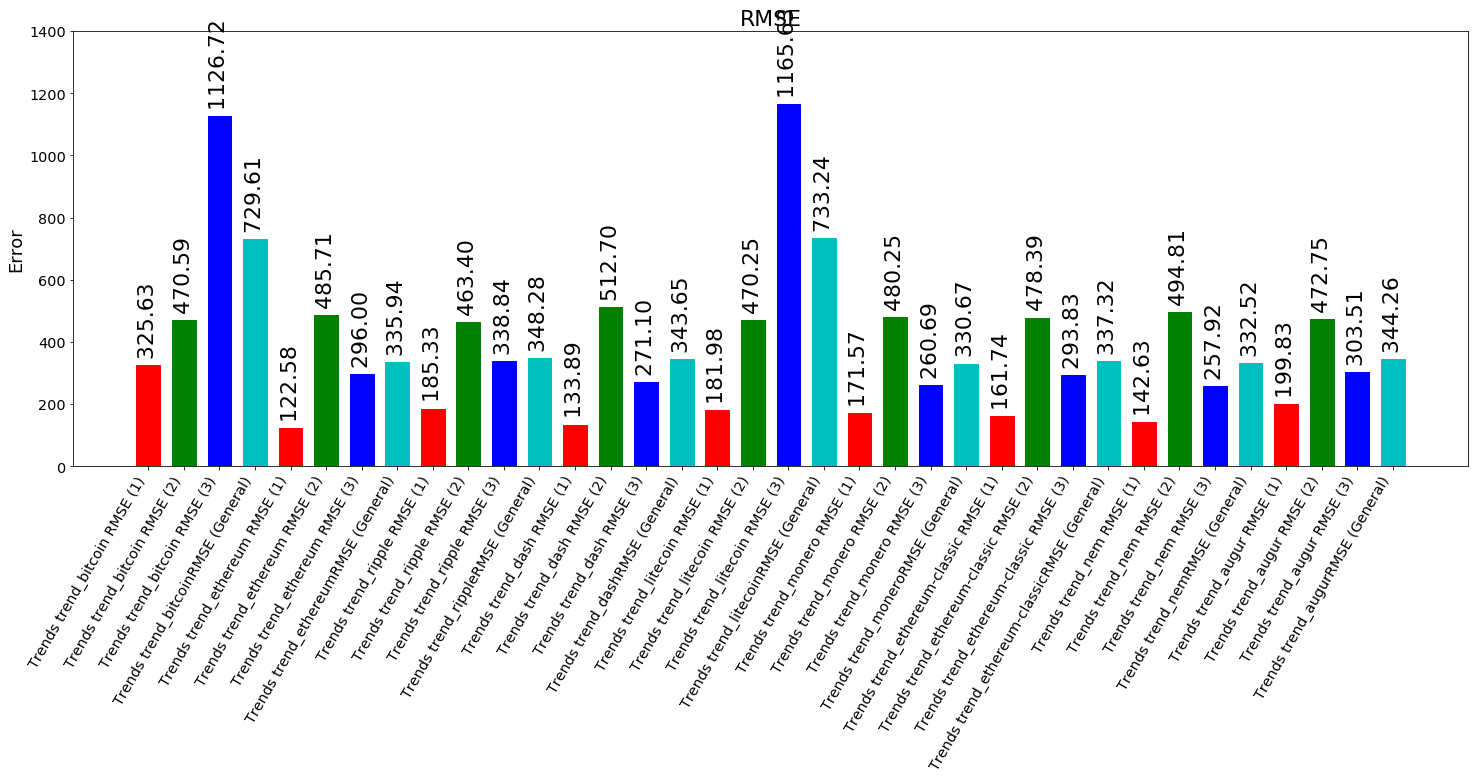

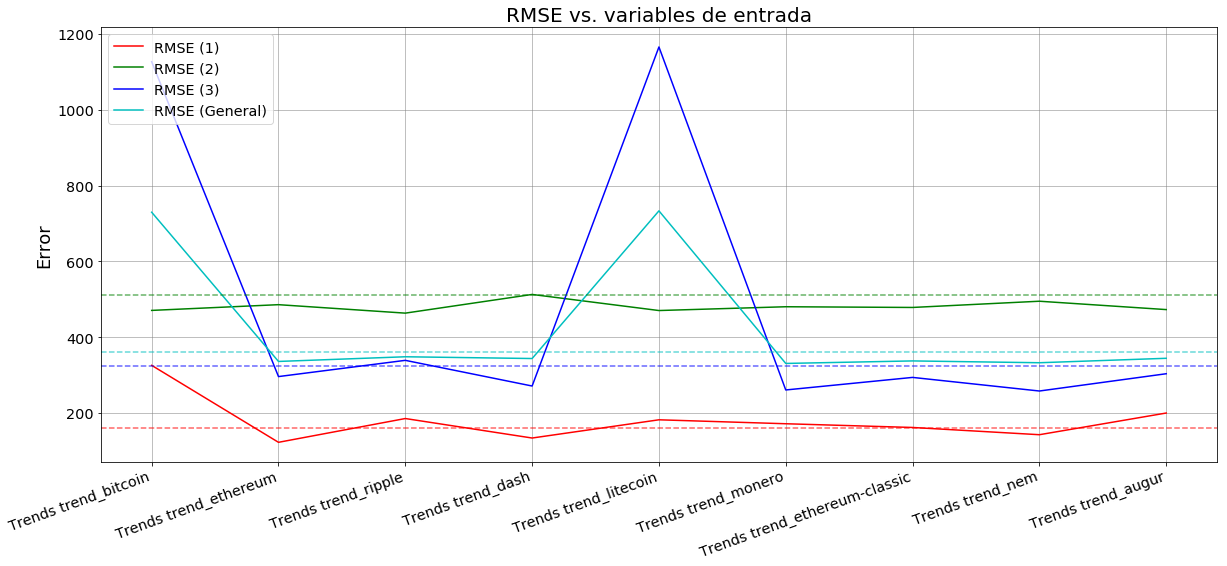

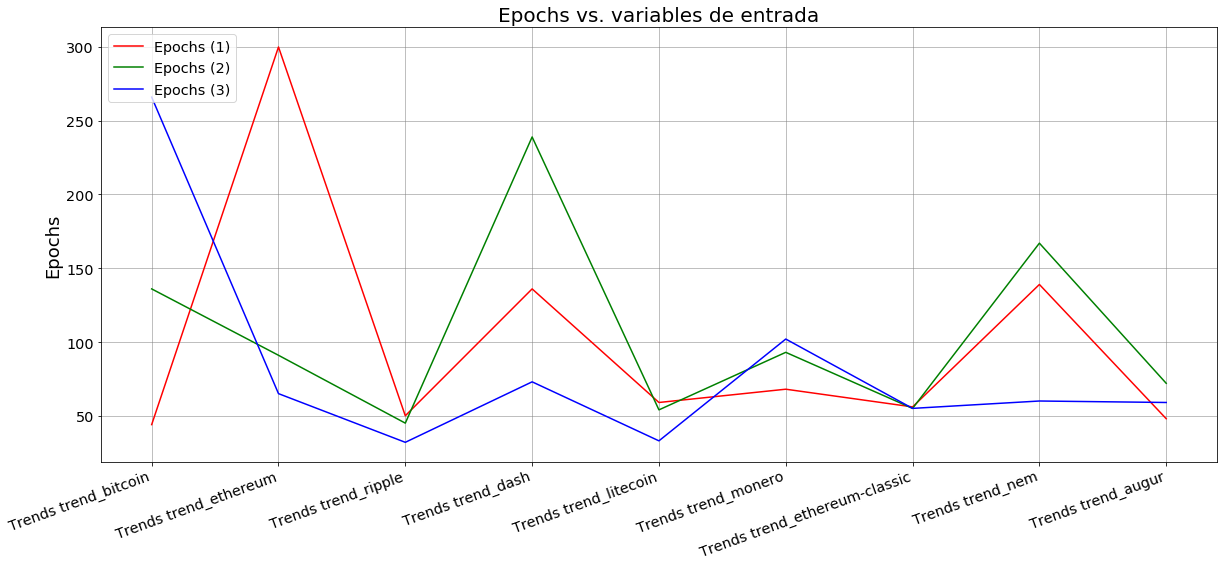

In [82]:
dataframe_rmse, dataframe_epochs = postprocesamiento(prediccion_variables_trends, name='Trends', name_parametro='variables de entrada', referencia=ref)